In [64]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

In [65]:
companies = [
    "SAP", "IBM", "WDAY", "ADP", "ACN",  # Technology
    "NXPI", "STM", "ADI", "ON", "MCHP", "LSCC", "COHR", "AEIS", "ENTG",  # Semiconductors & Software
    "BX", "KKR", "STT", "AMP", "PNC", "CFG", "BK", "NTRS", "FITB",  # Financials
    "UL", "PDD", "JD", "BABA", "SBUX", "YUM", "ROST", "M", "KSS",  # Consumer Discretionary & Retail
    "ZTS", "DHR", "BDX", "SYK", "BSX", "STE", "MTD", "BIO",  # Healthcare
    "TAP", "KMB", "GIS", "HRL", "MDLZ", "LW", "MNST",  # Consumer Staples
]


In [79]:
companies = [
    "OKTA", "DOCU", "CDNS", "ANSS", "TTD",  # Technology
    "ICE", "AJG", "PGR", "CINF", "ALL",     # Financials
    "HES", "MPC", "CLR", "FTI", "WMB",      # Energy
    "ES", "XEL", "WEC", "PEG", "DTE",       # Utilities
    "LVS", "MGM", "HOG", "BBBY", "DHI",     # Consumer Discretionary
    "UPS", "FDX", "ROK", "ETN", "SWK"       # Industrials
]


In [57]:
companies = ['RACE']

In [80]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)].reset_index(drop=True)

In [81]:
def scale_data(uncscaled_data):
    price_columns = ['Open', 'High', 'Low', 'Close']
    technical_indicators = ['SMA15', 'EMA5', 'RSI15', 'BB_upper', 'BB_lower',
                            'MACD', 'MACD_signal', 'OBV', 'ADX', 'Aroon_Up', 'Aroon_Down']
    volume_column = 'Volume'

    for col in price_columns:
        uncscaled_data = remove_outliers(uncscaled_data, col)

    # Standardize price columns
    standard_scaler = StandardScaler()
    uncscaled_data[price_columns] = standard_scaler.fit_transform(uncscaled_data[price_columns])

    # Apply log transformation and standard scaling for volume
    uncscaled_data[volume_column] = np.log1p(uncscaled_data[volume_column])
    uncscaled_data[[volume_column]] = standard_scaler.fit_transform(uncscaled_data[[volume_column]])

    # Standardize technical indicators
    uncscaled_data[technical_indicators] = standard_scaler.fit_transform(uncscaled_data[technical_indicators])

    return uncscaled_data


In [82]:
def calculate_tech_ind(curr, data):
    # Add technical indicators
    data['SMA15'] = ta.sma(curr['Close'], length=15)
    data['EMA5'] = ta.ema(curr['Close'], length=5)
    data['RSI15'] = ta.rsi(curr['Close'], length=15)

    # Bollinger Bands
    data['BB_upper'], data['BB_lower'] = ta.bbands(curr['Close'], length=56, std=2).iloc[:, [0, 2]].T.values

    # MACD and Signal Line
    data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values

    # On-Balance Volume
    data['OBV'] = ta.obv(curr['Close'], curr['Volume'])

    # ADX
    data['ADX'] = ta.adx(curr['High'], curr['Low'], curr['Close']).iloc[:, 0]

    # Aroon Oscillator
    data['Aroon_Up'], data['Aroon_Down'] = ta.aroon(curr['High'], curr['Low']).iloc[:, [0, 1]].T.values

    # Combine curr and indicators
    combined_data = pd.concat([curr, data], axis=1)

    # Drop rows with NaN values
    combined_data.dropna(inplace=True)

    # Scale data
    scaled_data = scale_data(combined_data)

    return scaled_data, combined_data.index


In [83]:
from joblib import load

loaded_model = load('model_reg.joblib')

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: OKTA
Mean Squared Error: 0.02104447706235126
Root Mean Squared Error: 0.14506714673678275
R-squared: 0.9789555229376488


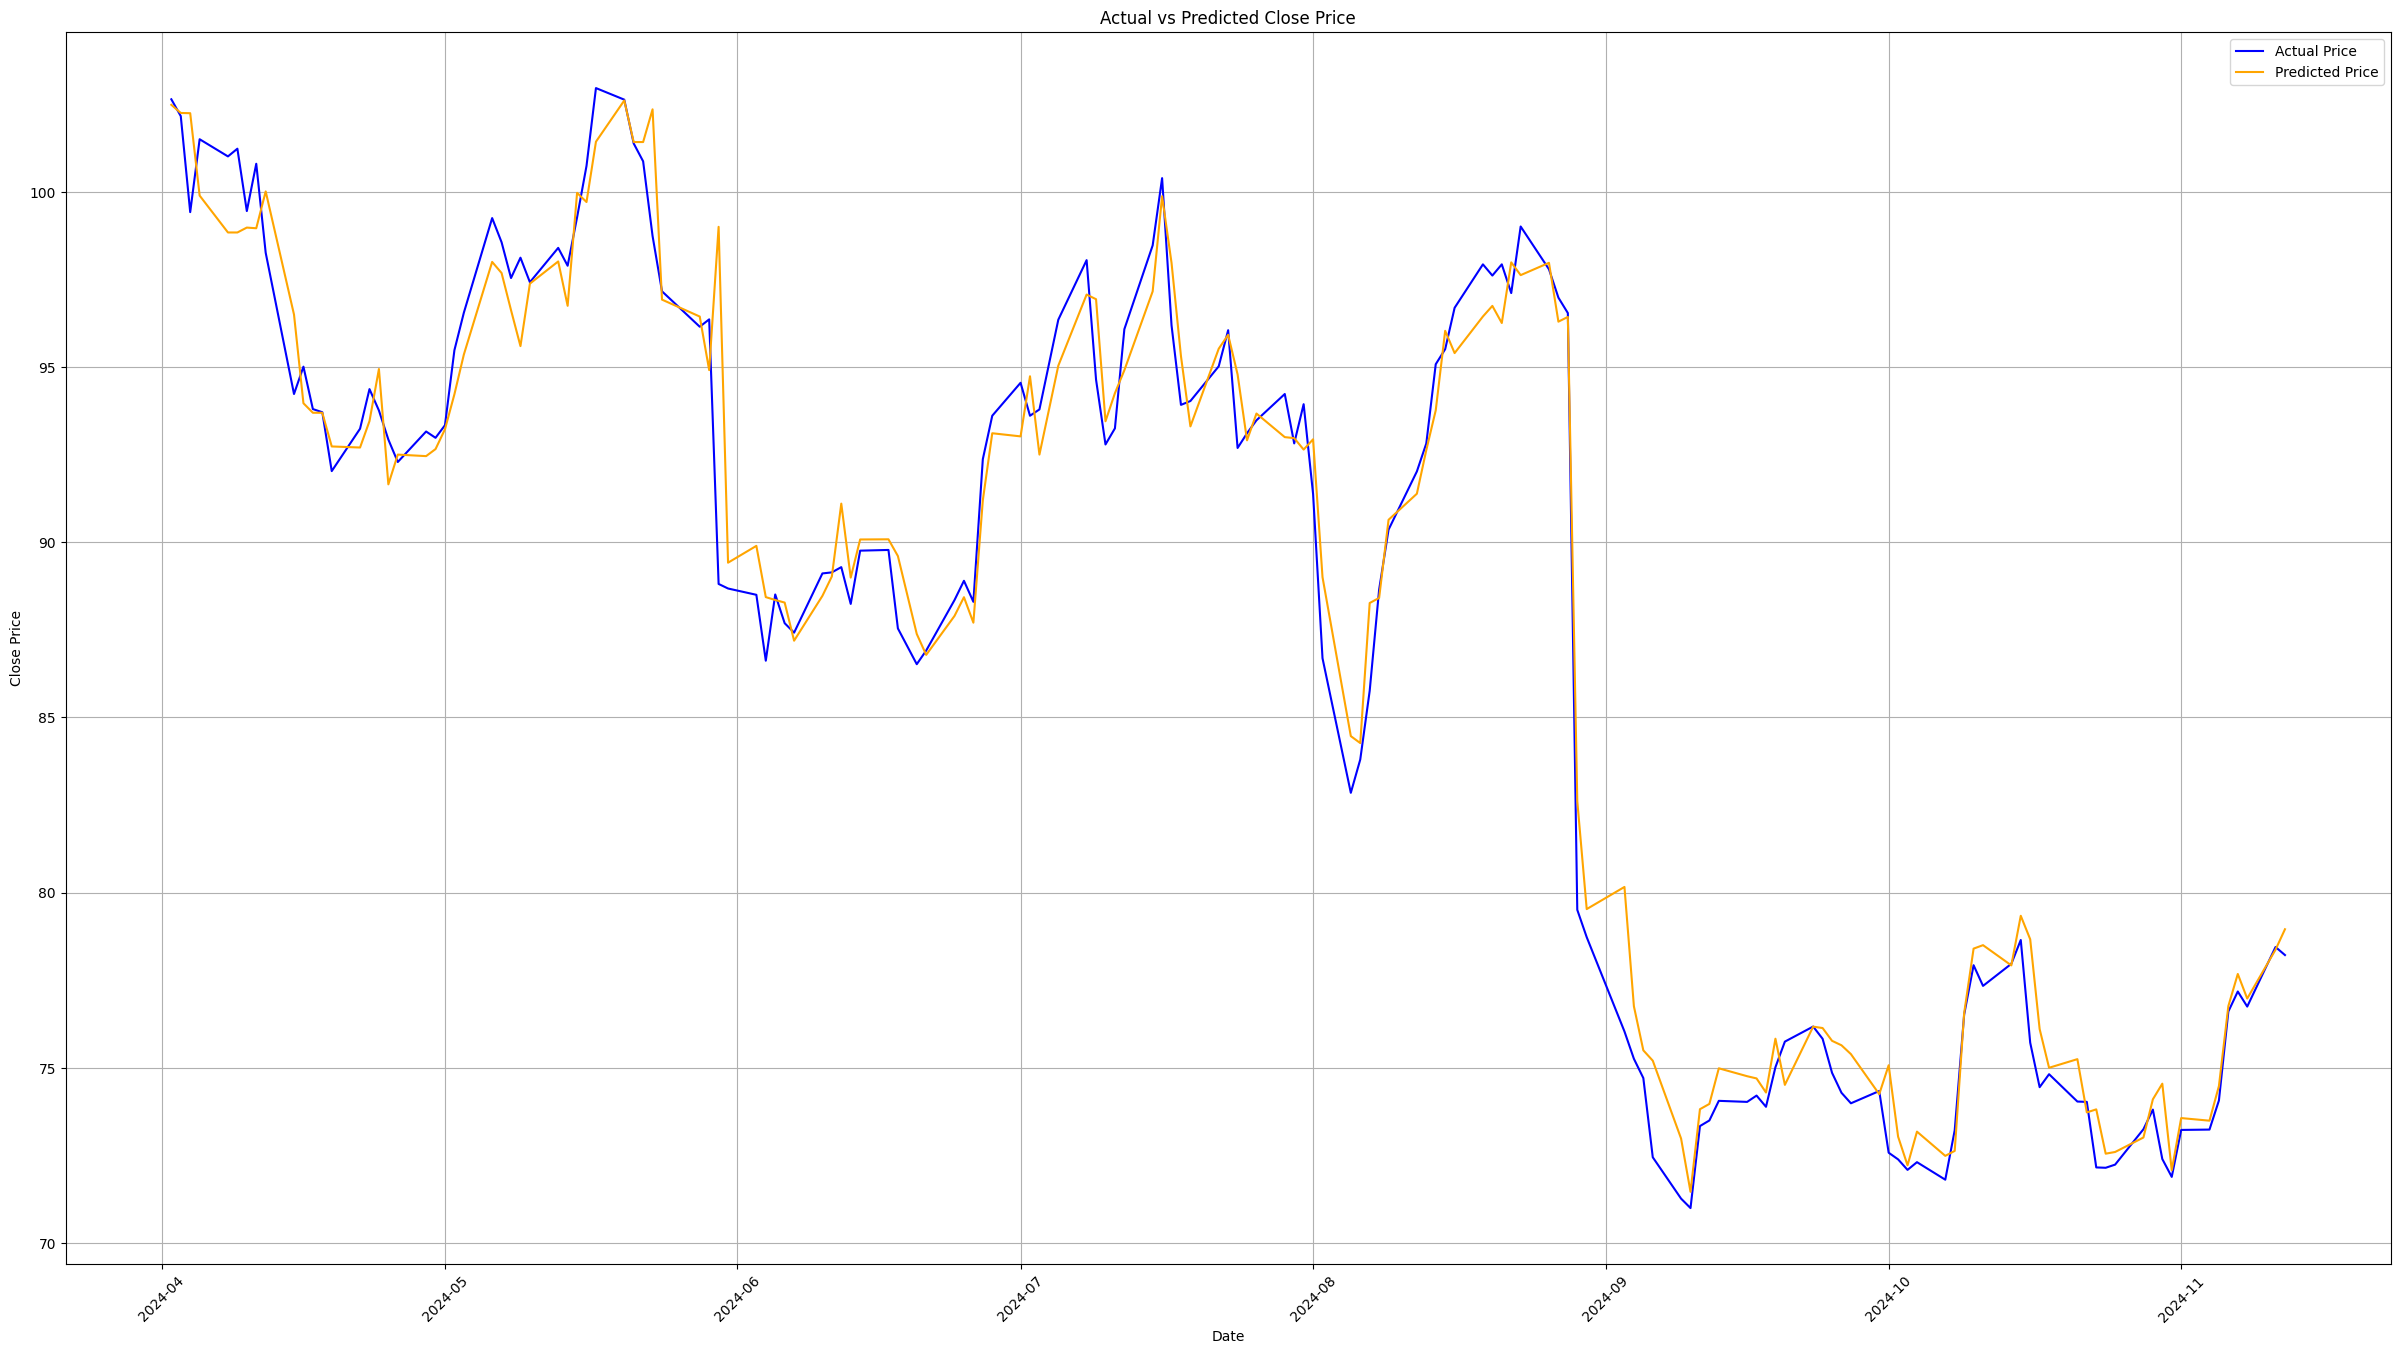

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = 

Error for DOCU: Found input variables with inconsistent numbers of samples: [157, 131]

Company: CDNS
Mean Squared Error: 0.04518982891193573
Root Mean Squared Error: 0.21257899452188528
R-squared: 0.9548101710880643


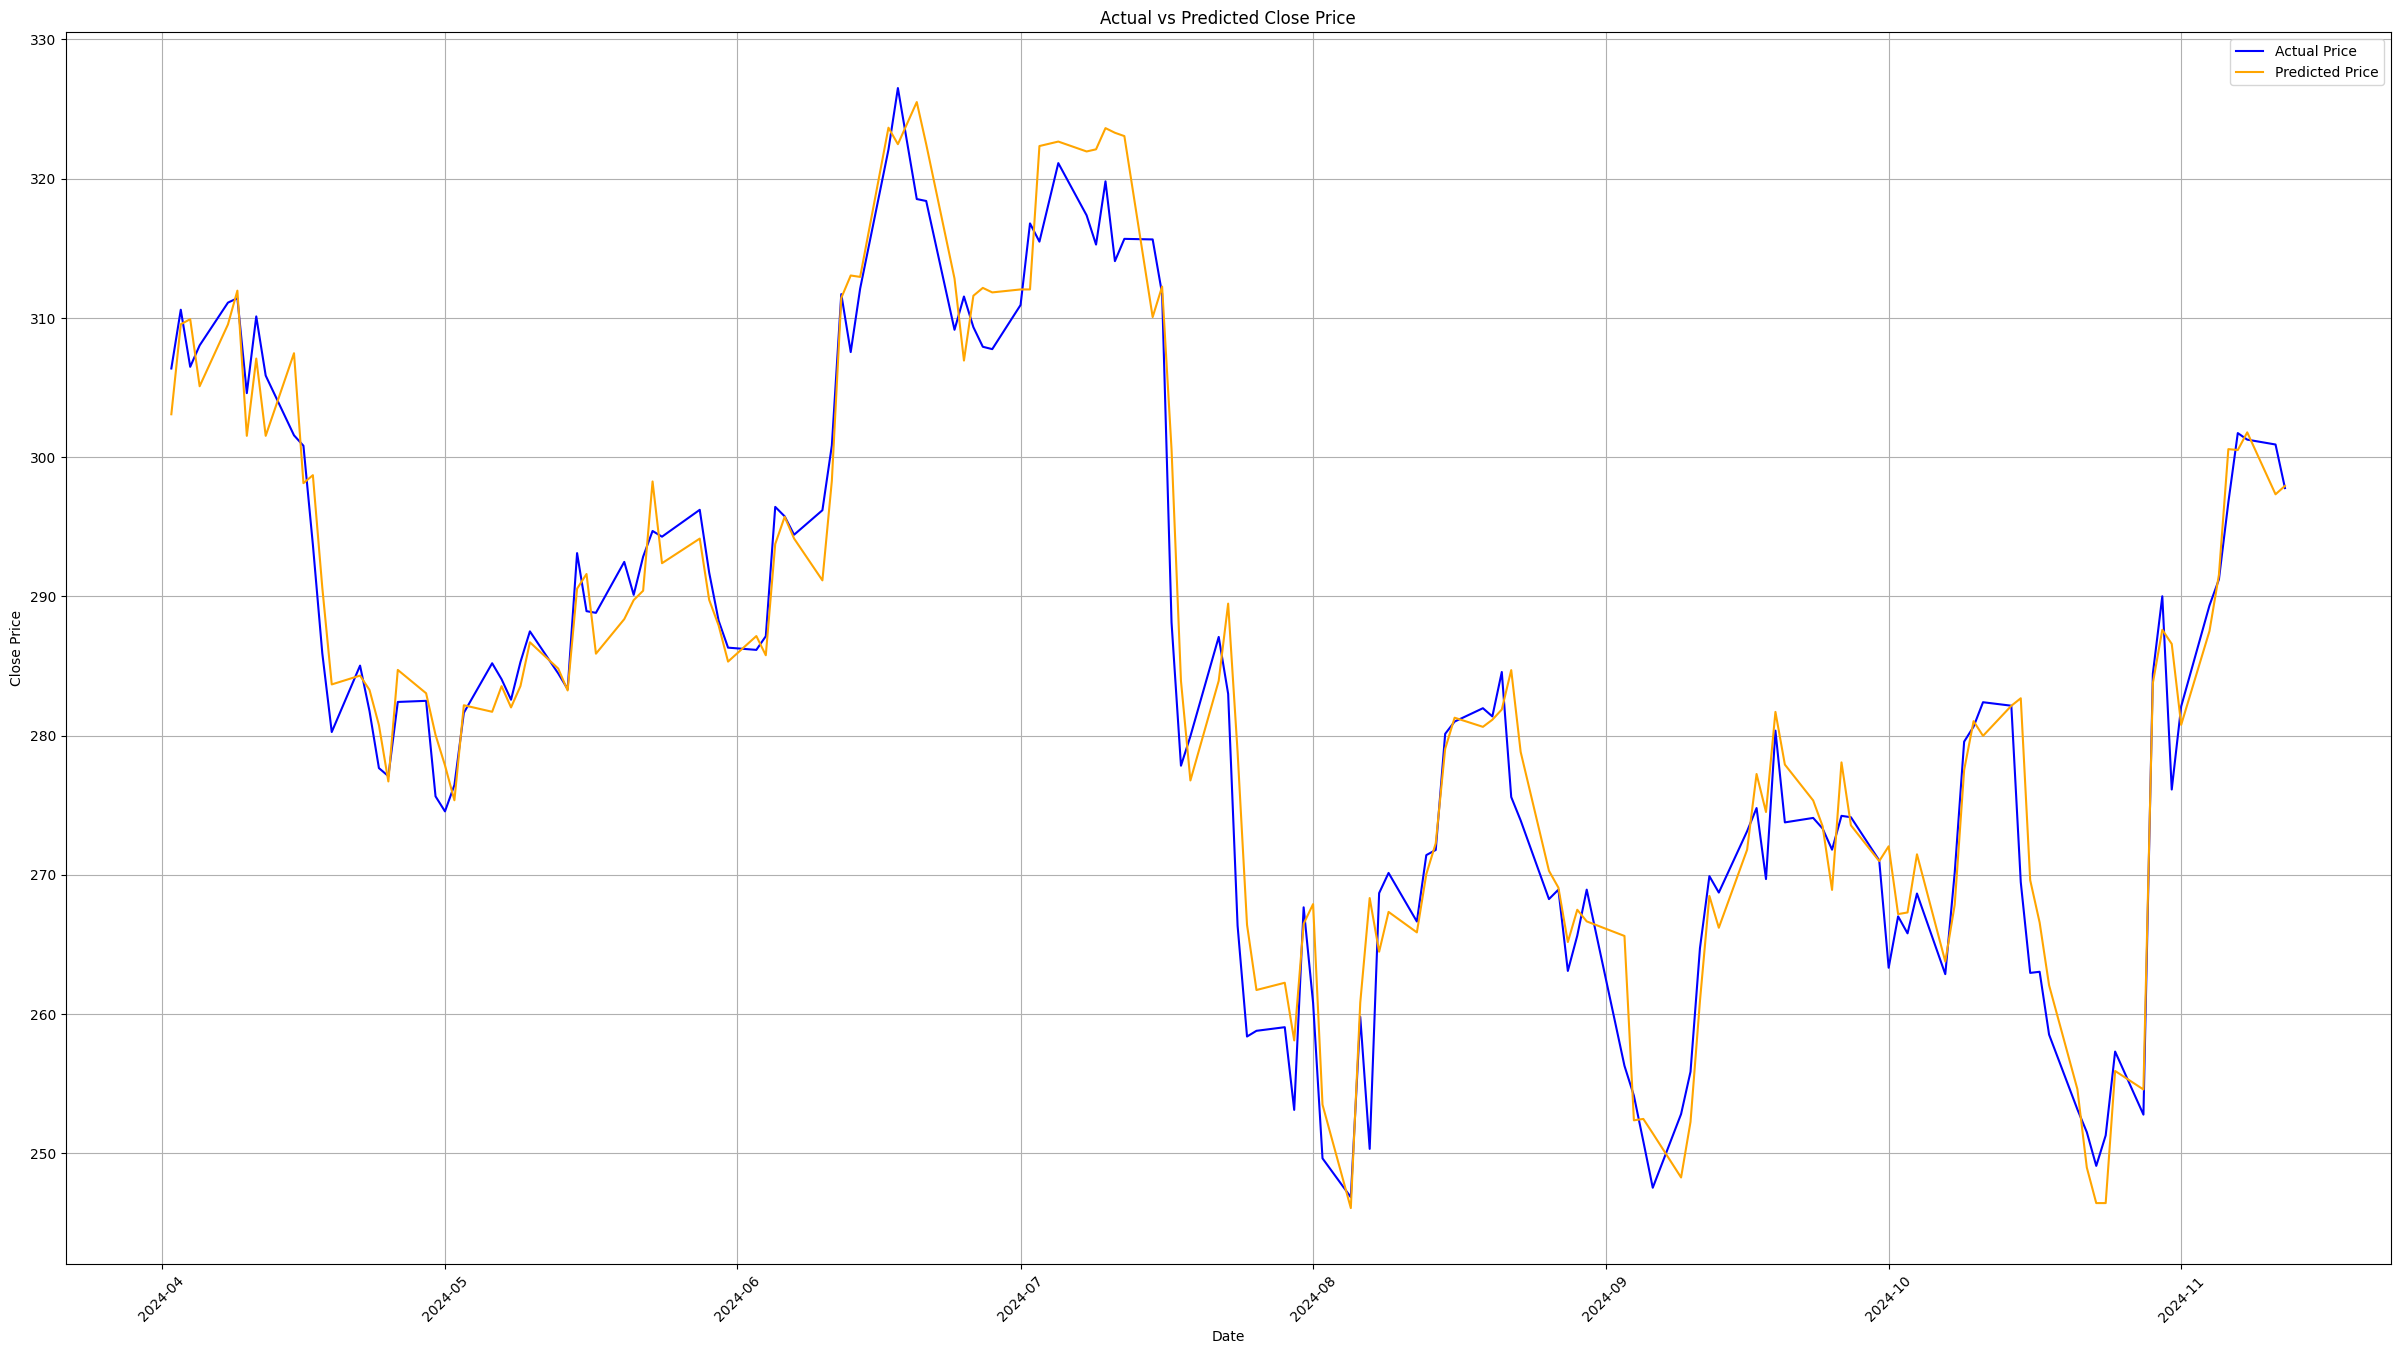

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = 

Error for ANSS: Found input variables with inconsistent numbers of samples: [157, 139]

Company: TTD
Mean Squared Error: 0.03189044547297768
Root Mean Squared Error: 0.1785789614511678
R-squared: 0.9681095545270223


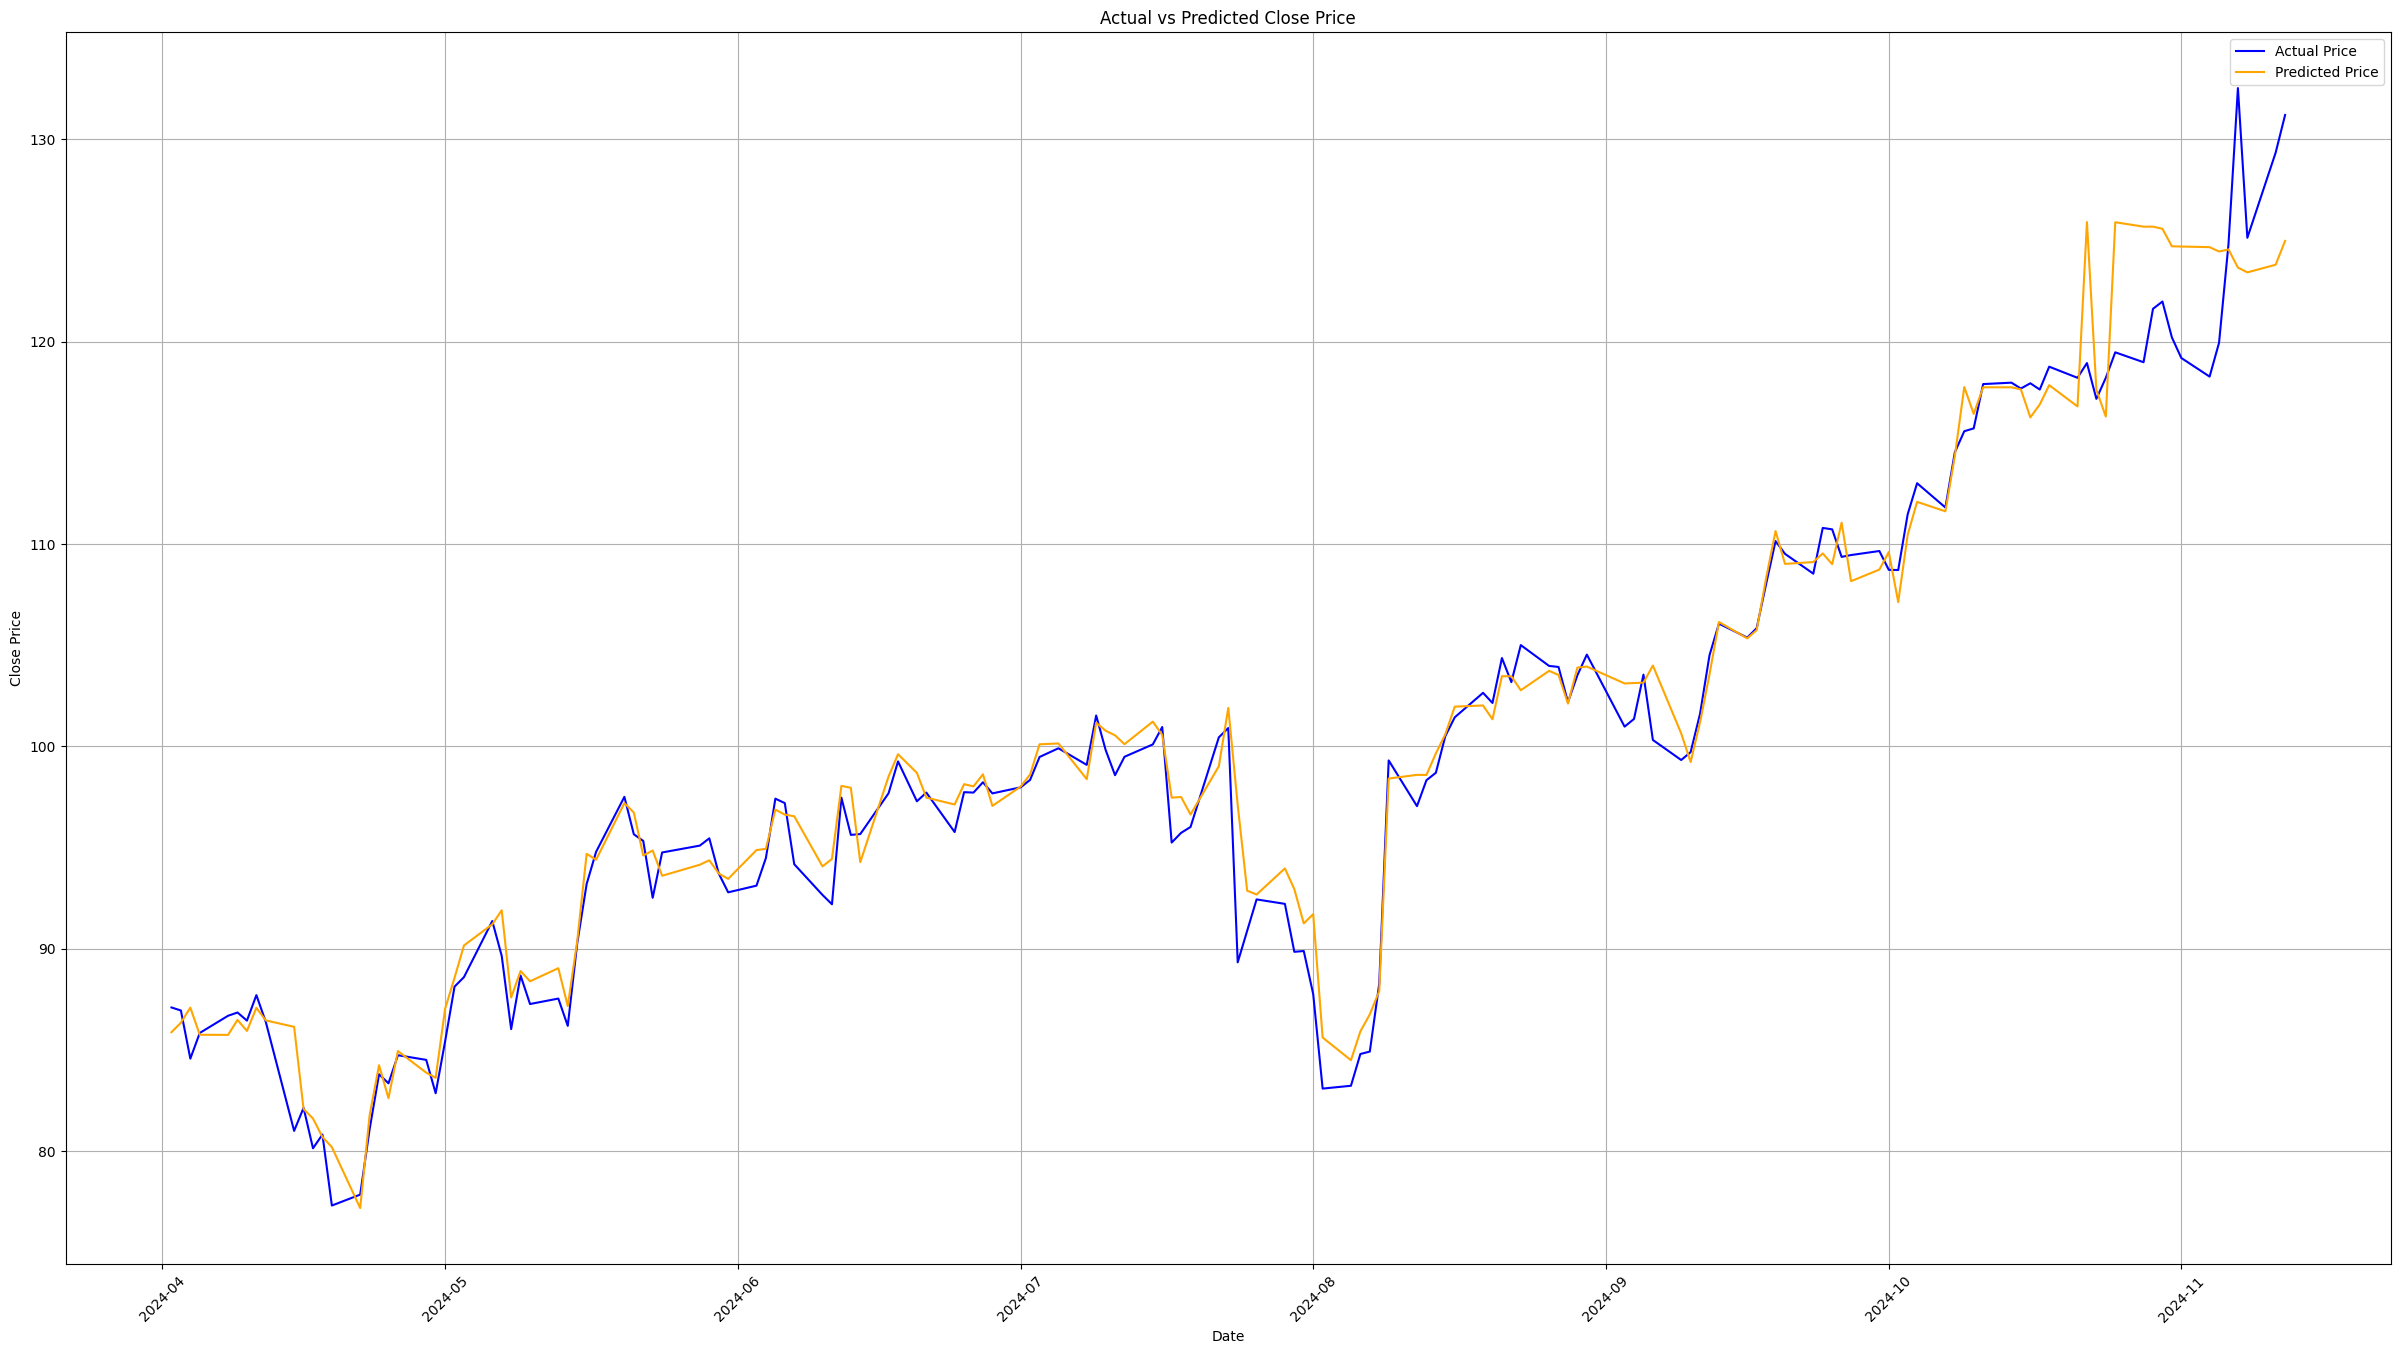

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: ICE
Mean Squared Error: 0.011270939483395262
Root Mean Squared Error: 0.10616468096026692
R-squared: 0.9887290605166047


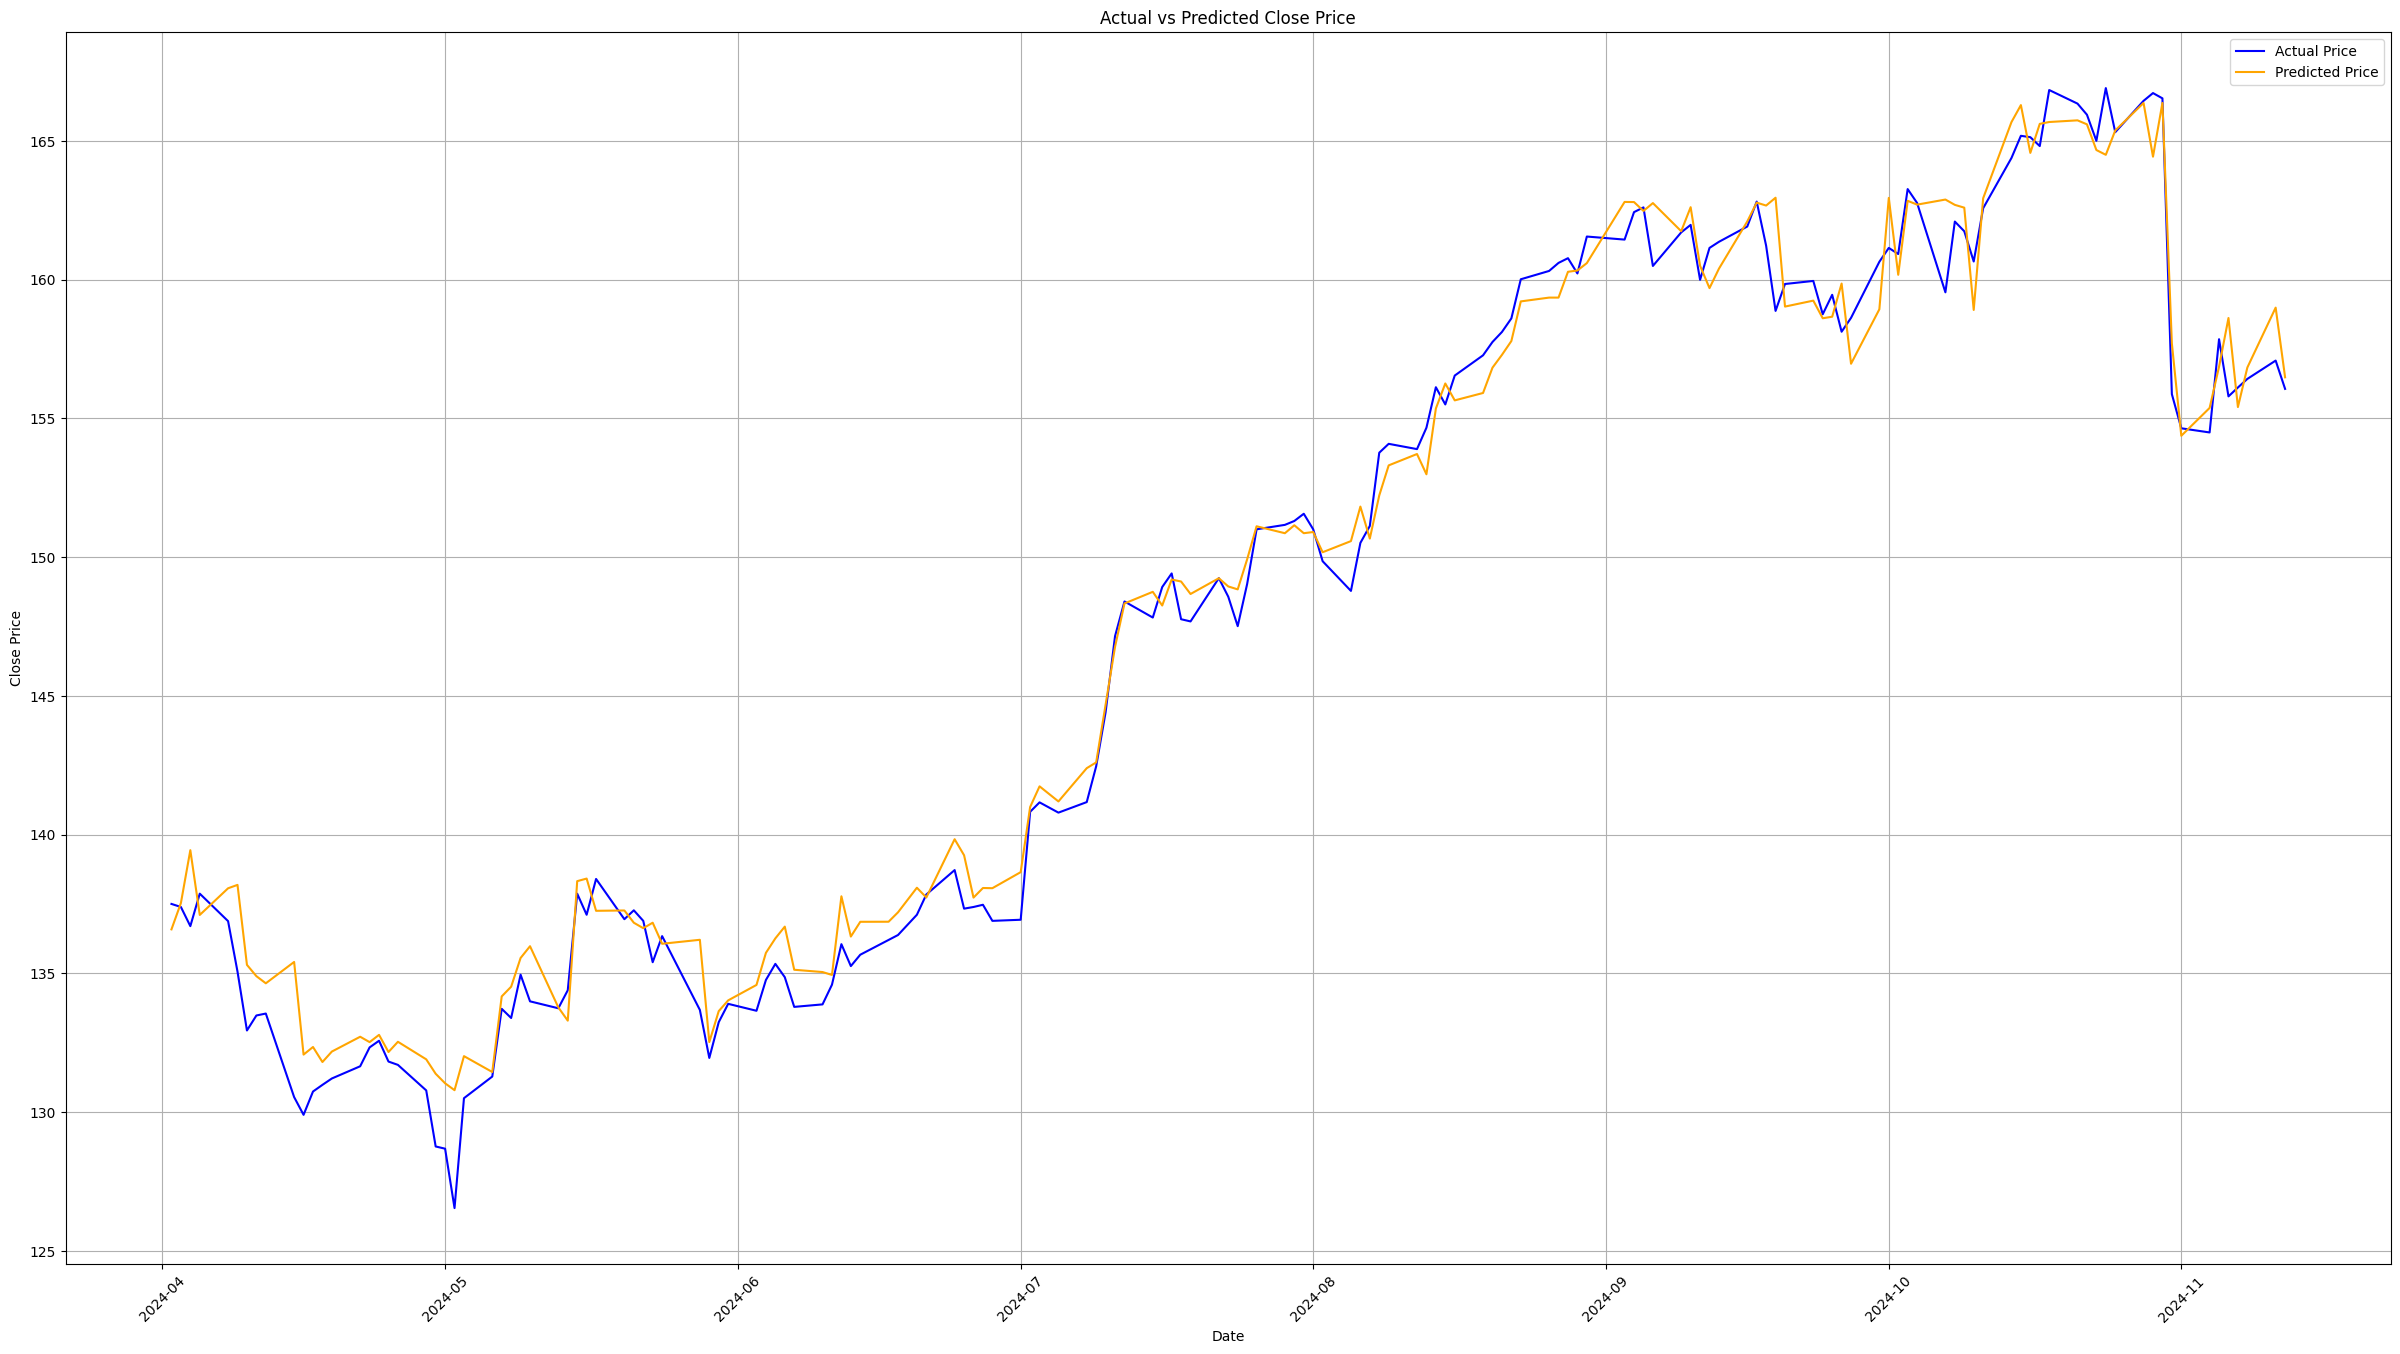

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: AJG
Mean Squared Error: 0.014524930081190915
Root Mean Squared Error: 0.12051941785949231
R-squared: 0.9854750699188091


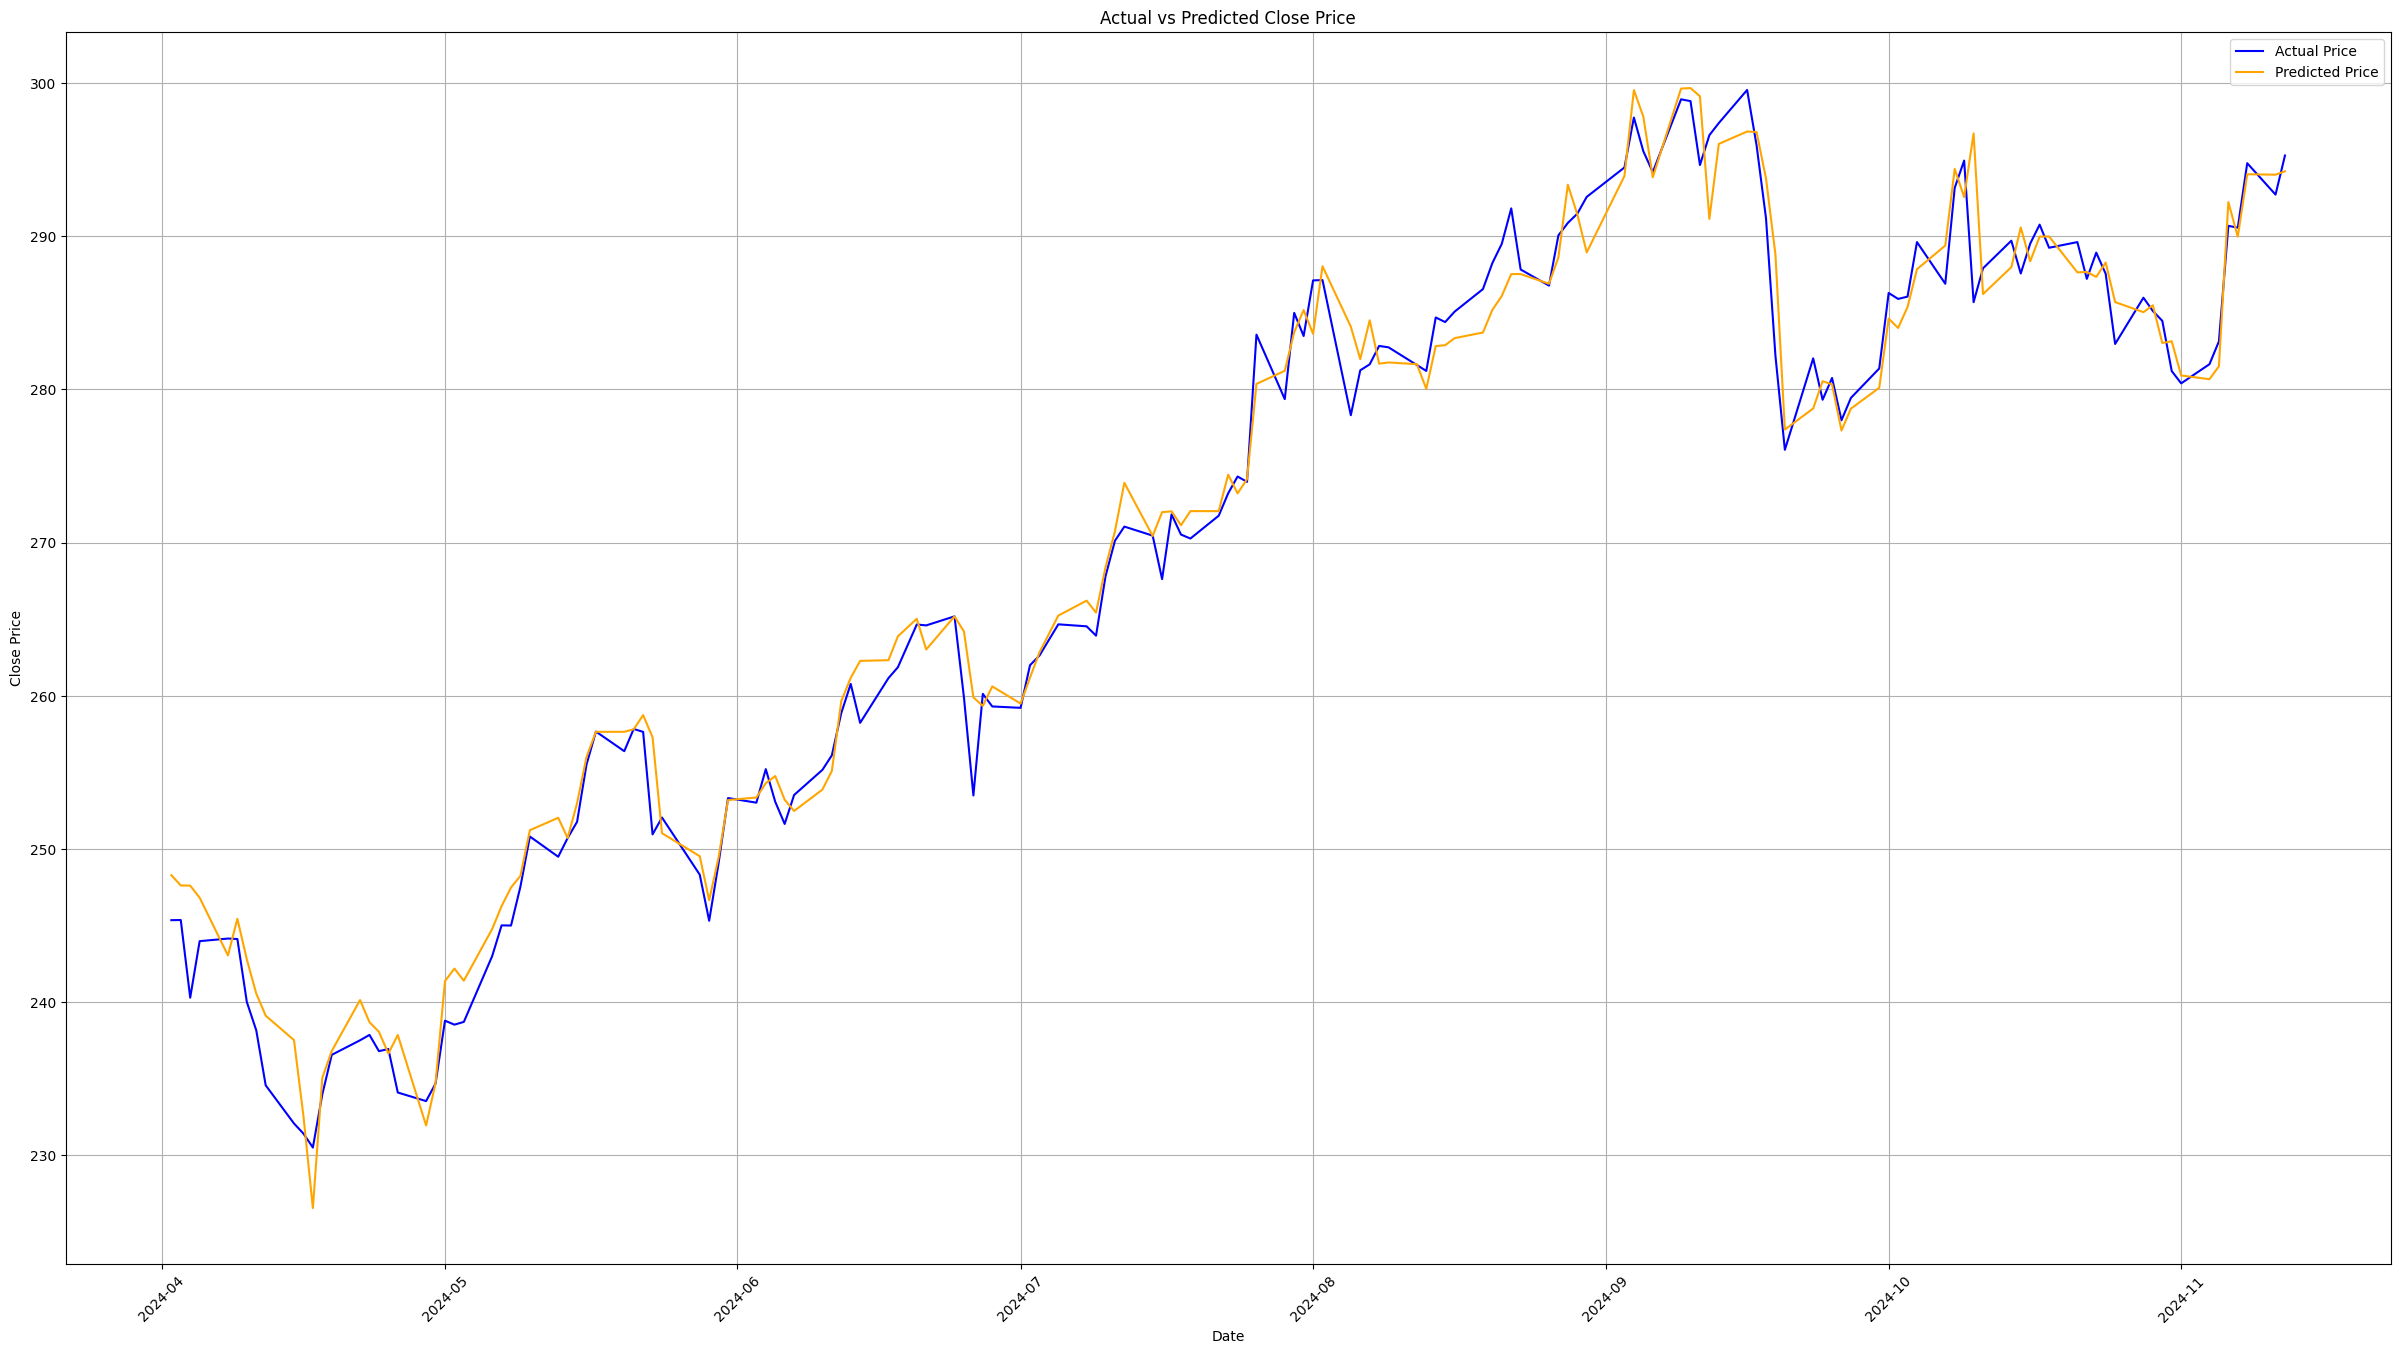

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: PGR
Mean Squared Error: 0.02707770612558969
Root Mean Squared Error: 0.16455304957851644
R-squared: 0.9729222938744103


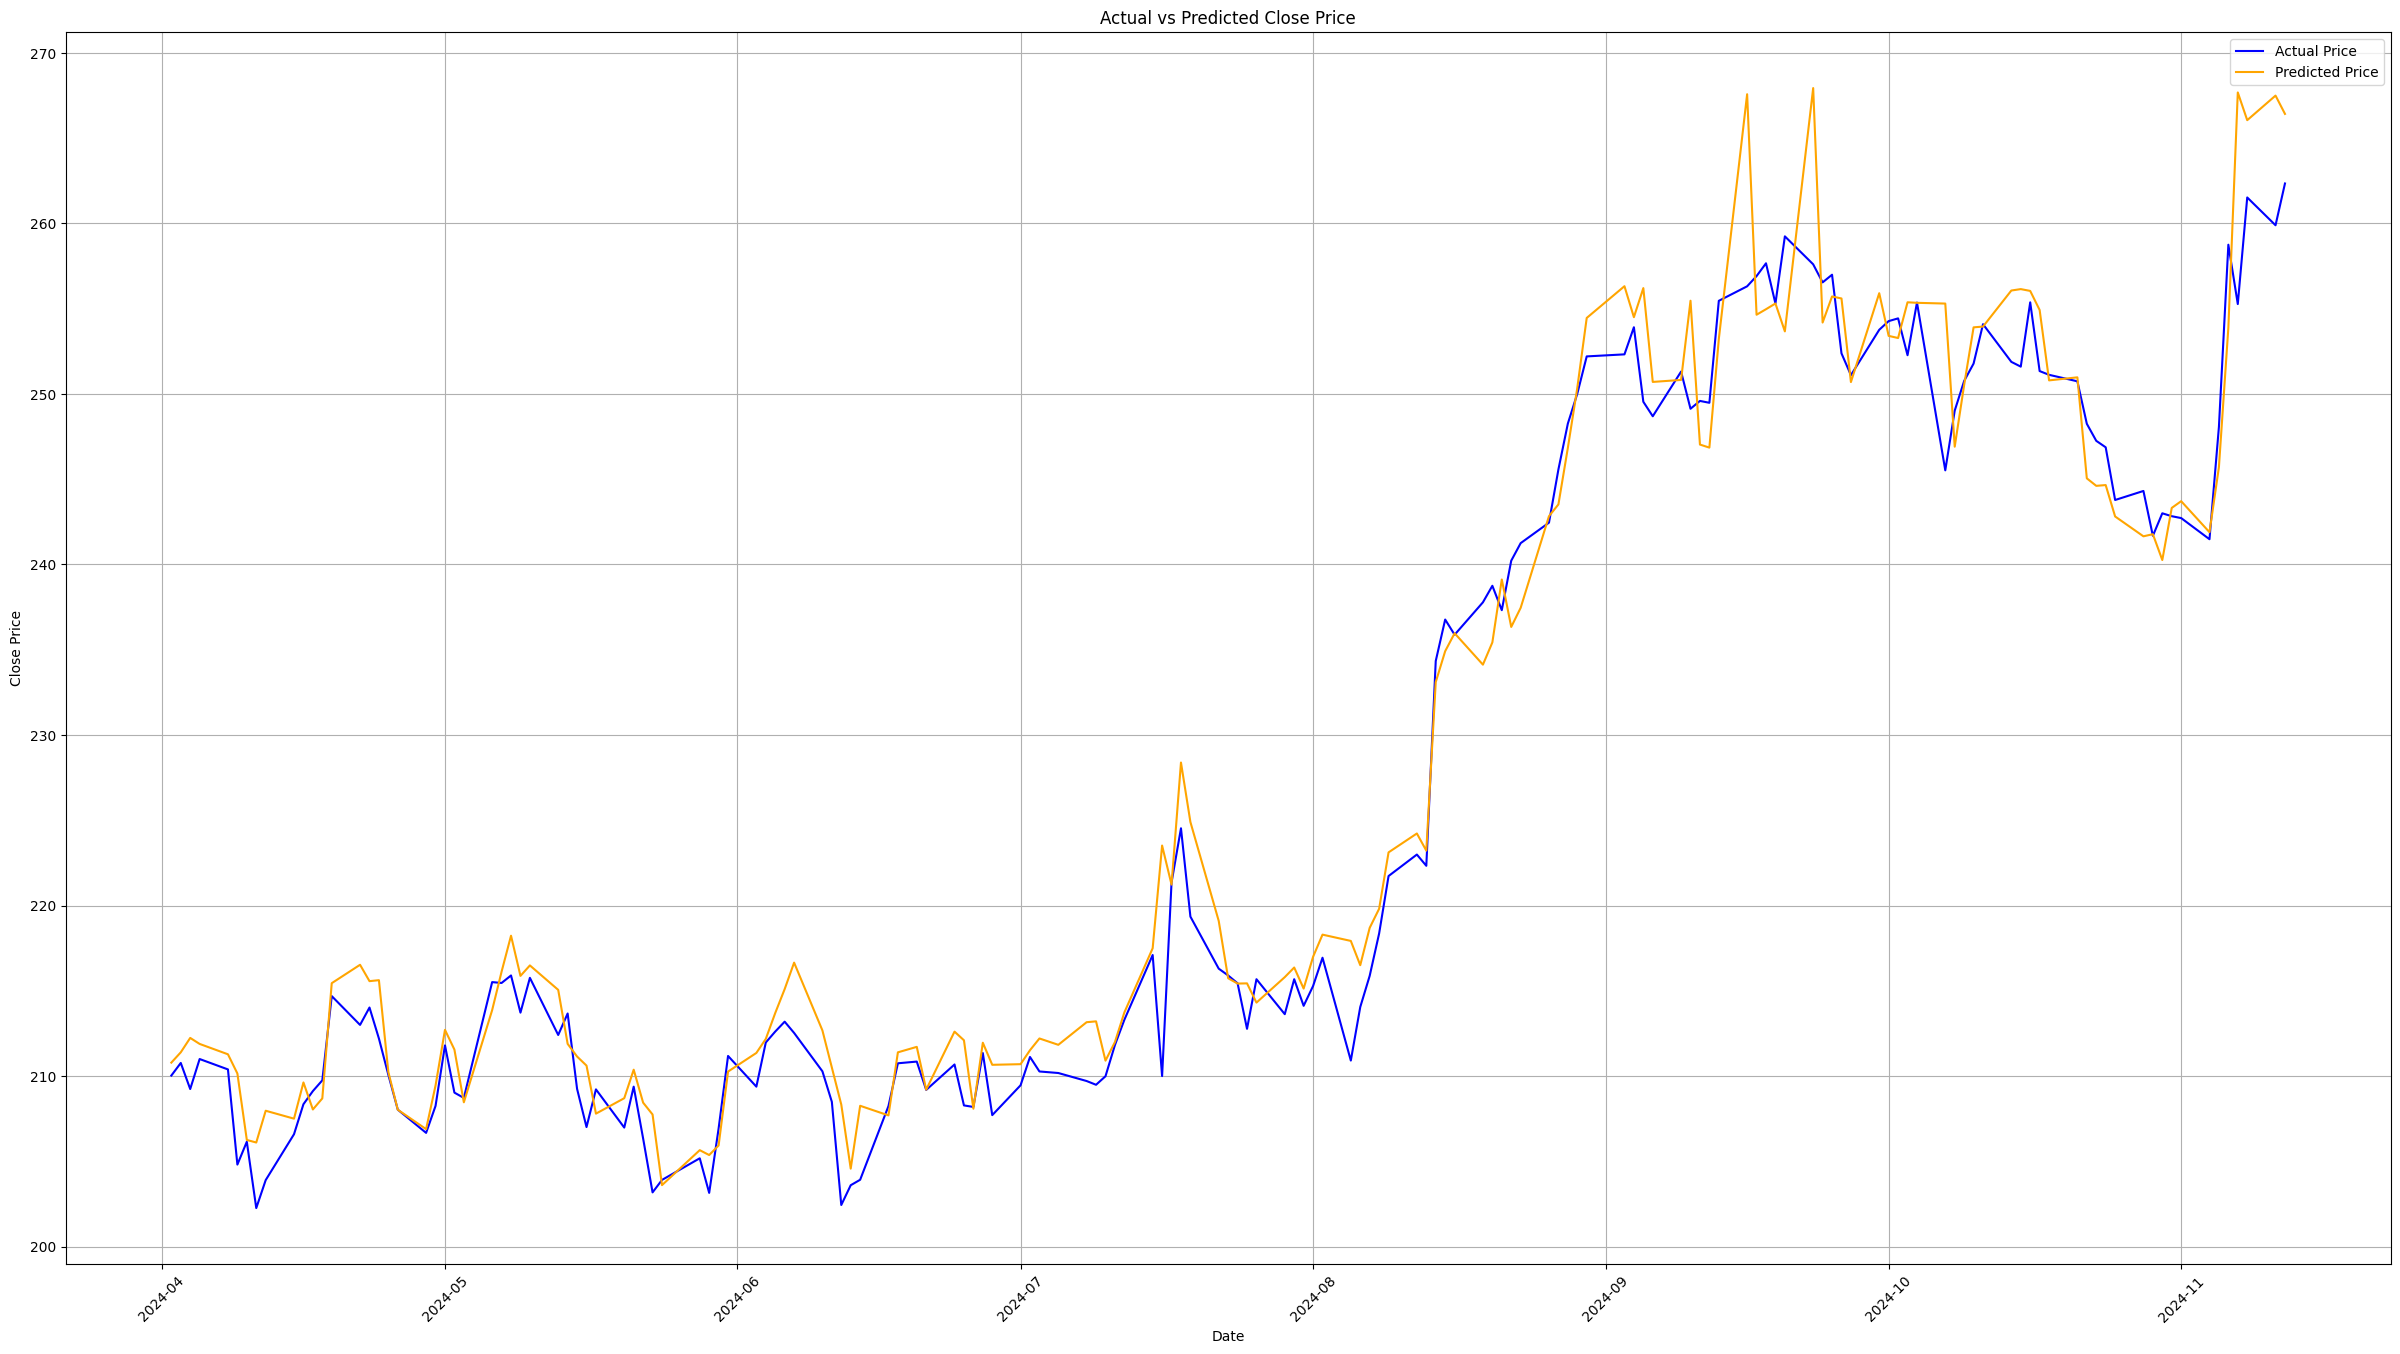

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: CINF
Mean Squared Error: 0.025518438769687332
Root Mean Squared Error: 0.15974491782115427
R-squared: 0.9744815612303127


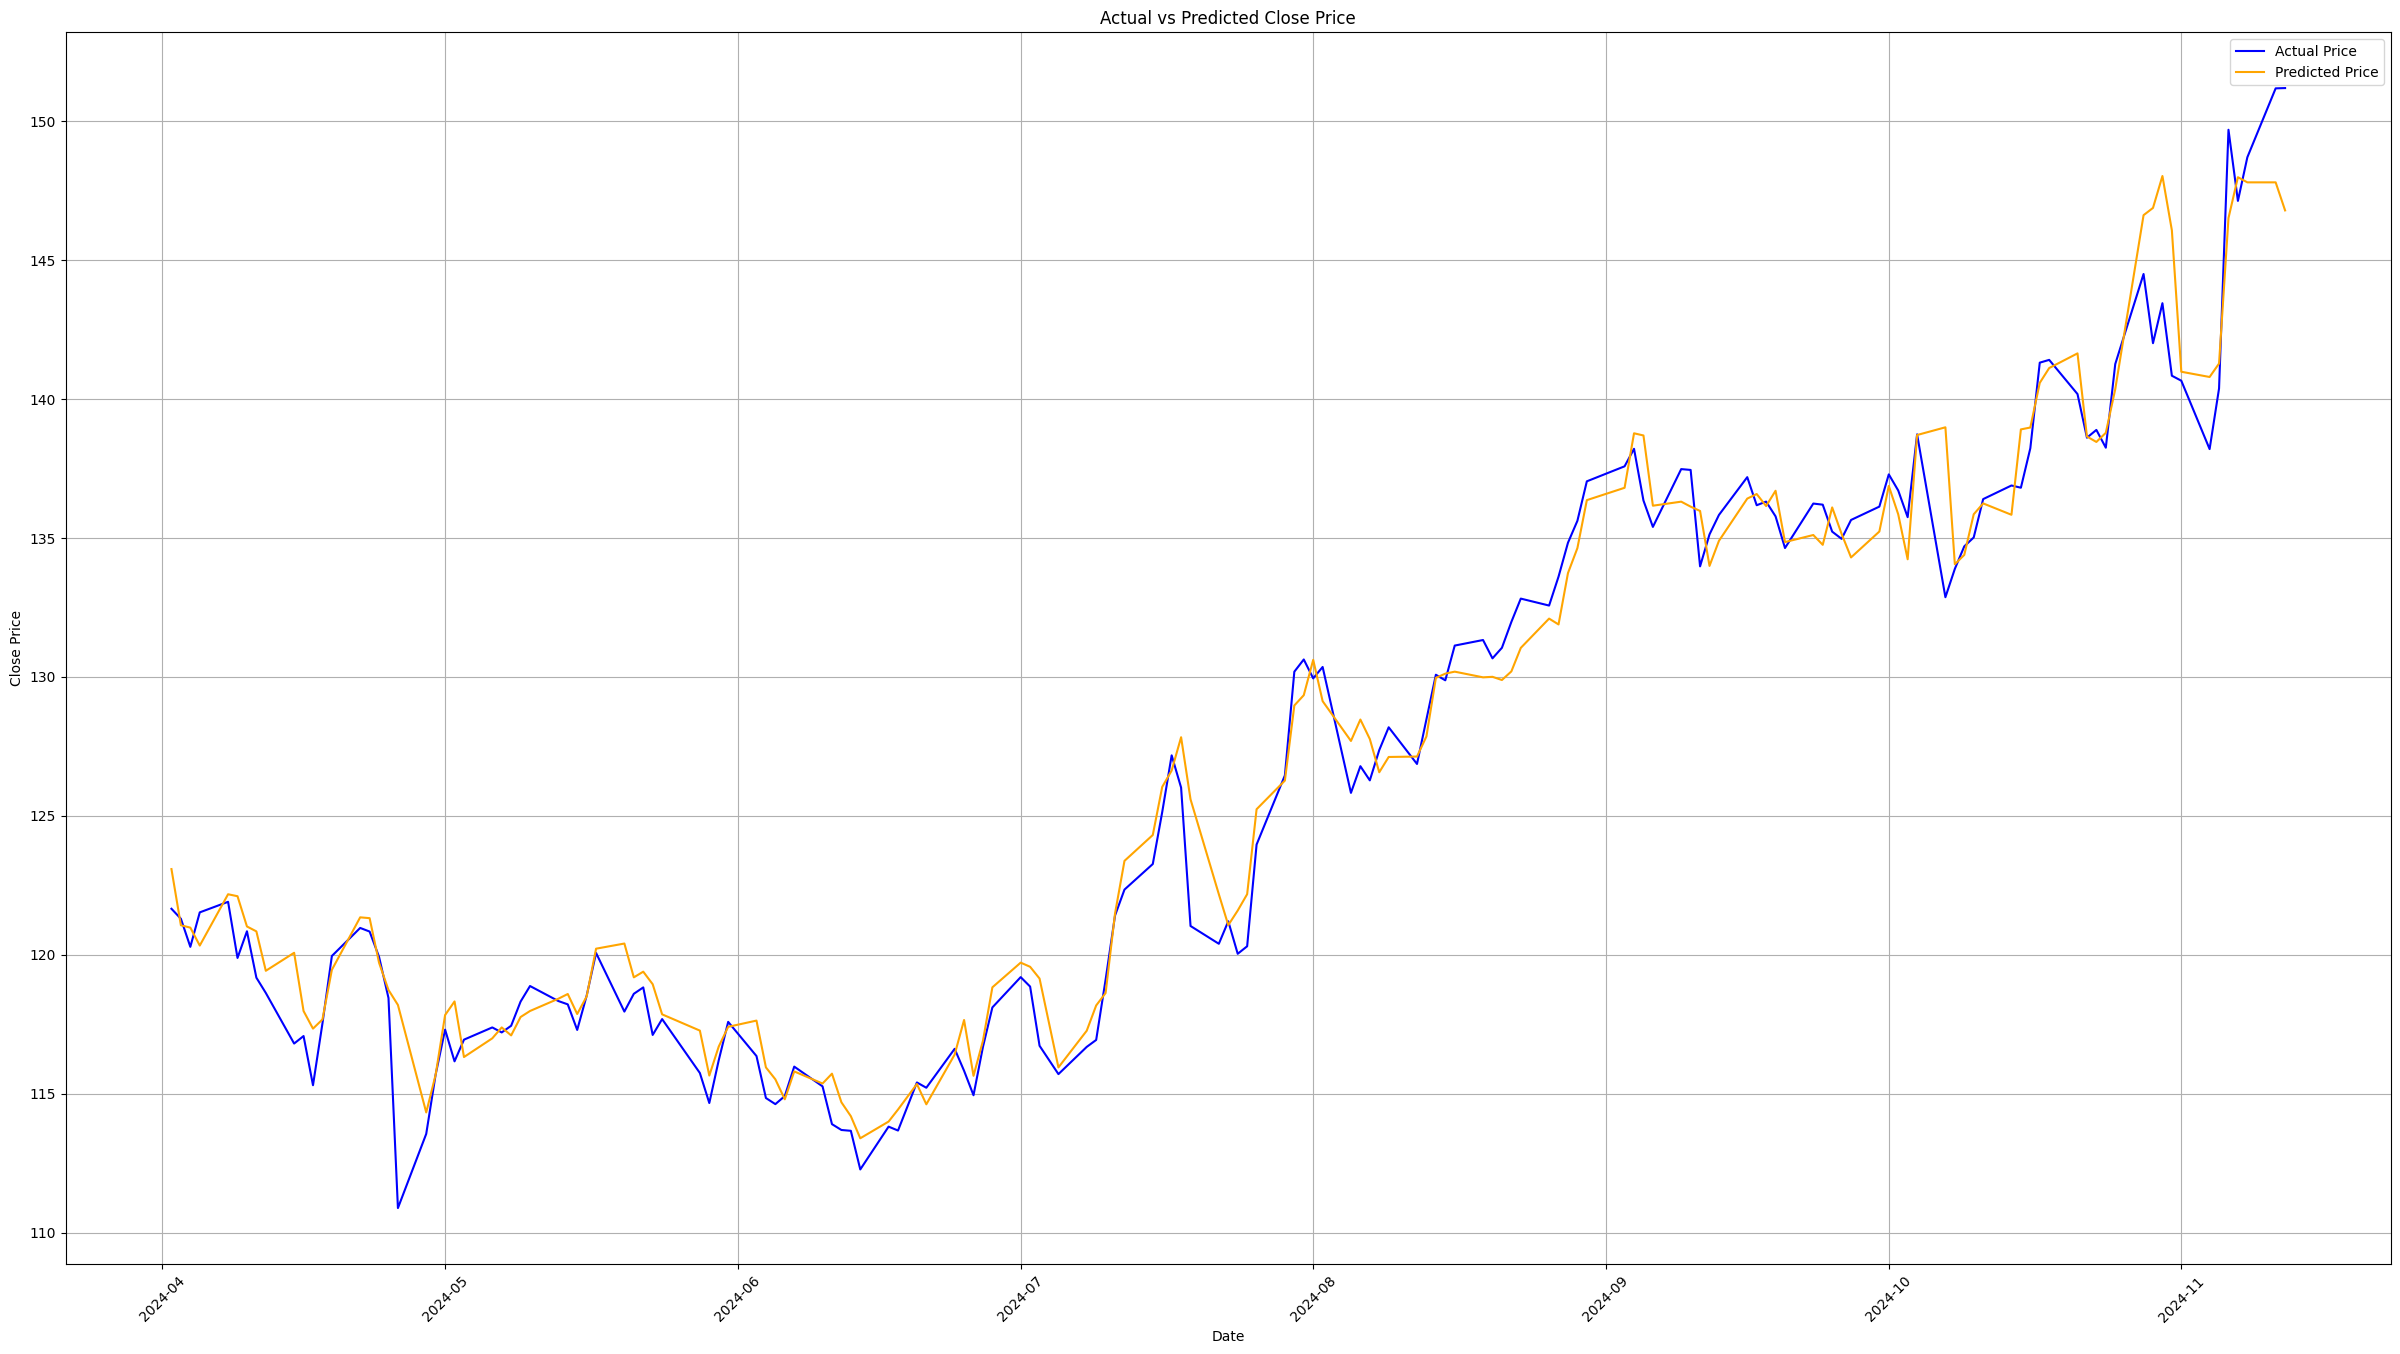

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: ALL
Mean Squared Error: 0.033117479662634126
Root Mean Squared Error: 0.18198208610364408
R-squared: 0.9668825203373659


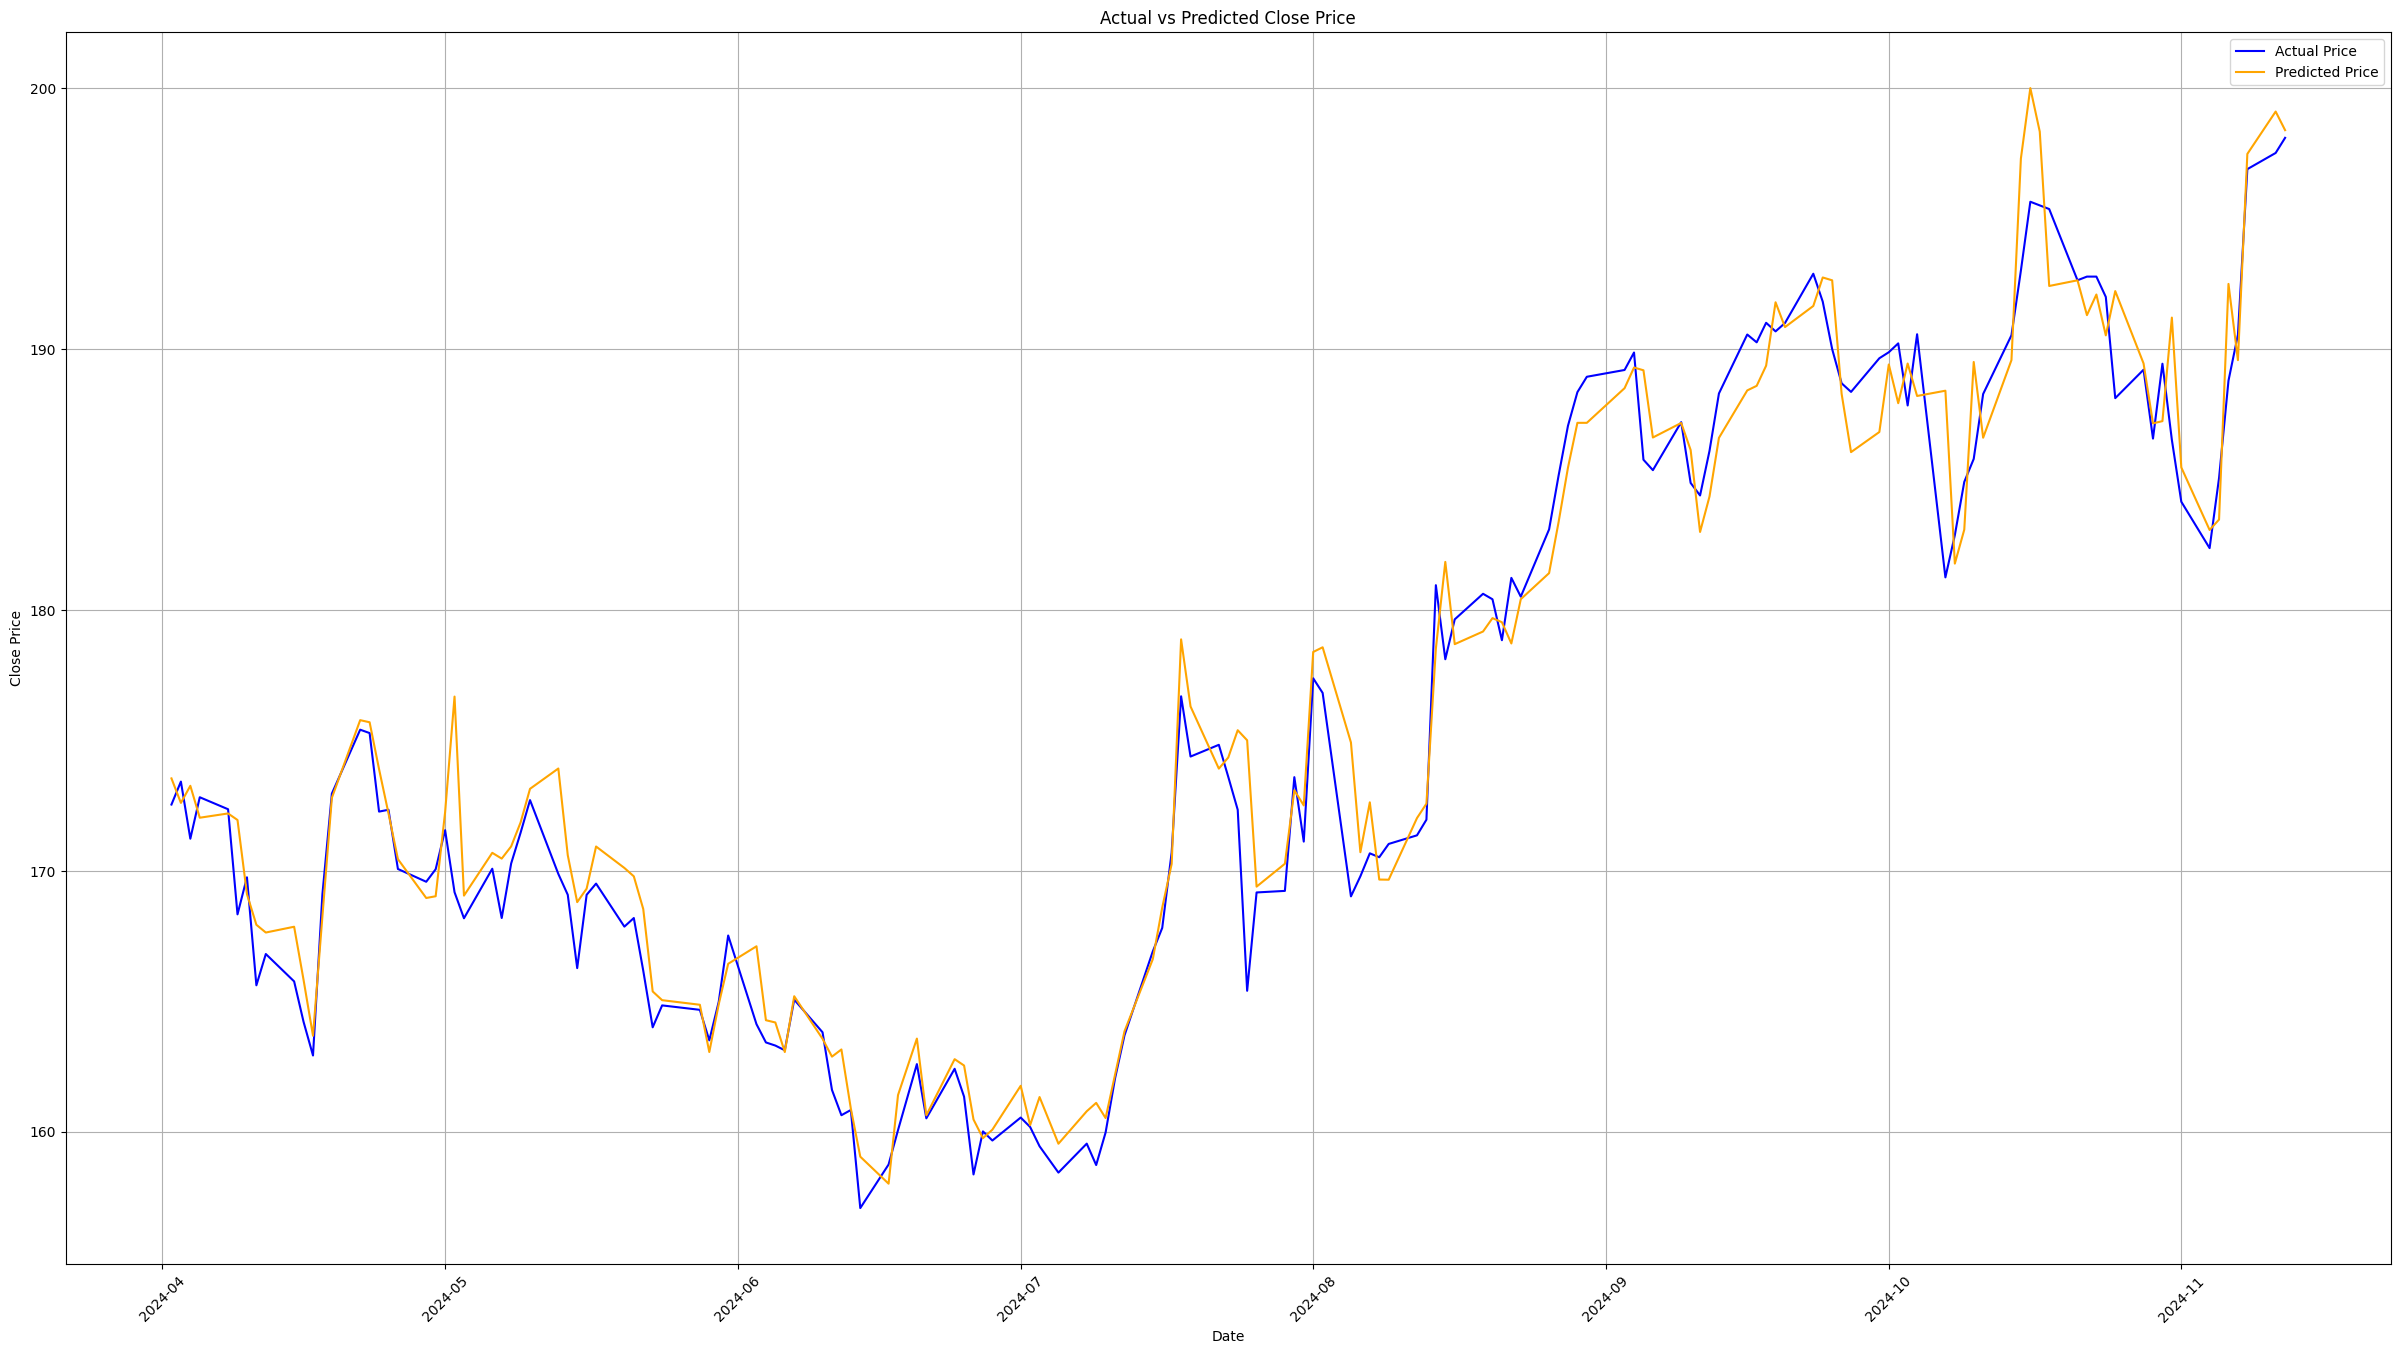

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: HES
Mean Squared Error: 0.027989342729825038
Root Mean Squared Error: 0.1673001575905565
R-squared: 0.972010657270175


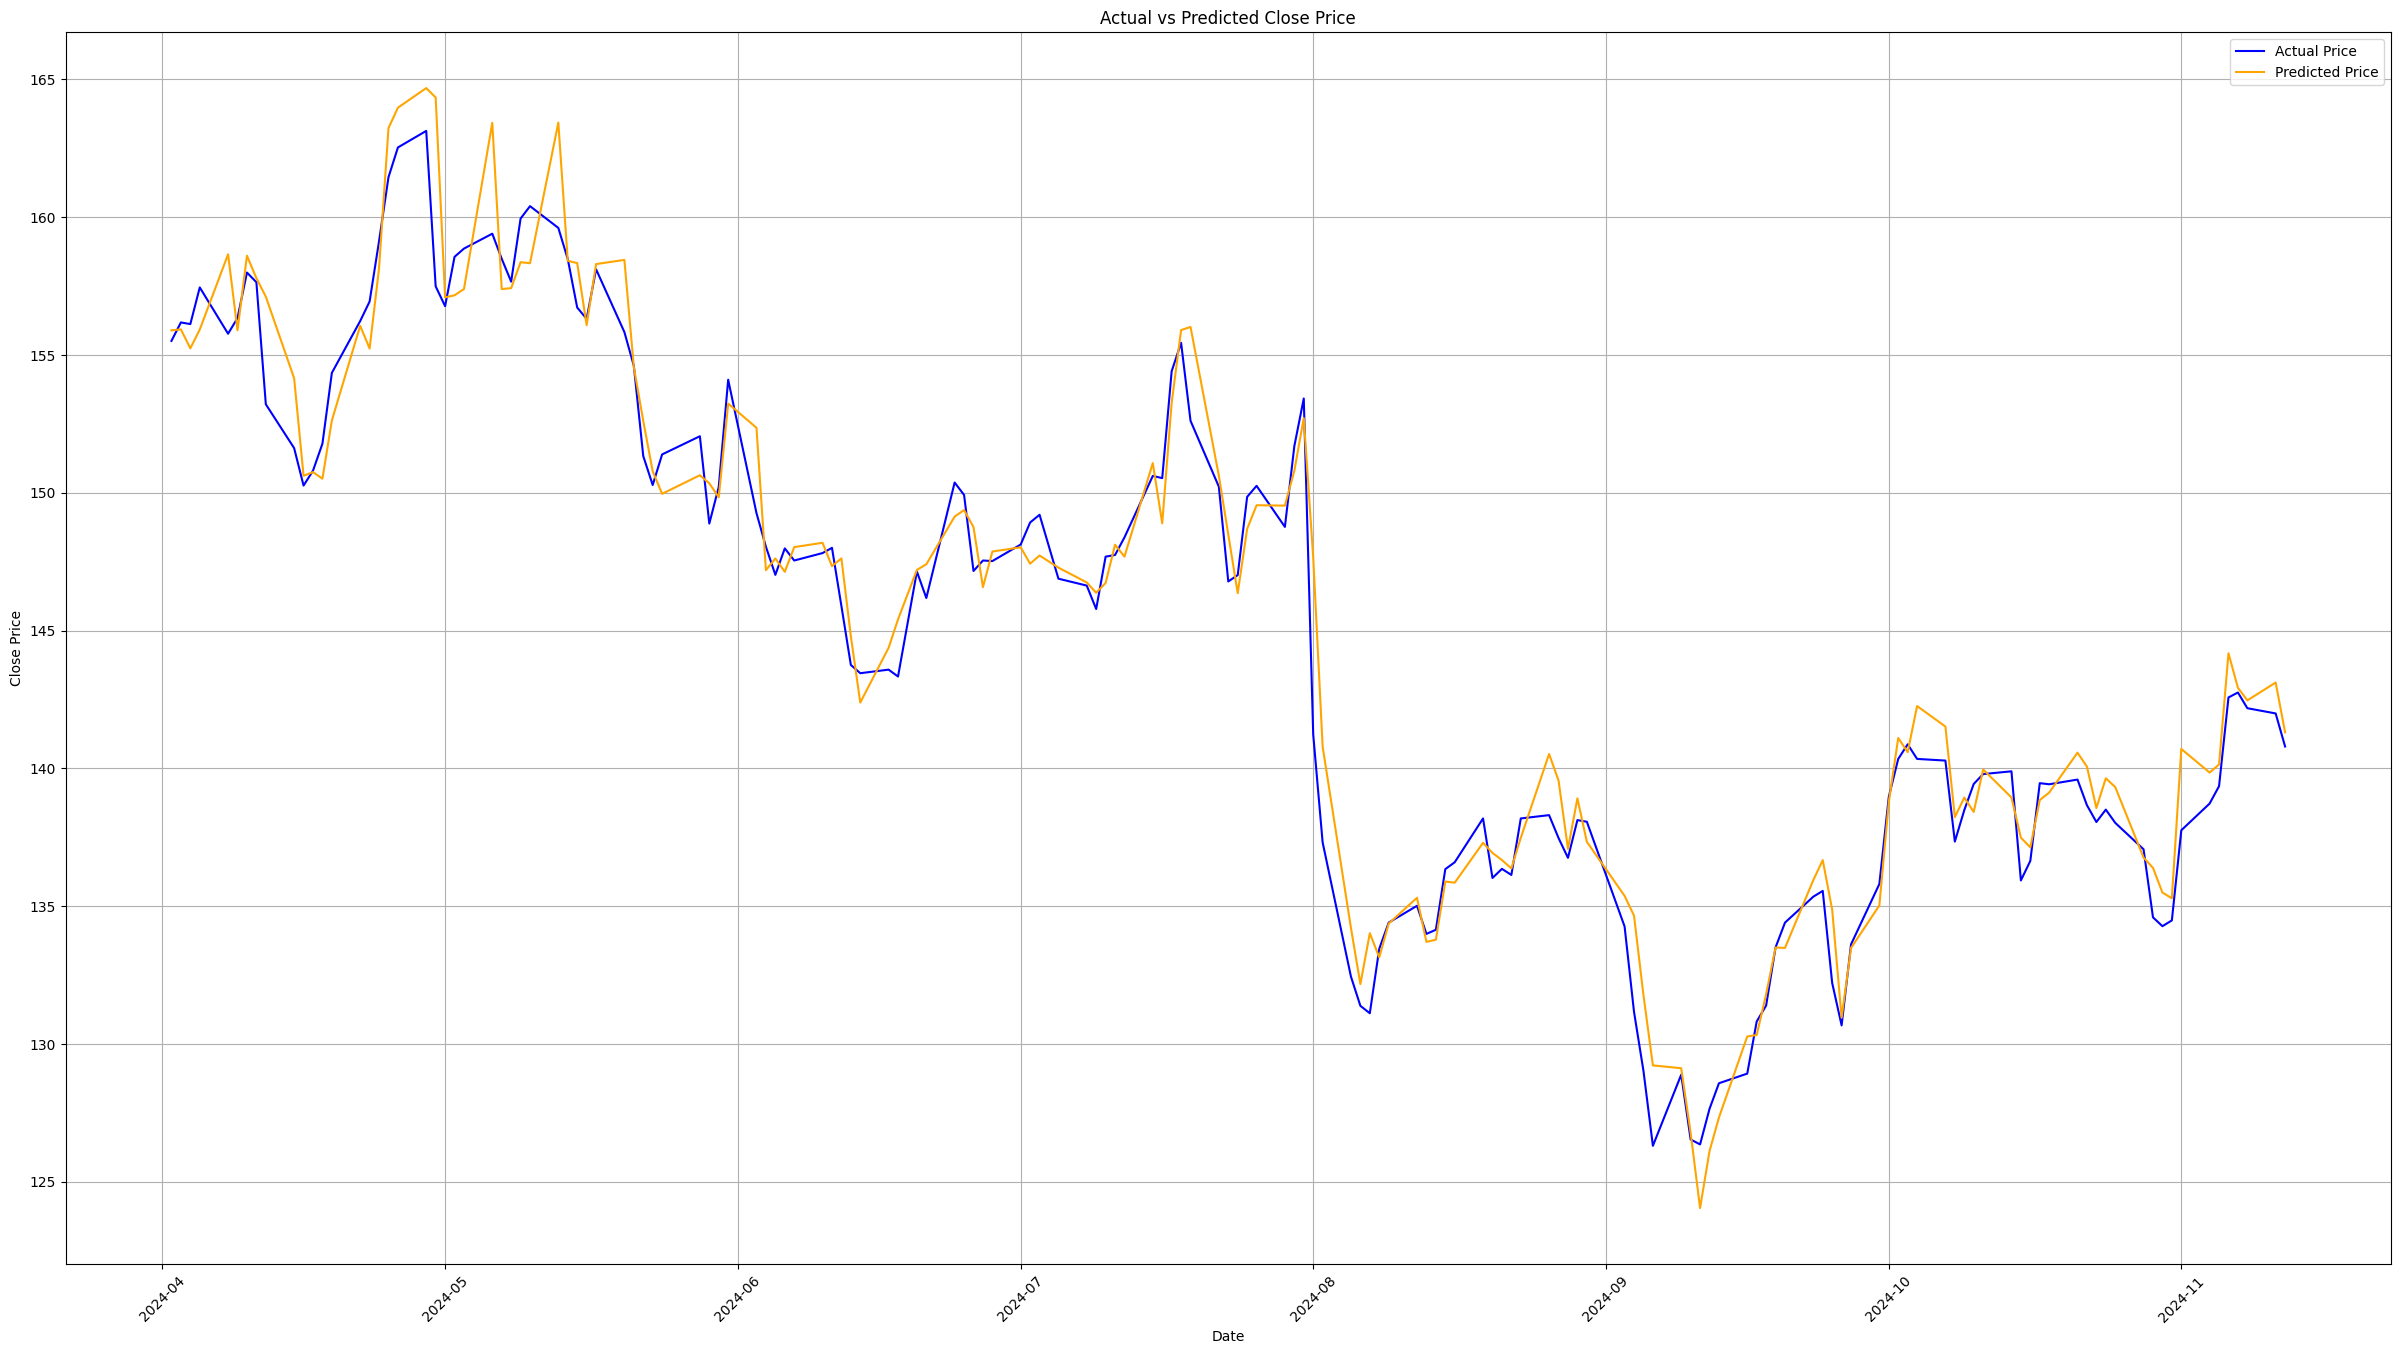

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values


Error for MPC: Found input variables with inconsistent numbers of samples: [157, 131]


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CLR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values


Error for CLR: 'NoneType' object has no attribute 'iloc'
Error for FTI: Found input variables with inconsistent numbers of samples: [157, 143]


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = 

Error for WMB: Found input variables with inconsistent numbers of samples: [157, 137]

Company: ES
Mean Squared Error: 0.025240532655324676
Root Mean Squared Error: 0.1588726932336853
R-squared: 0.9747594673446753


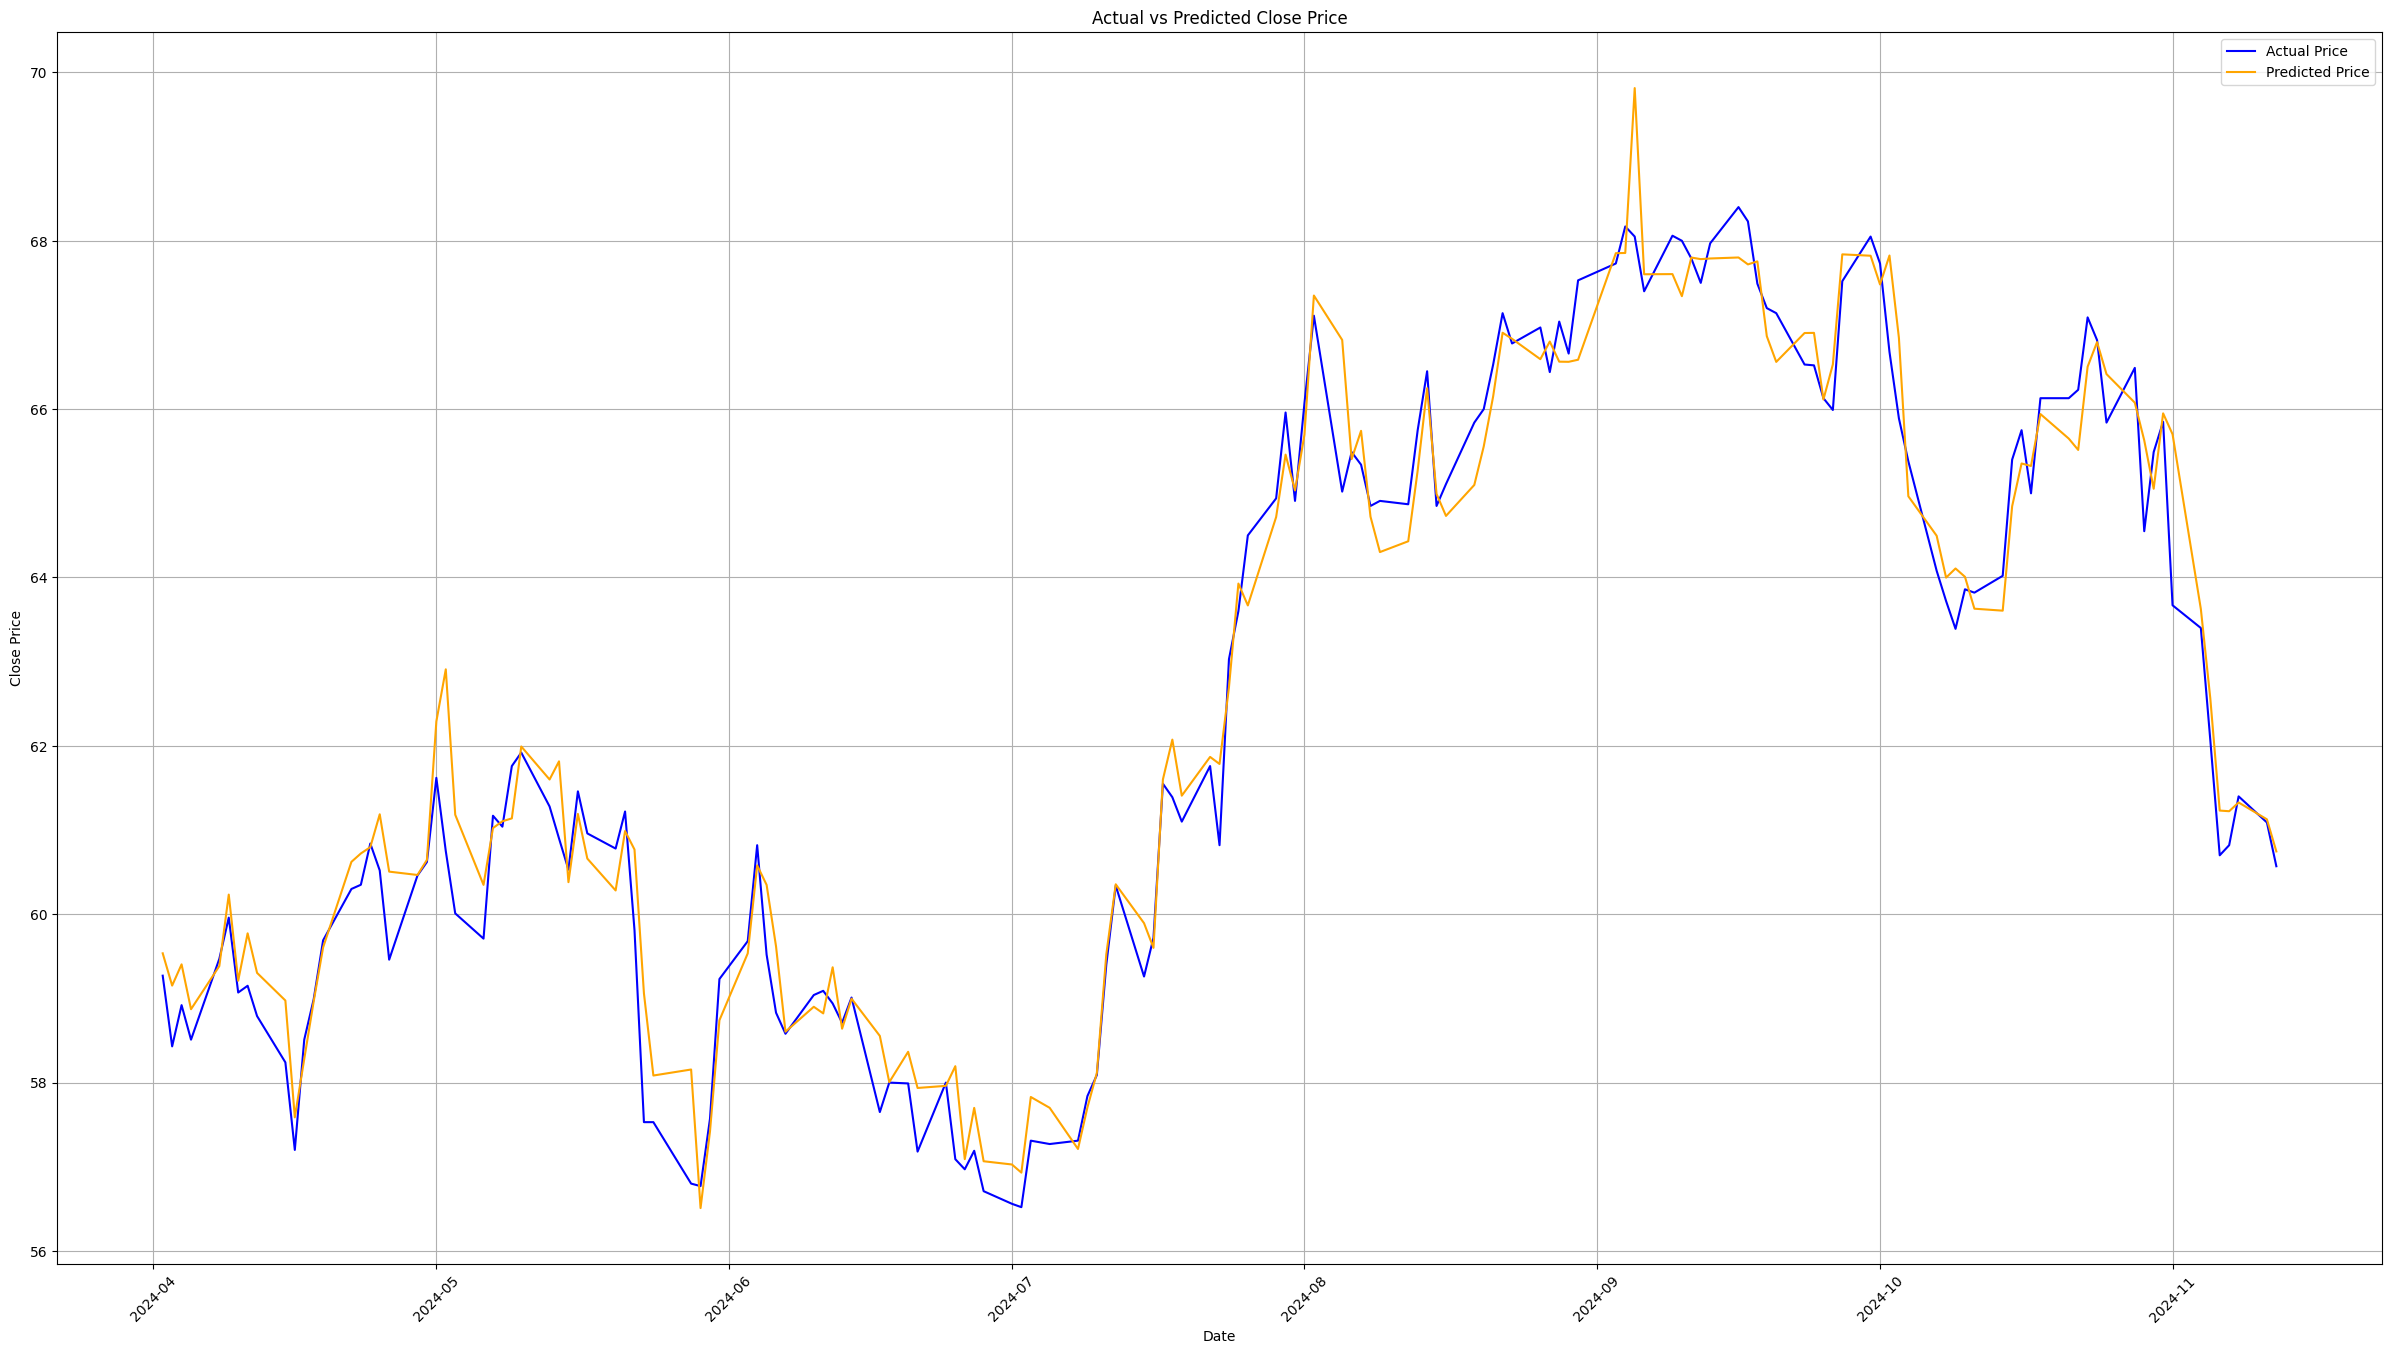

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: XEL
Mean Squared Error: 0.0181536126870519
Root Mean Squared Error: 0.13473534312514998
R-squared: 0.9818463873129482


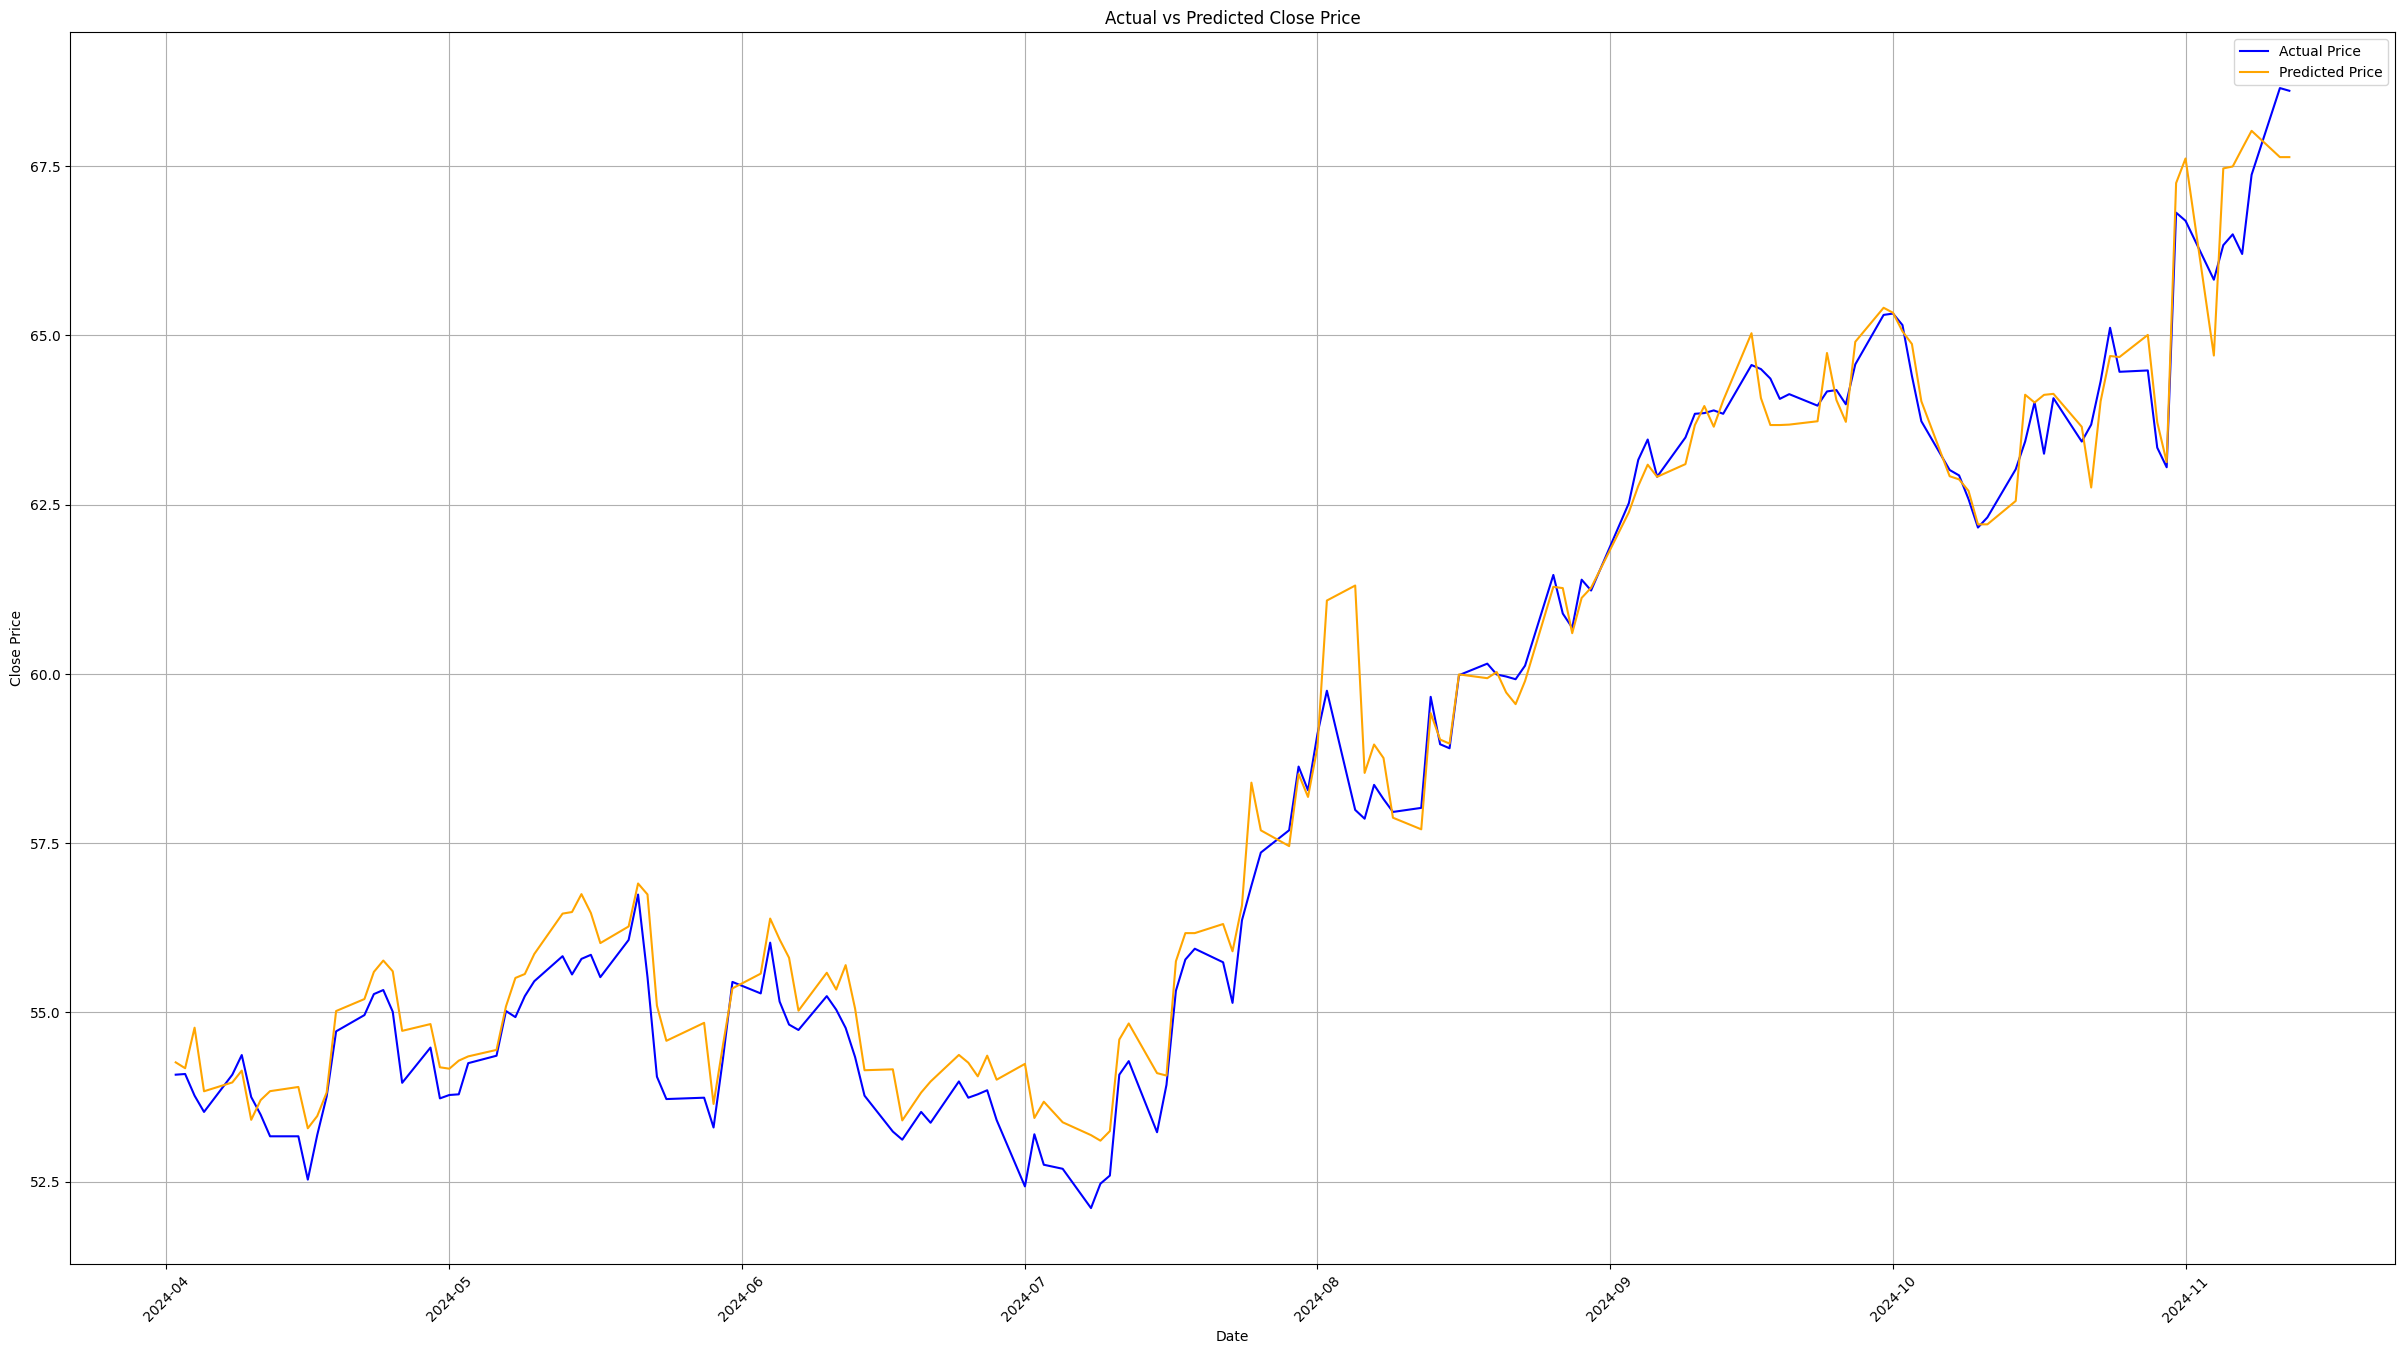

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: WEC
Mean Squared Error: 0.02182437574324887
Root Mean Squared Error: 0.14773075422283902
R-squared: 0.9781756242567511


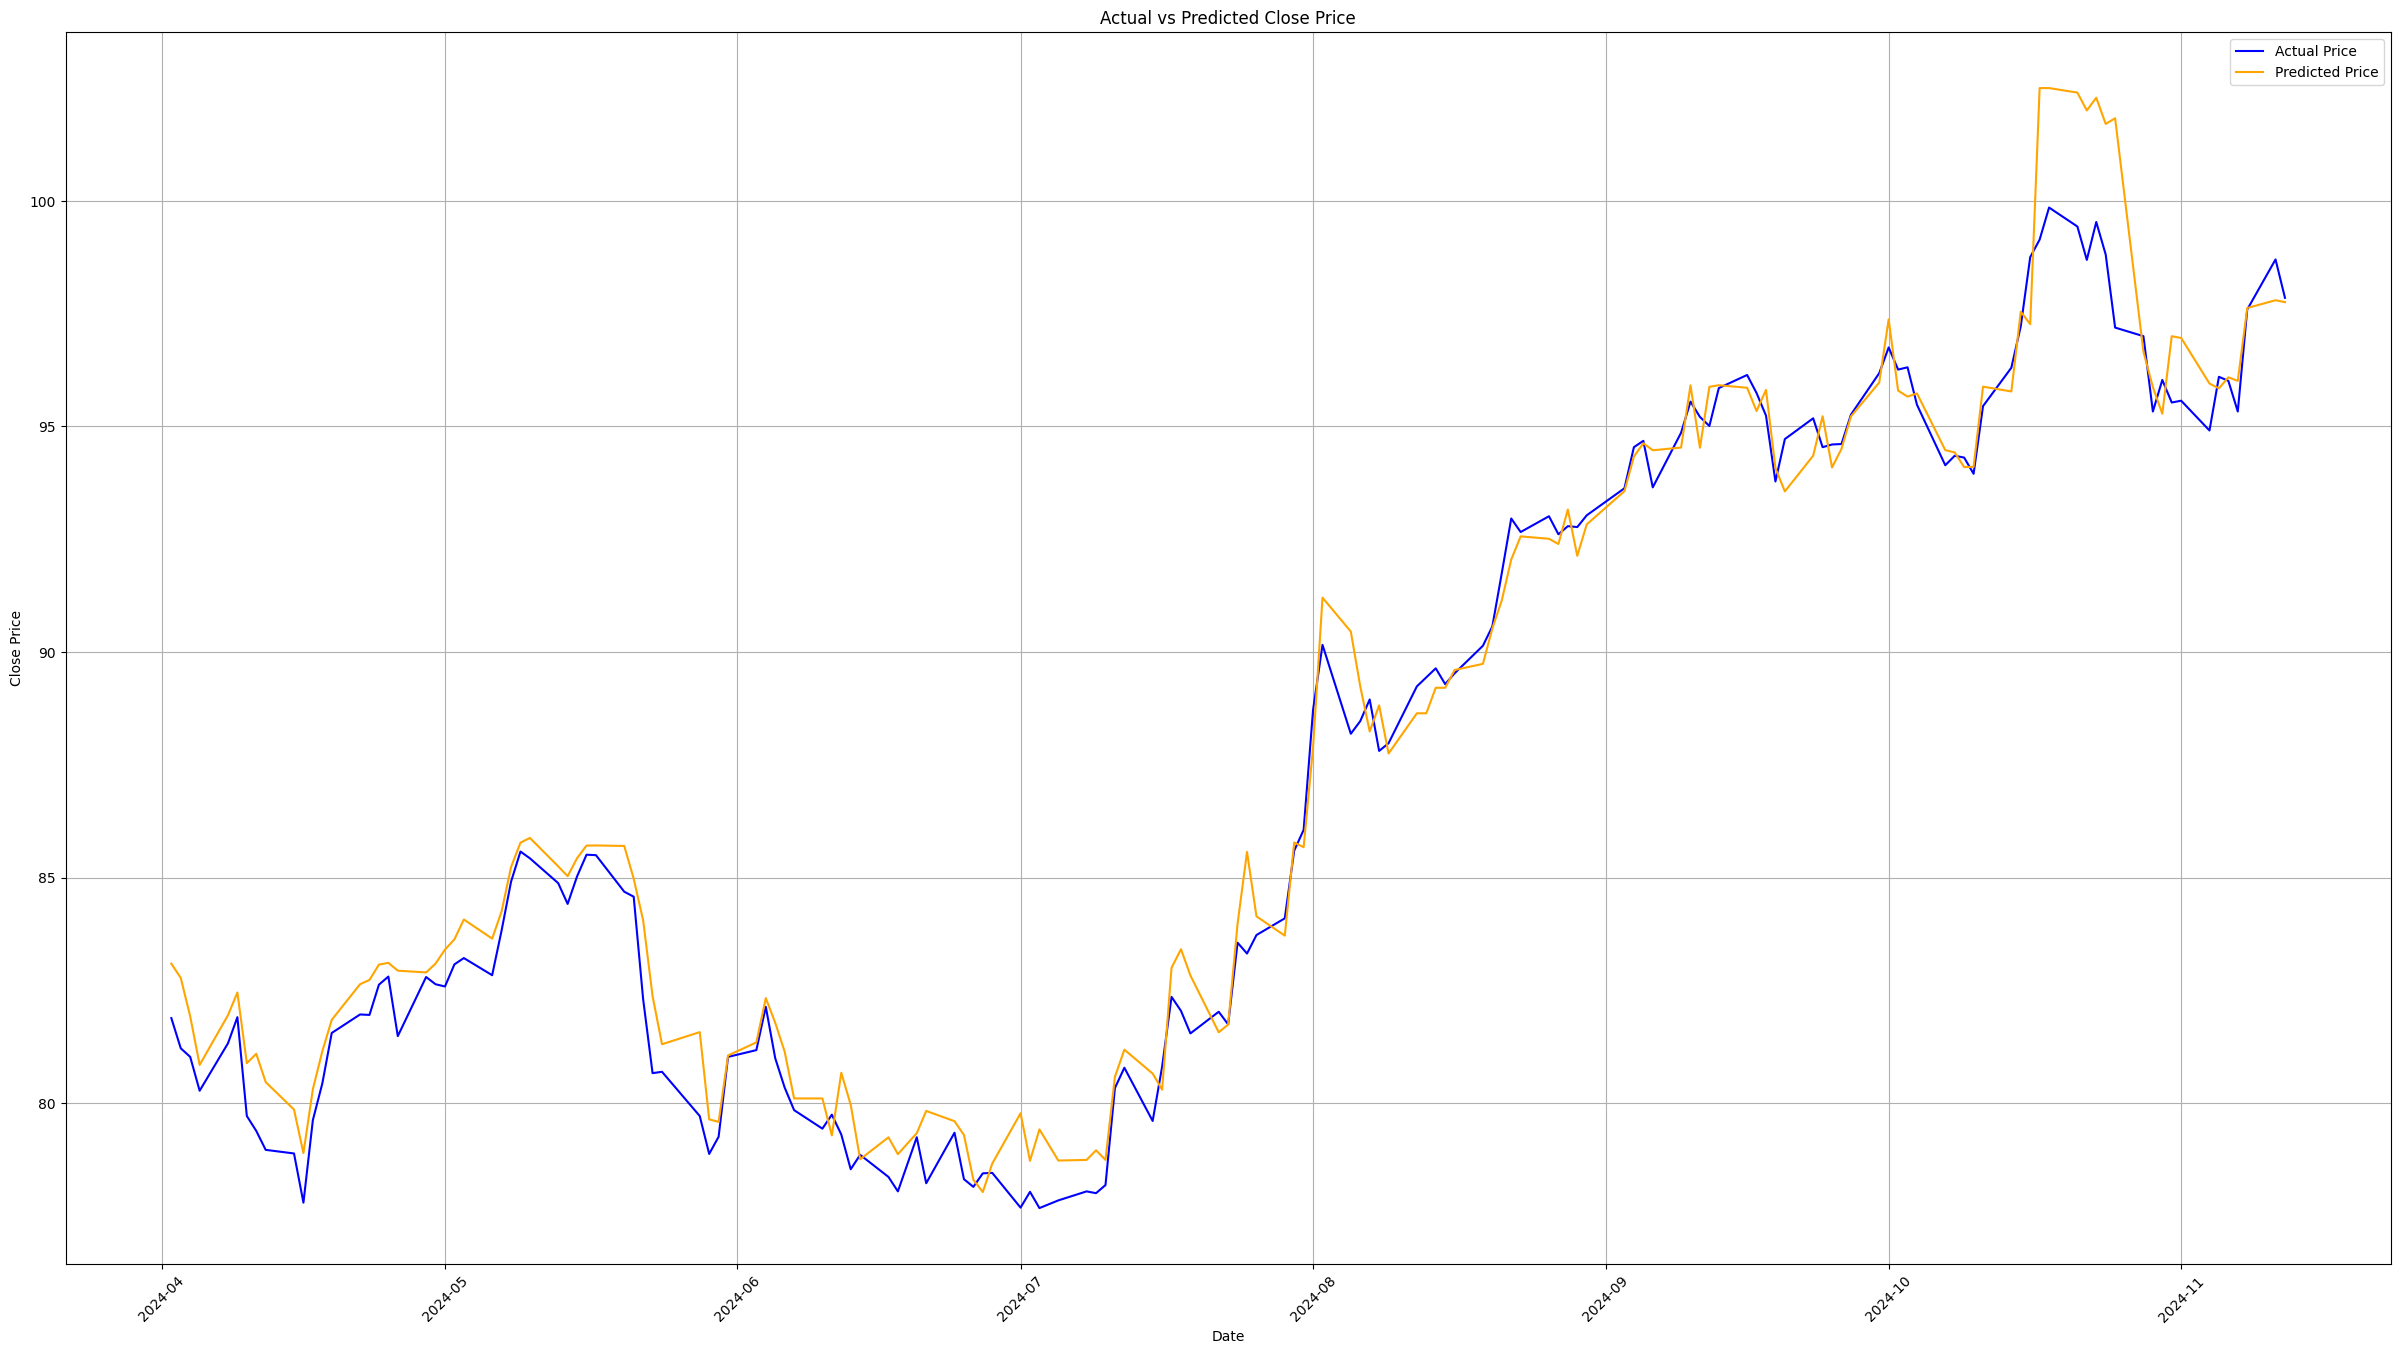

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: PEG
Mean Squared Error: 0.02057210602274344
Root Mean Squared Error: 0.1434297947524971
R-squared: 0.9794278939772566


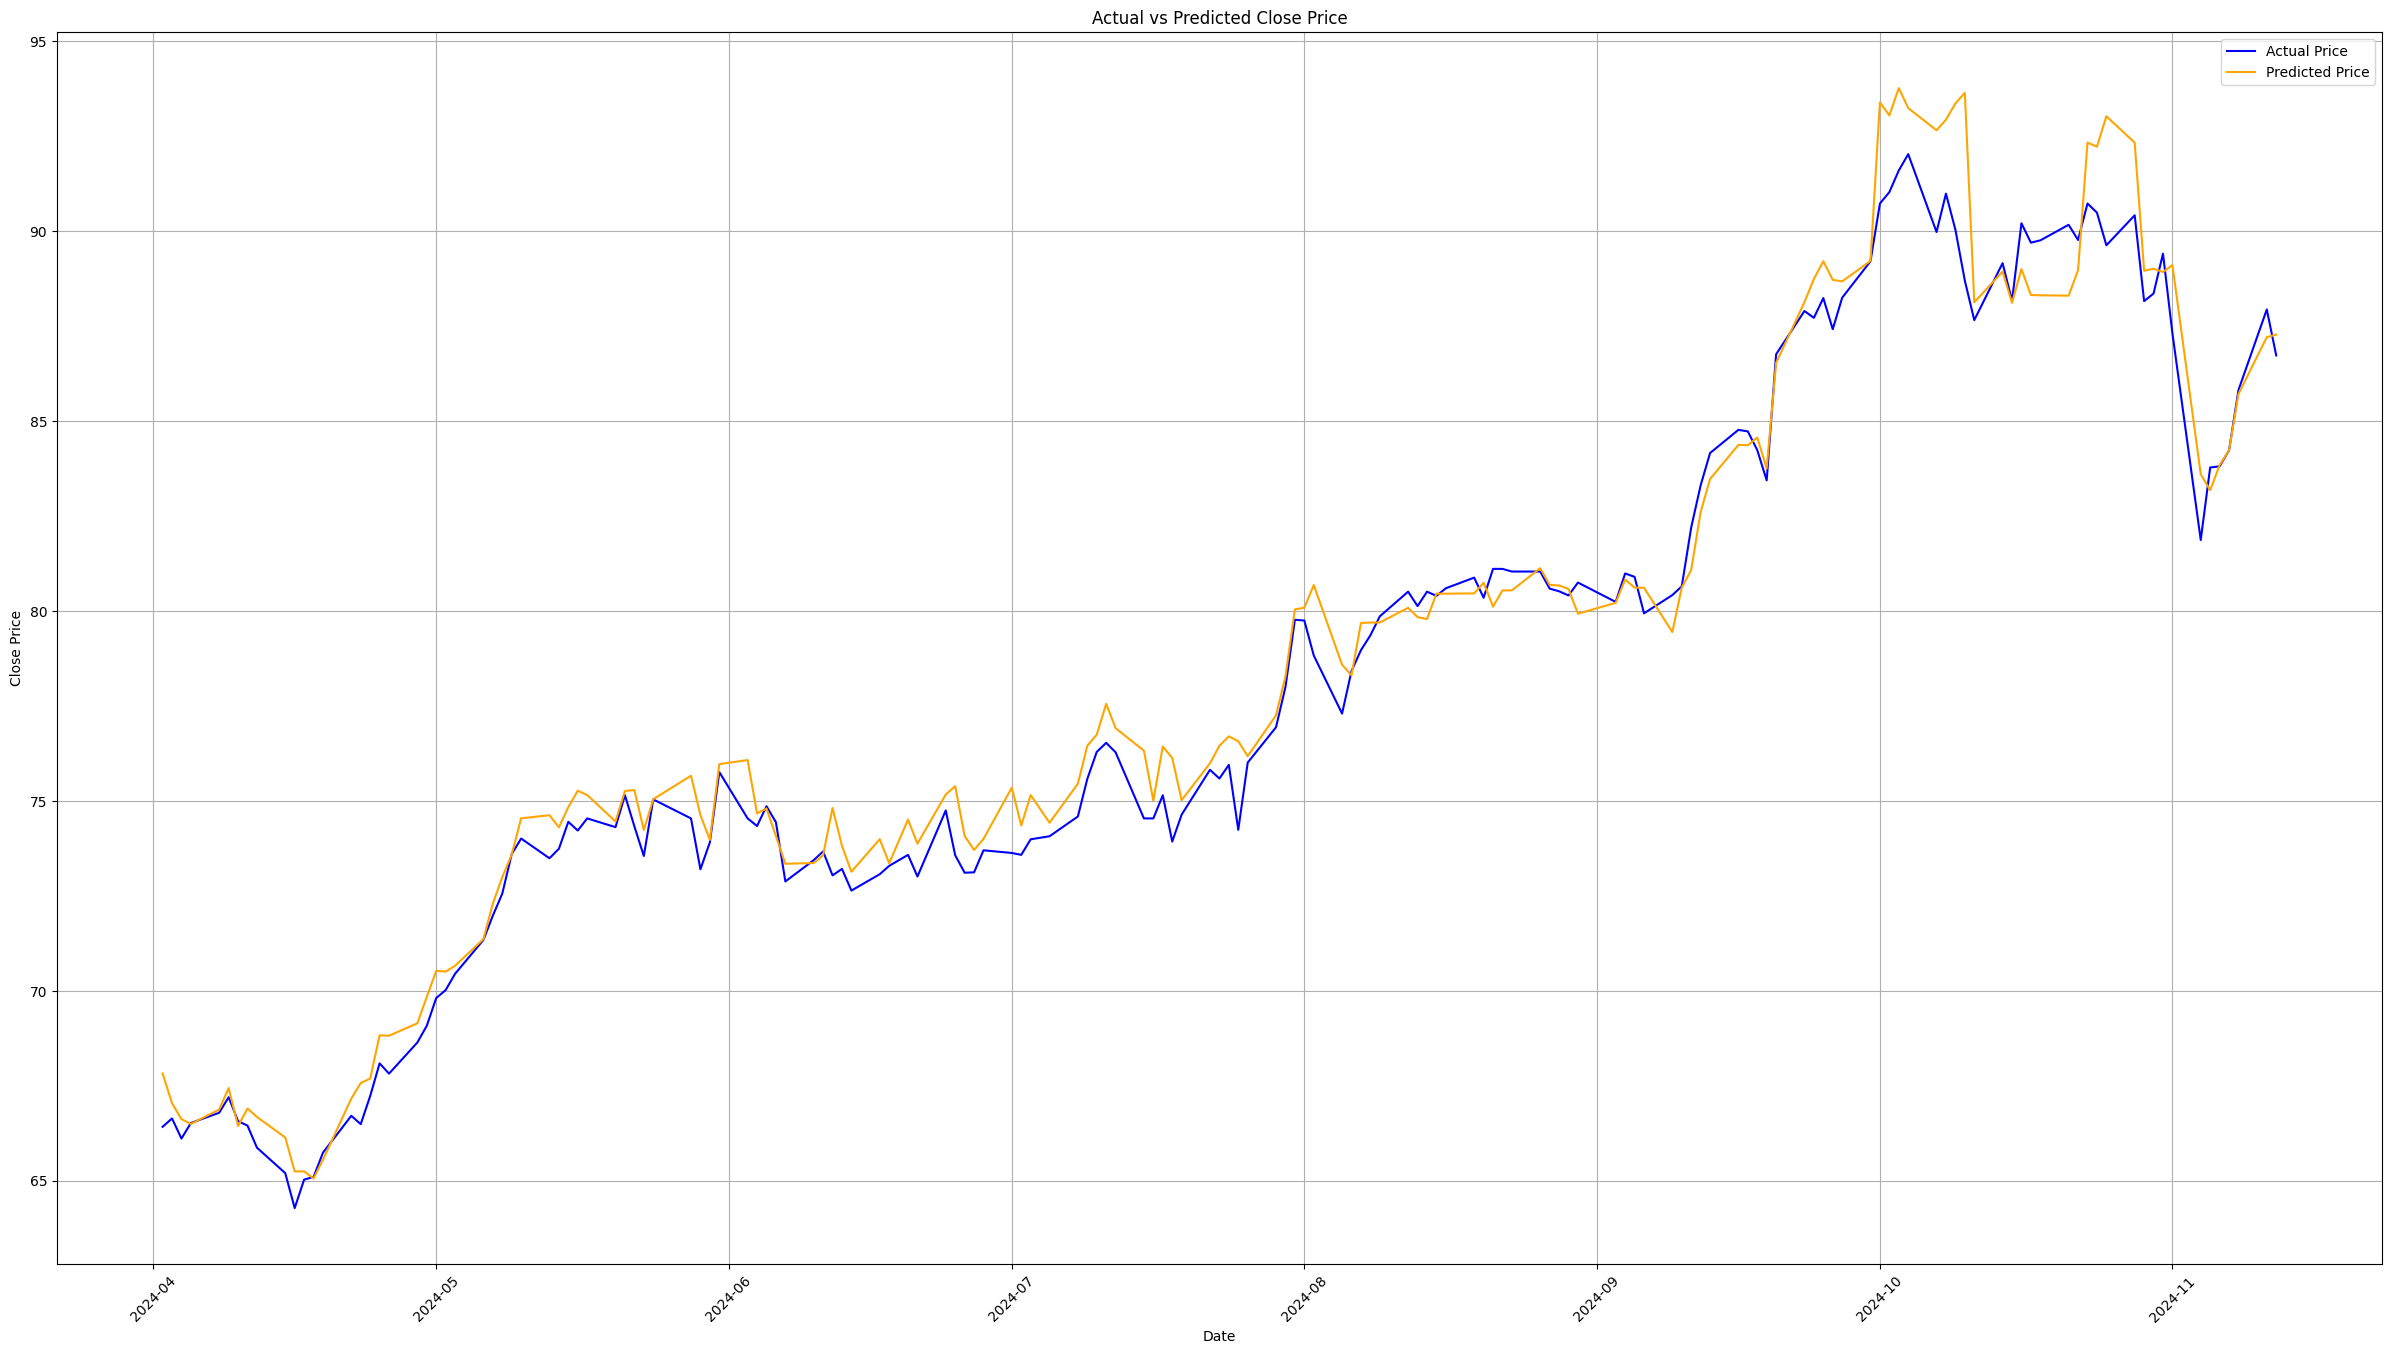

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: DTE
Mean Squared Error: 0.02581620793617413
Root Mean Squared Error: 0.16067422922228108
R-squared: 0.9741837920638259


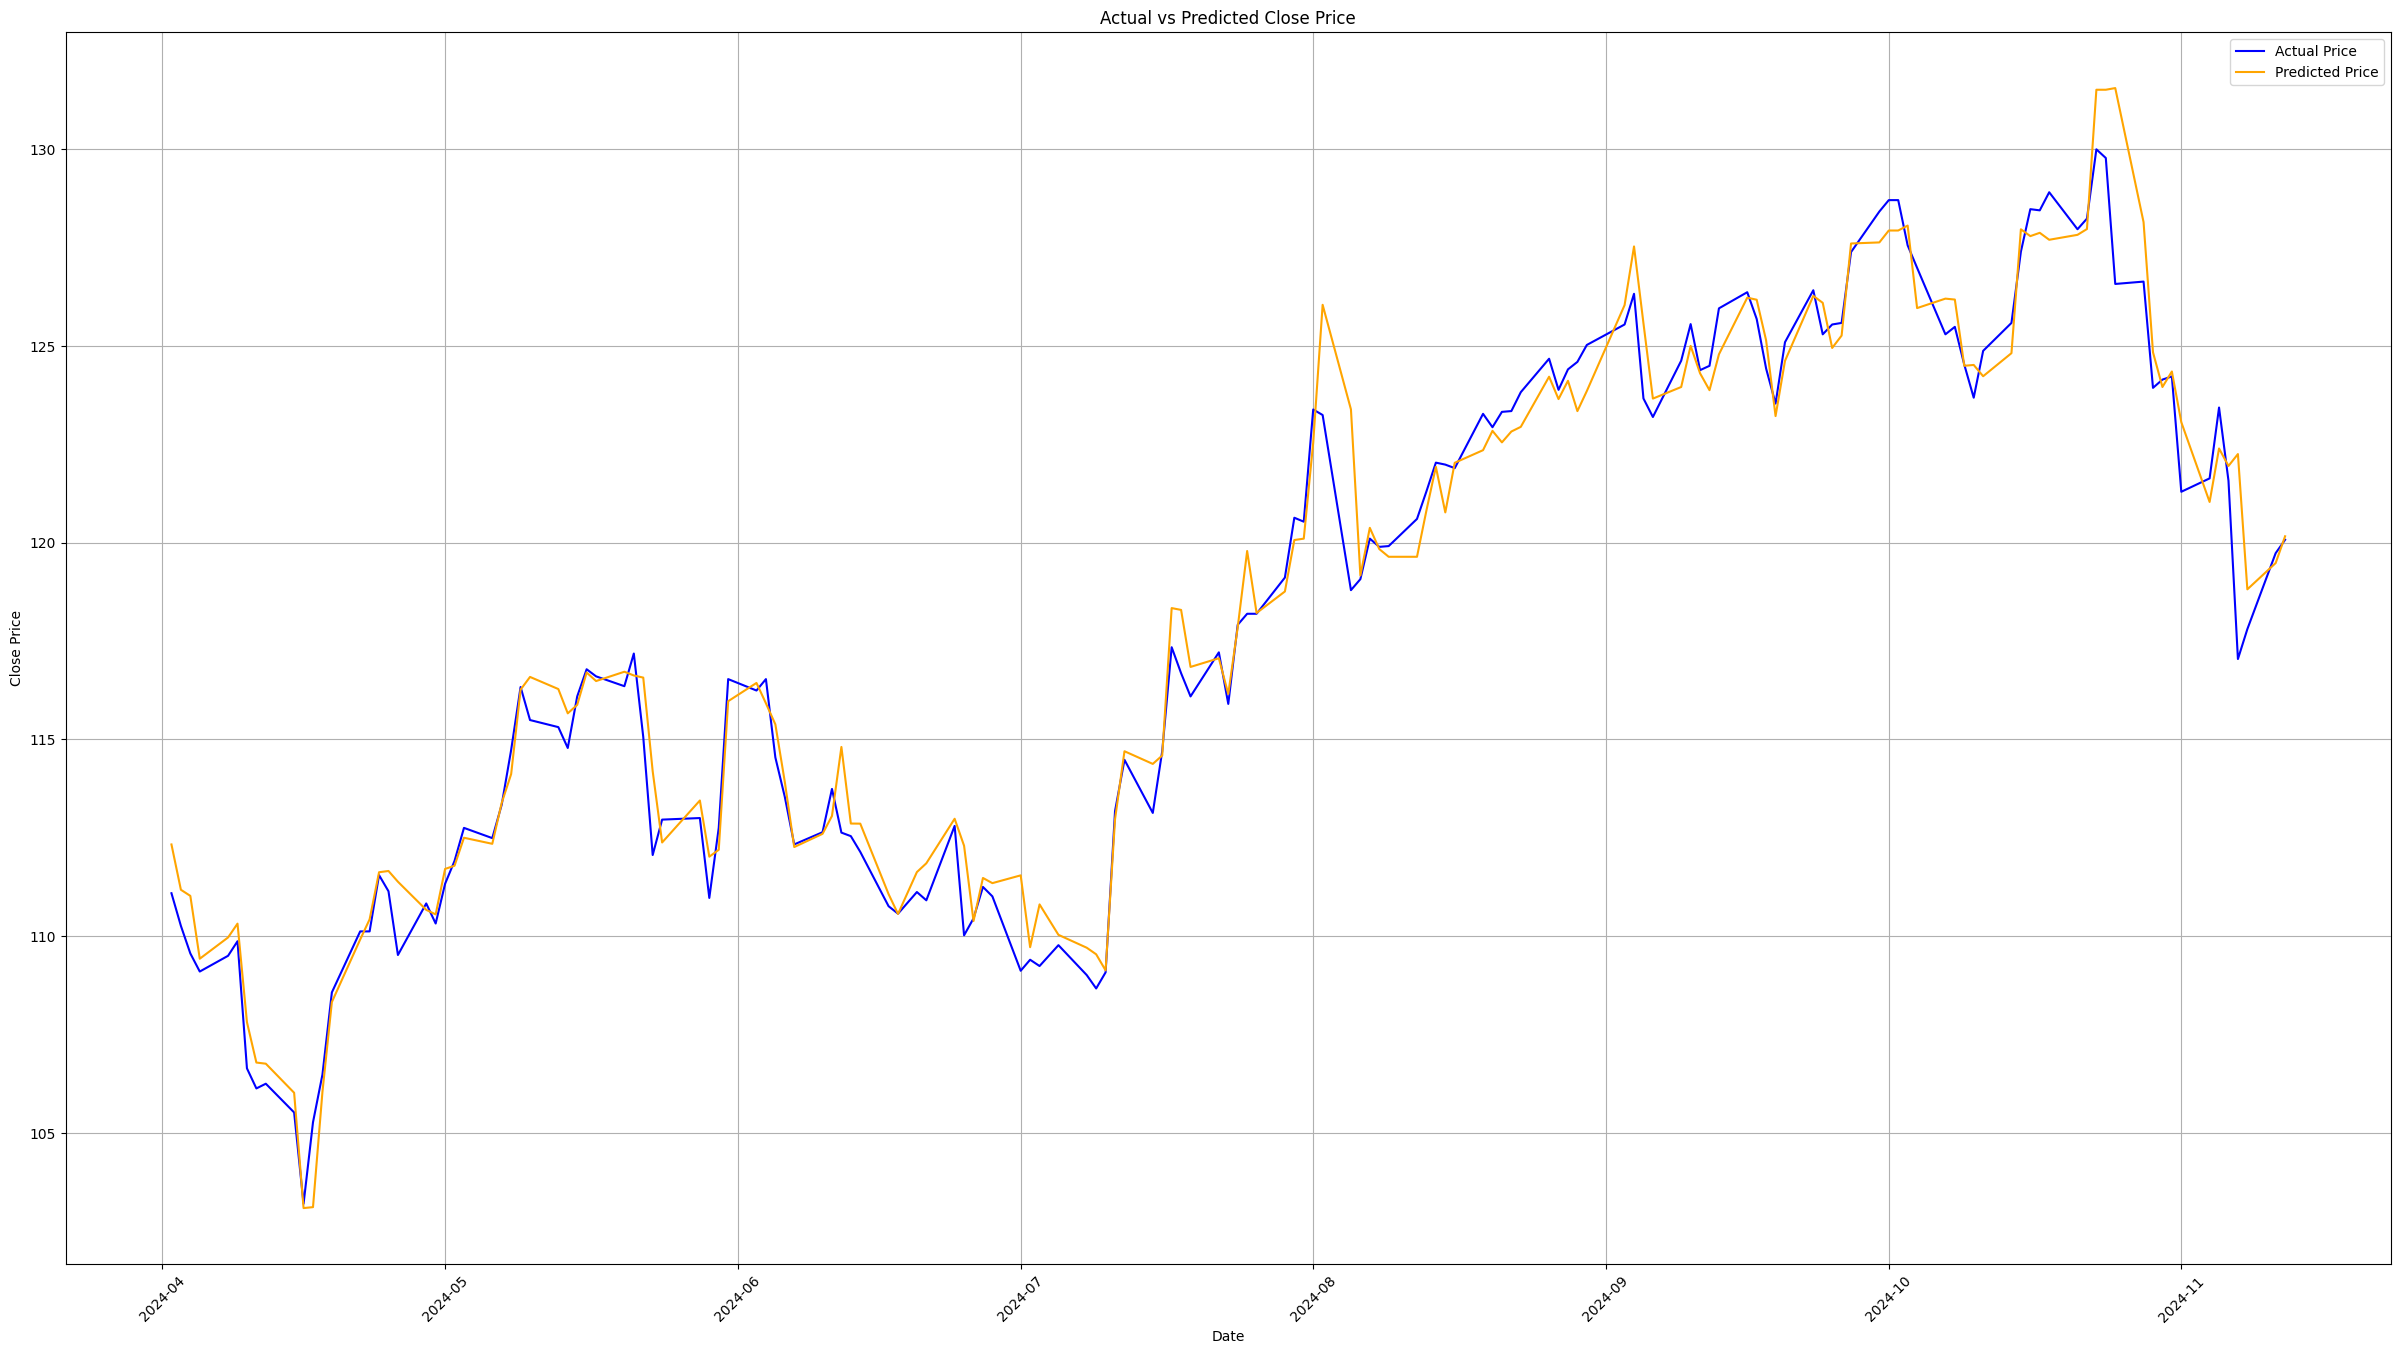

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: LVS
Mean Squared Error: 0.018764738447841448
Root Mean Squared Error: 0.13698444600698814
R-squared: 0.9812352615521586


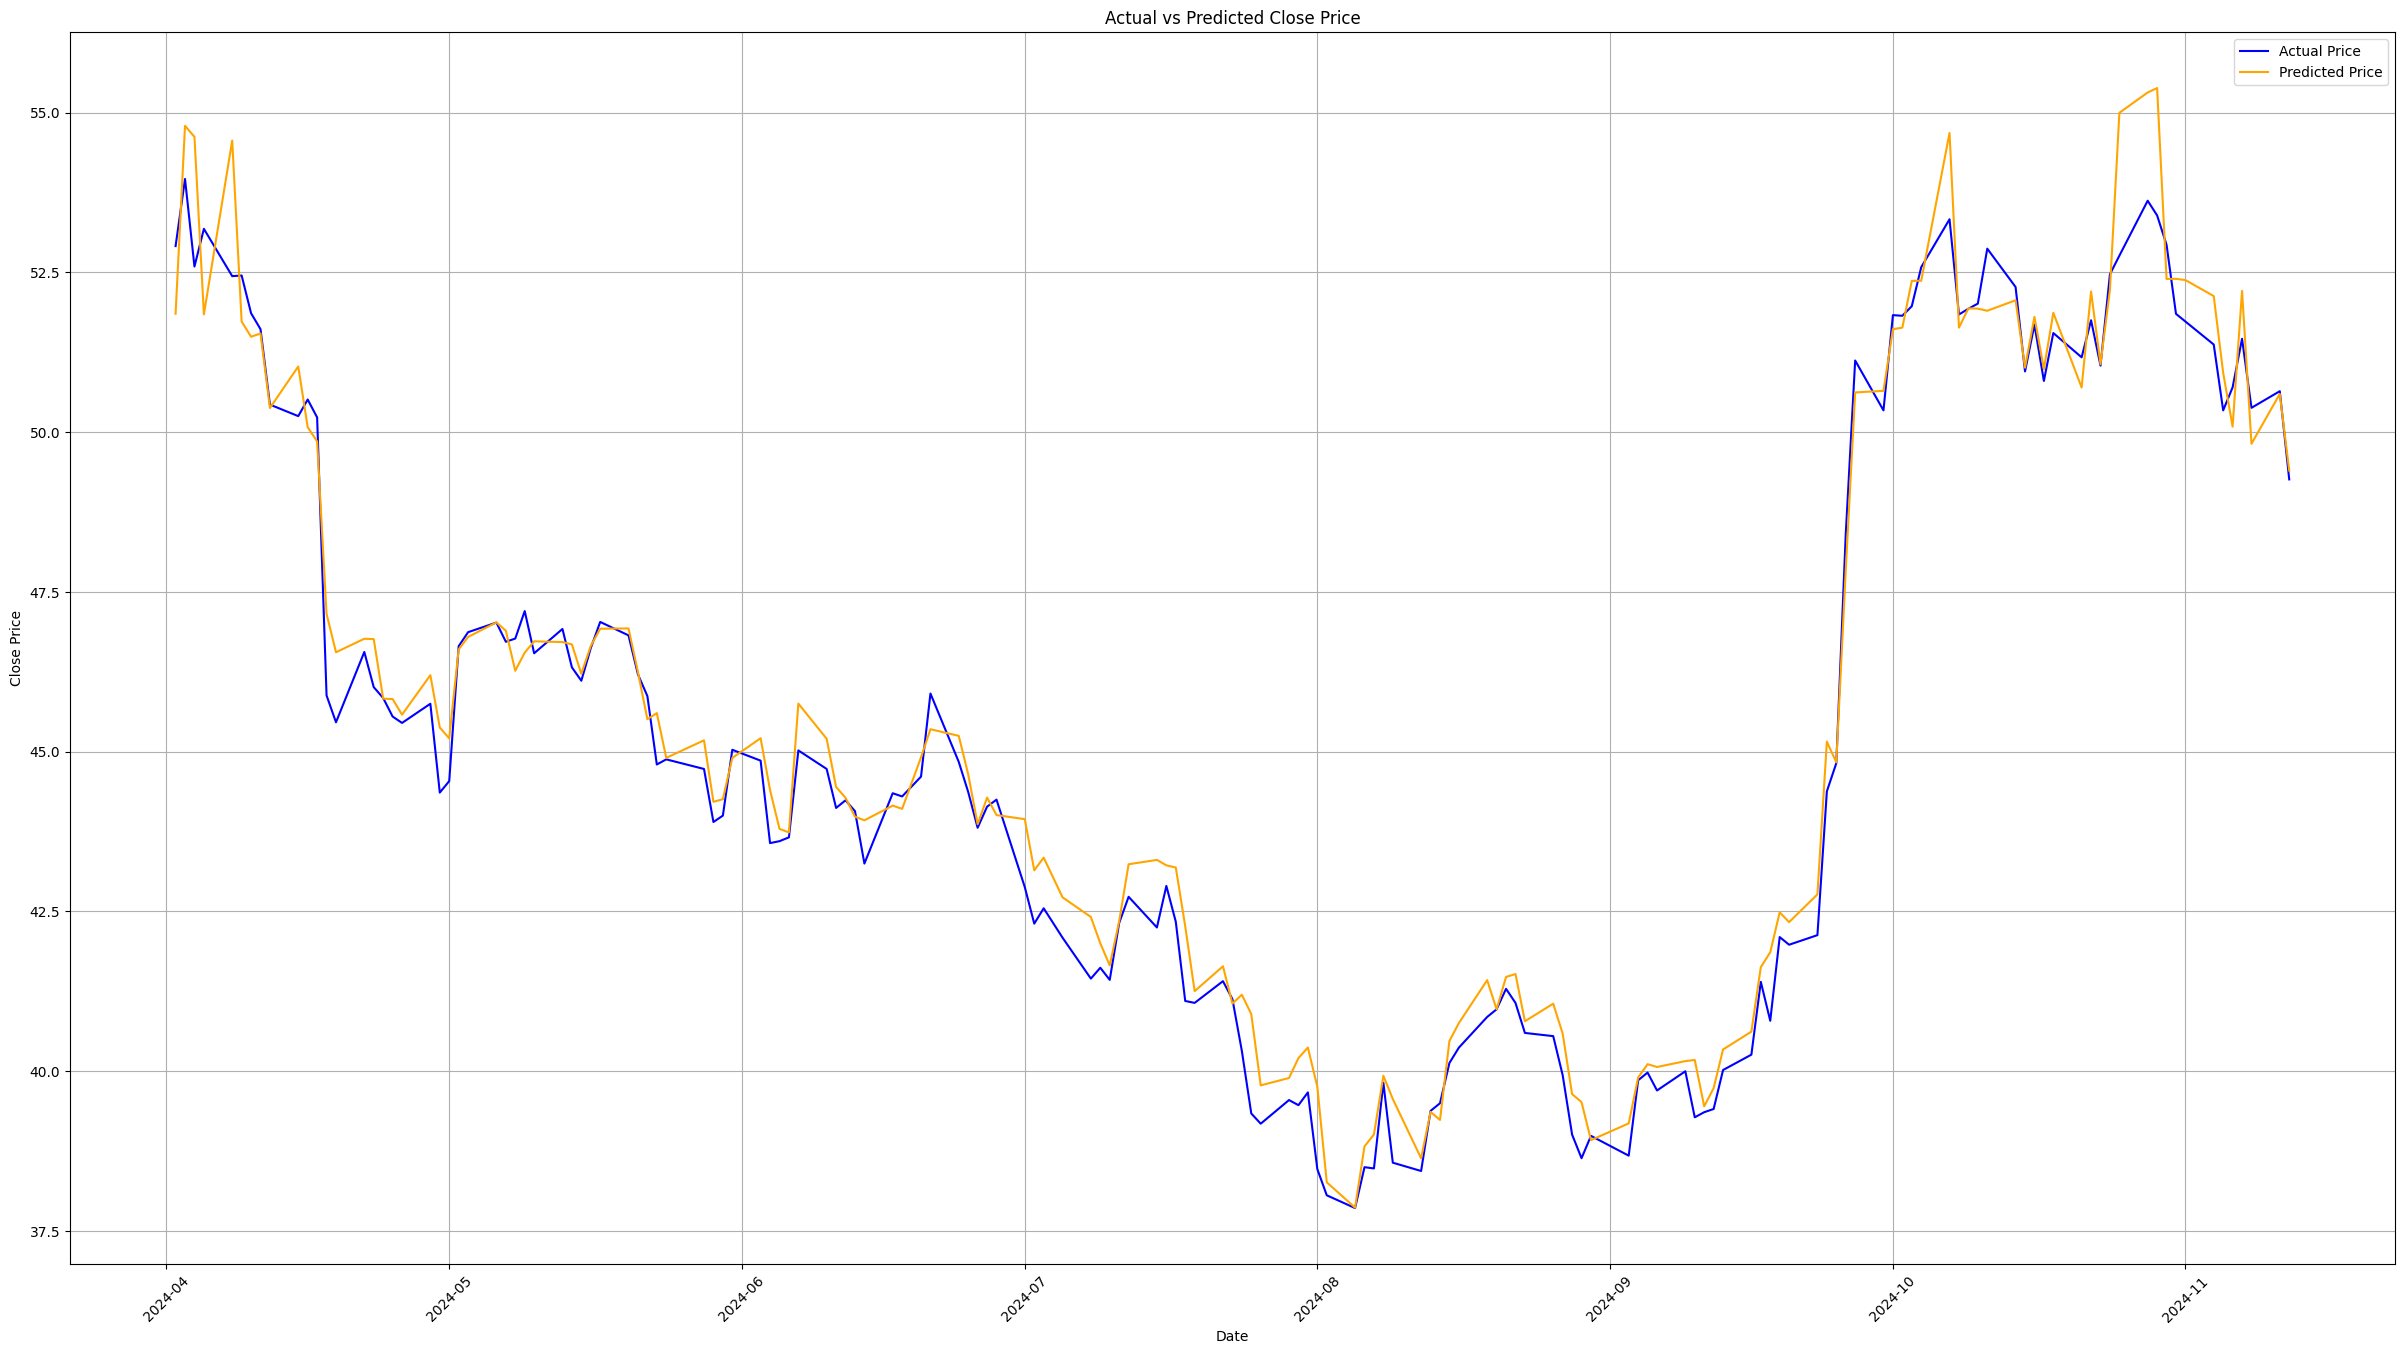

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: MGM
Mean Squared Error: 0.041064813185985934
Root Mean Squared Error: 0.20264454886817443
R-squared: 0.958935186814014


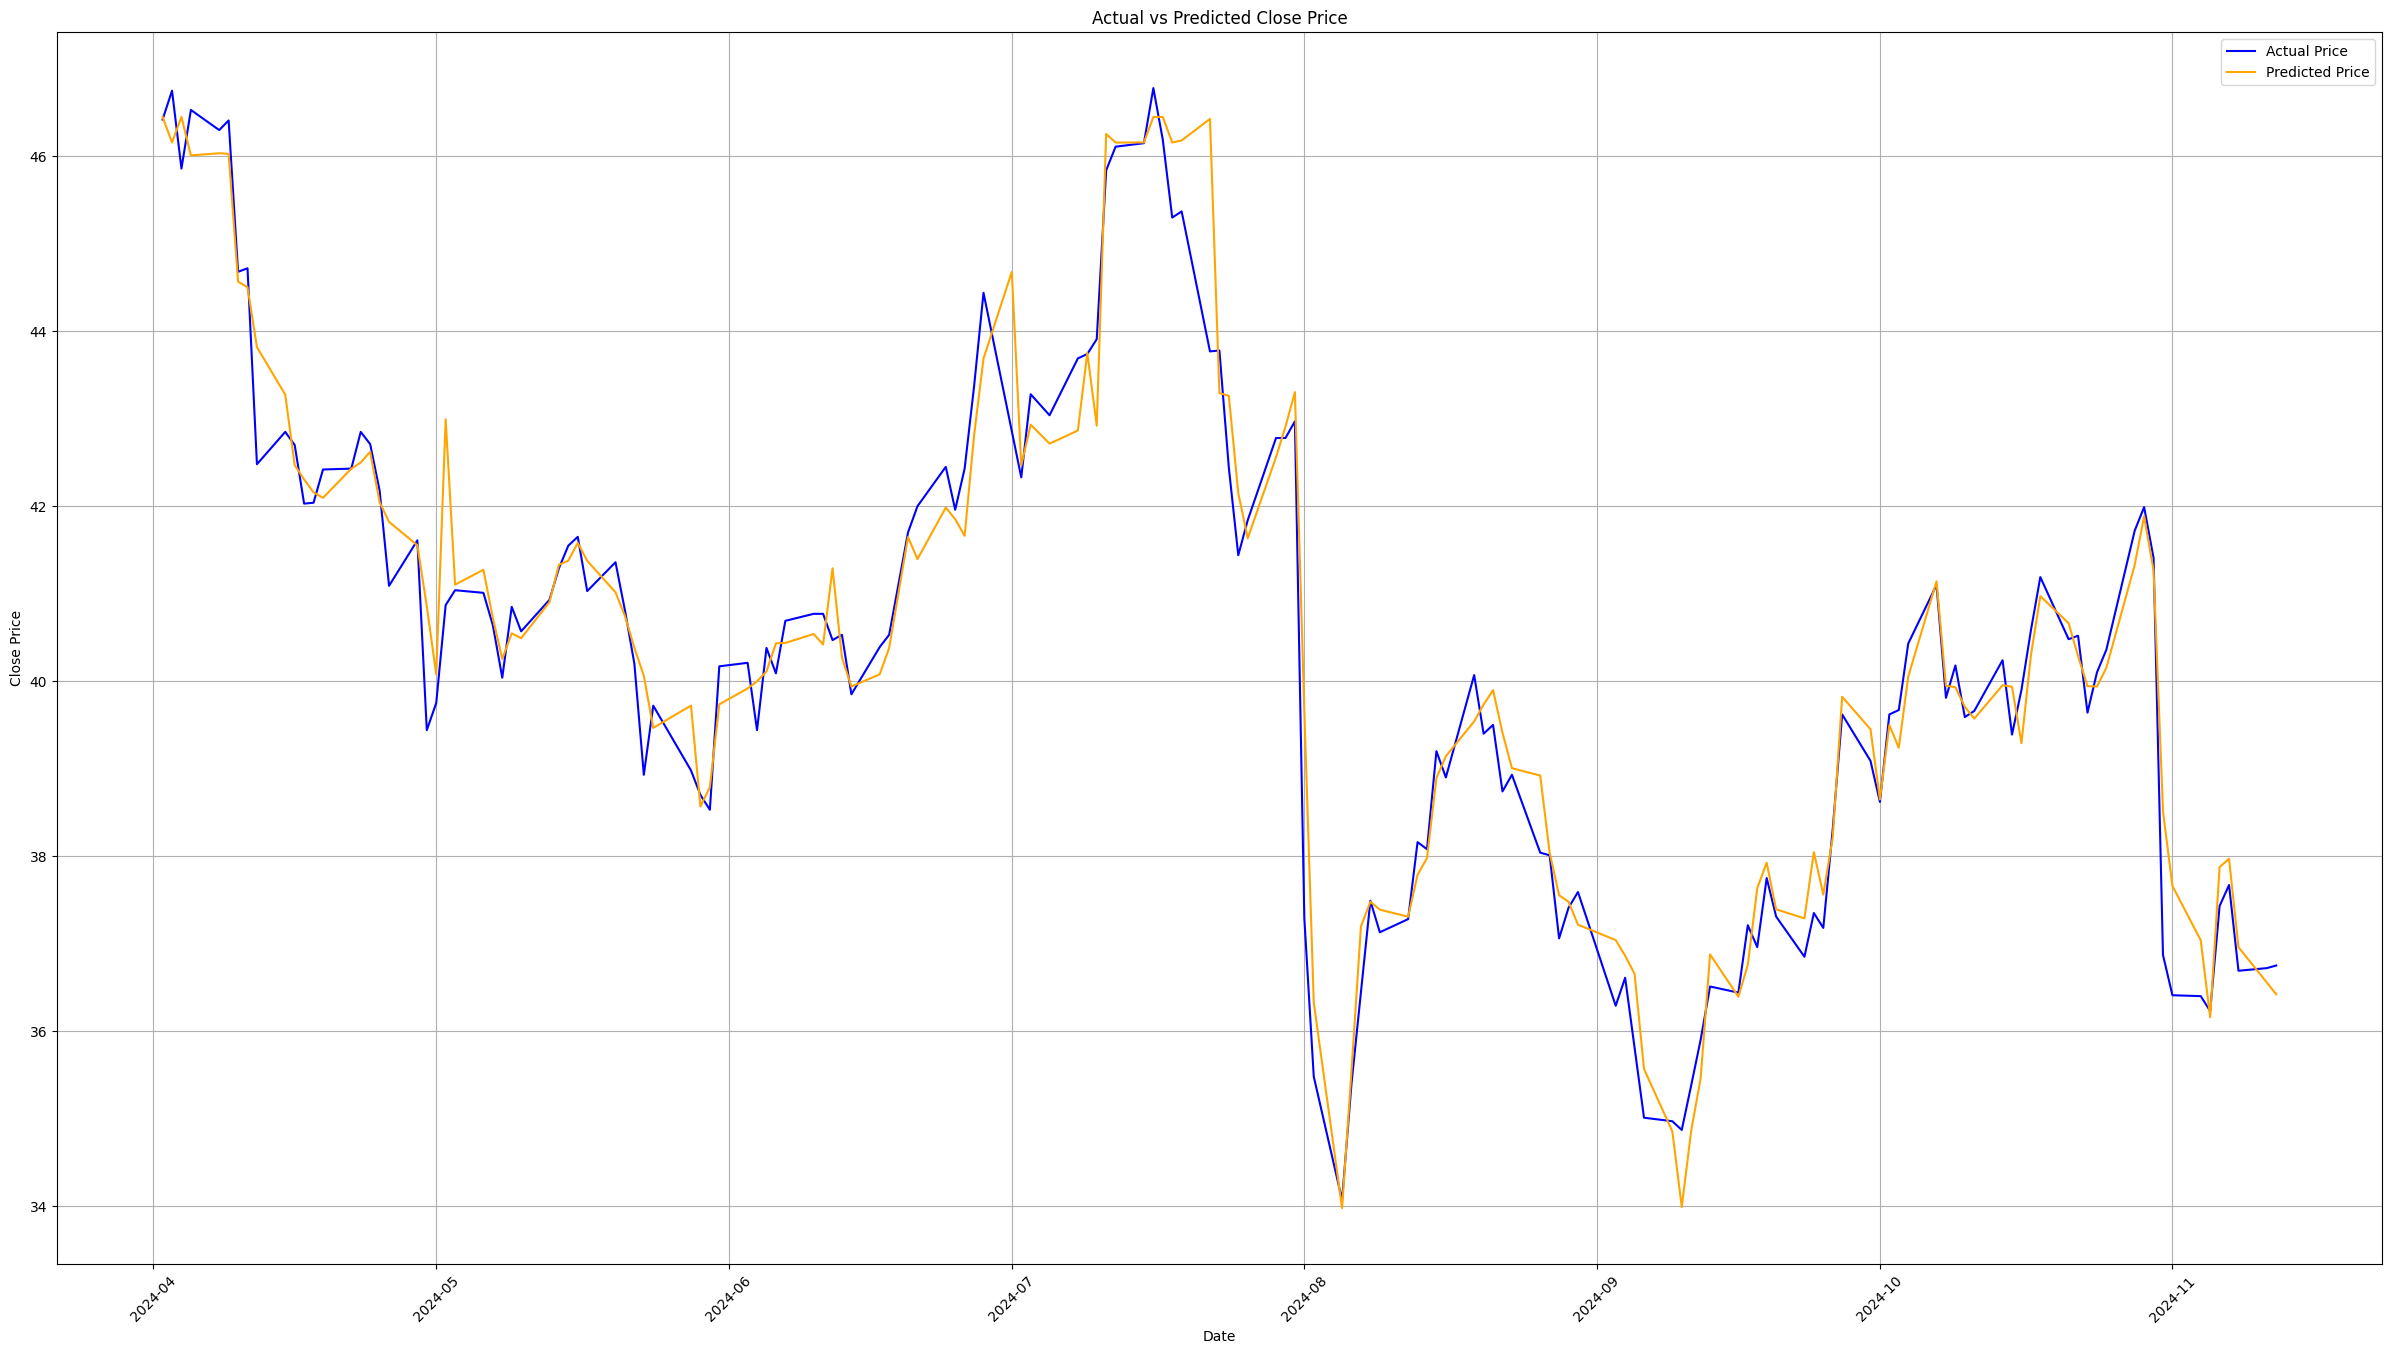

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values


Error for HOG: Found input variables with inconsistent numbers of samples: [157, 150]


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BBBY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values


Error for BBBY: 'NoneType' object has no attribute 'iloc'

Company: DHI
Mean Squared Error: 0.015958579328762917
Root Mean Squared Error: 0.12632727072474462
R-squared: 0.9840414206712371


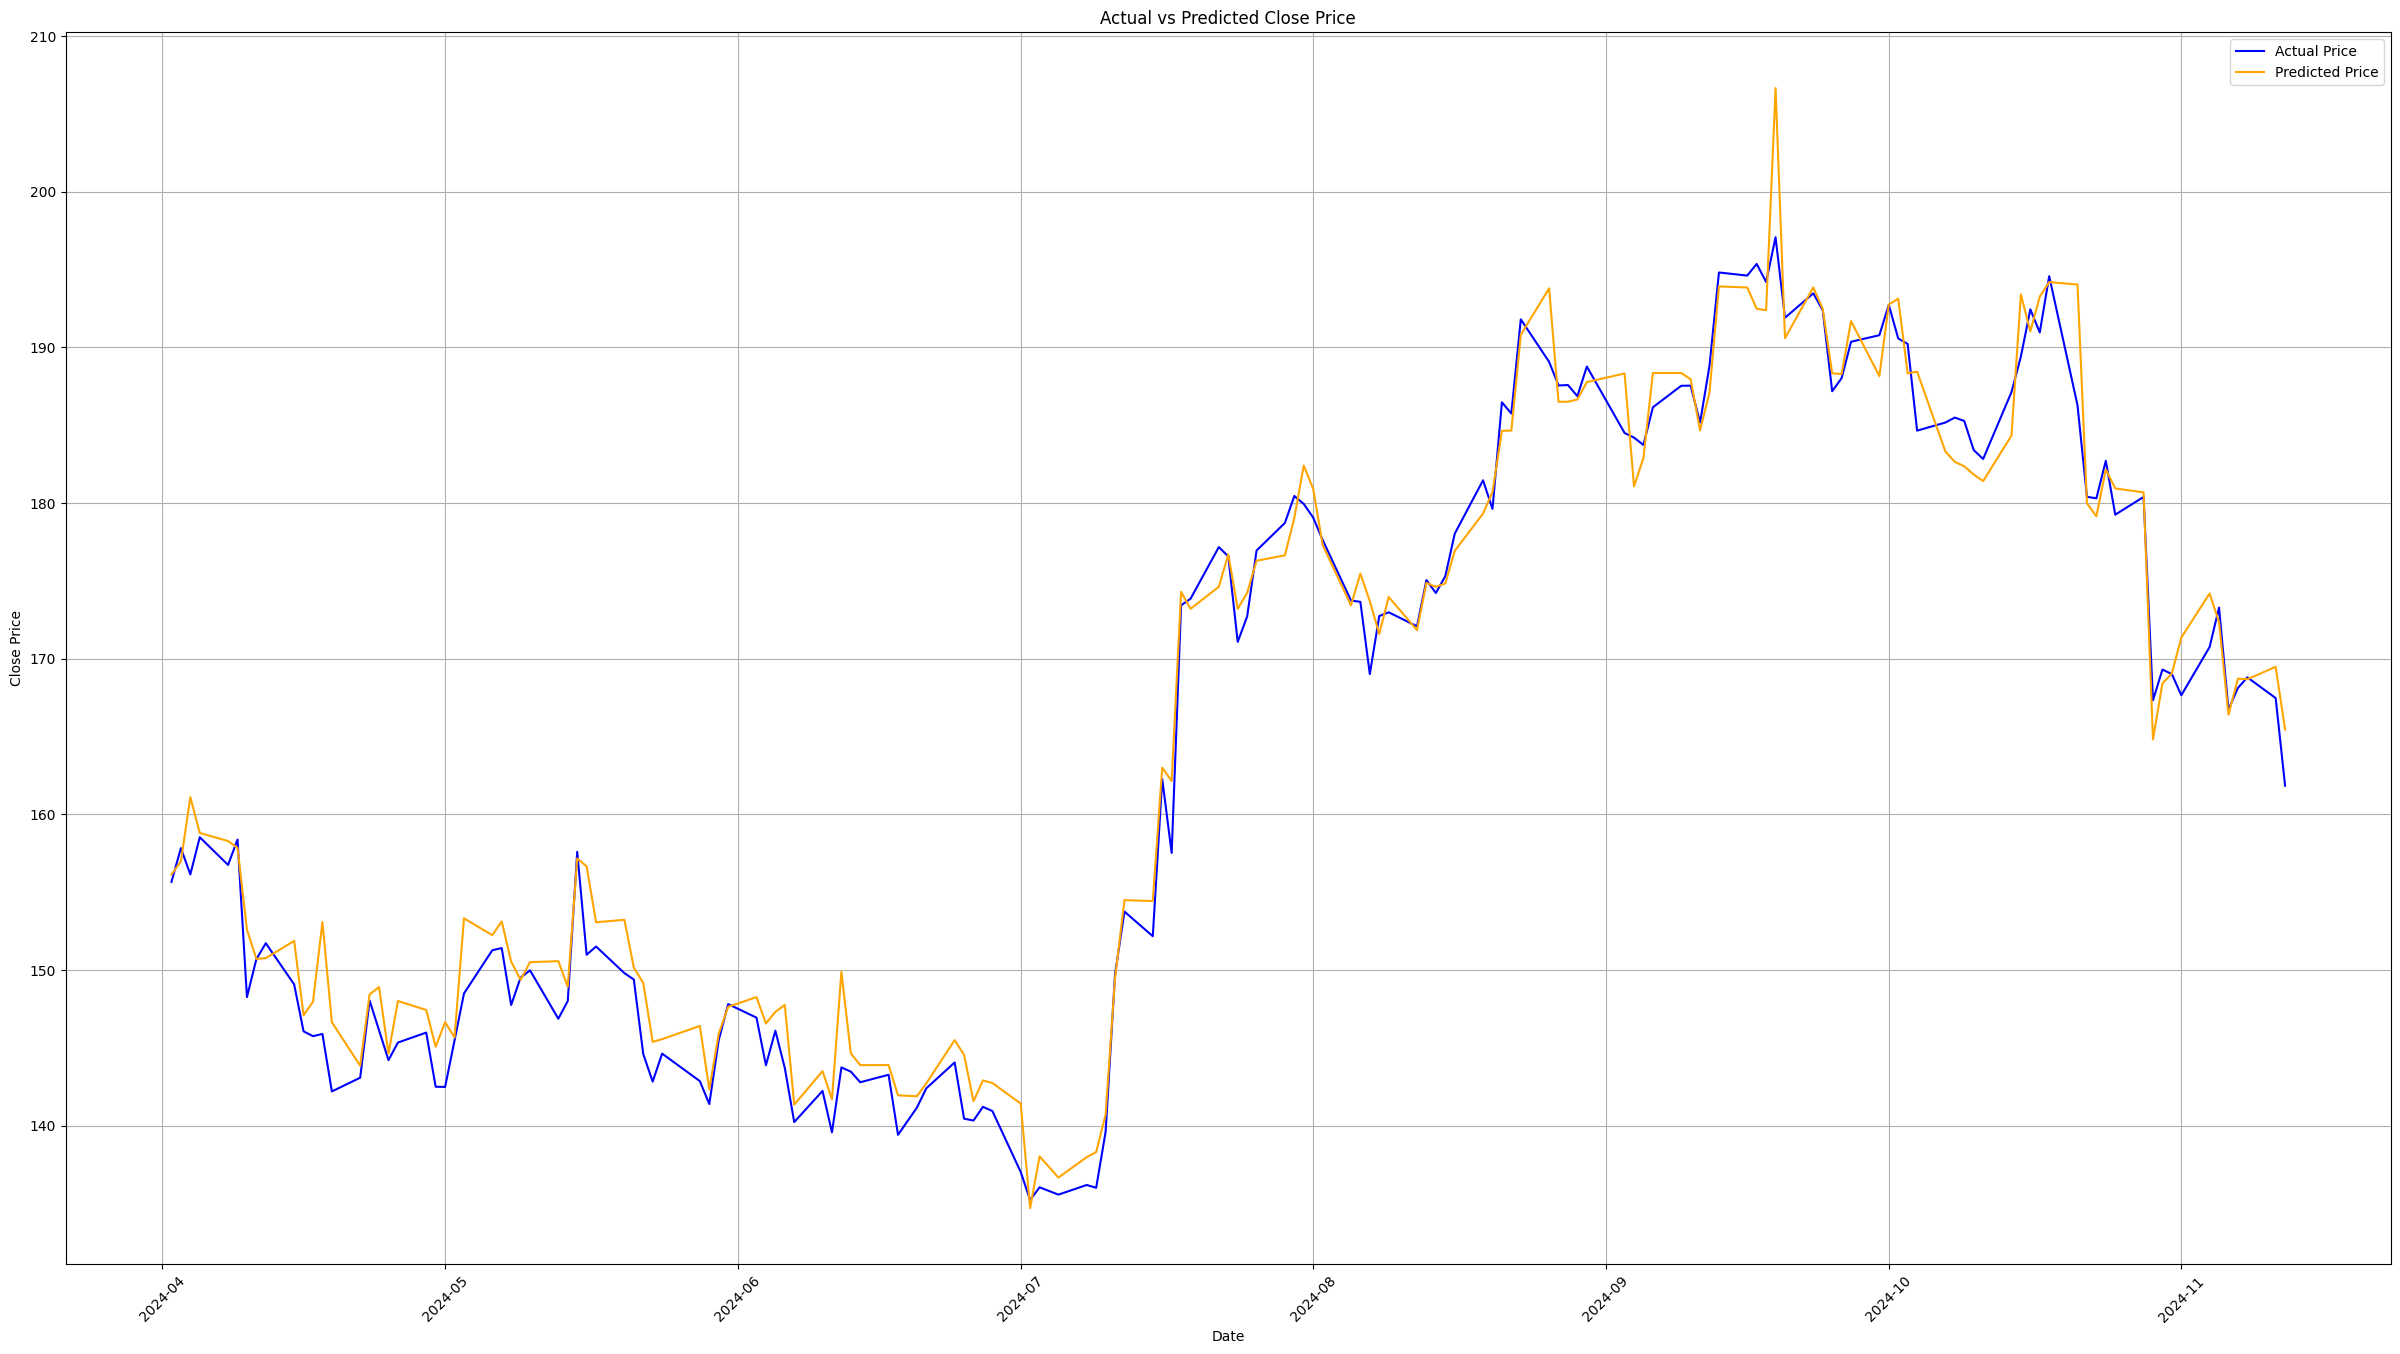

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: UPS
Mean Squared Error: 0.028074176184737013
Root Mean Squared Error: 0.16755350245440115
R-squared: 0.9719258238152629


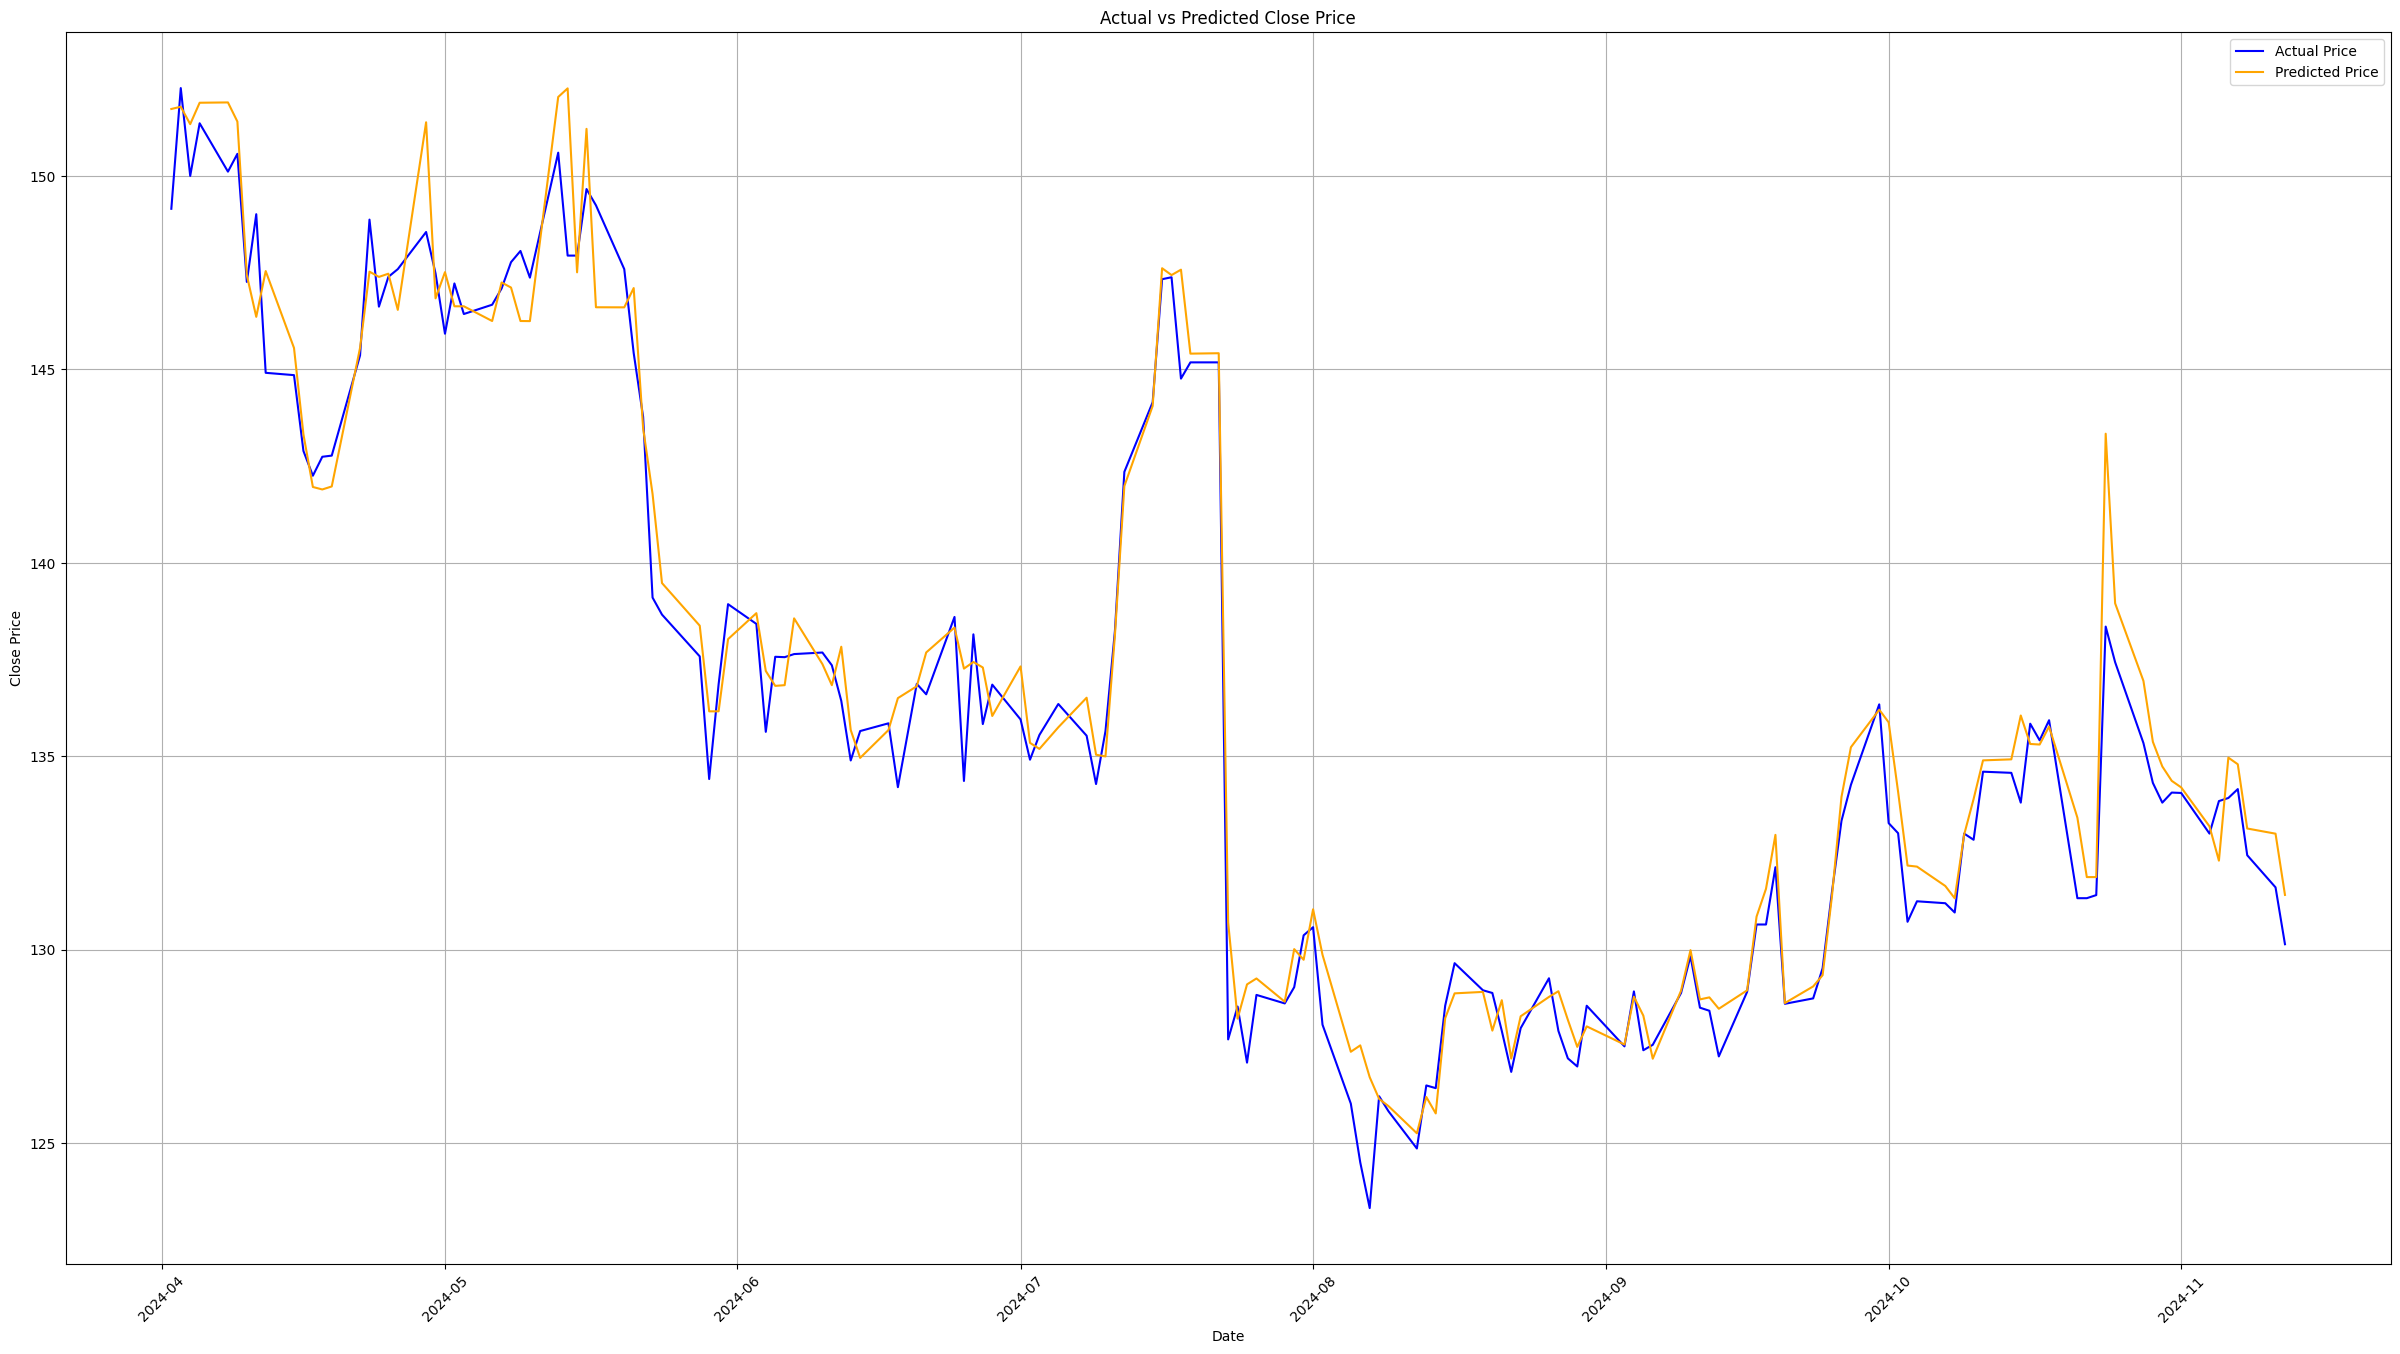

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: FDX
Mean Squared Error: 0.024943112860378296
Root Mean Squared Error: 0.15793388762510185
R-squared: 0.9750568871396217


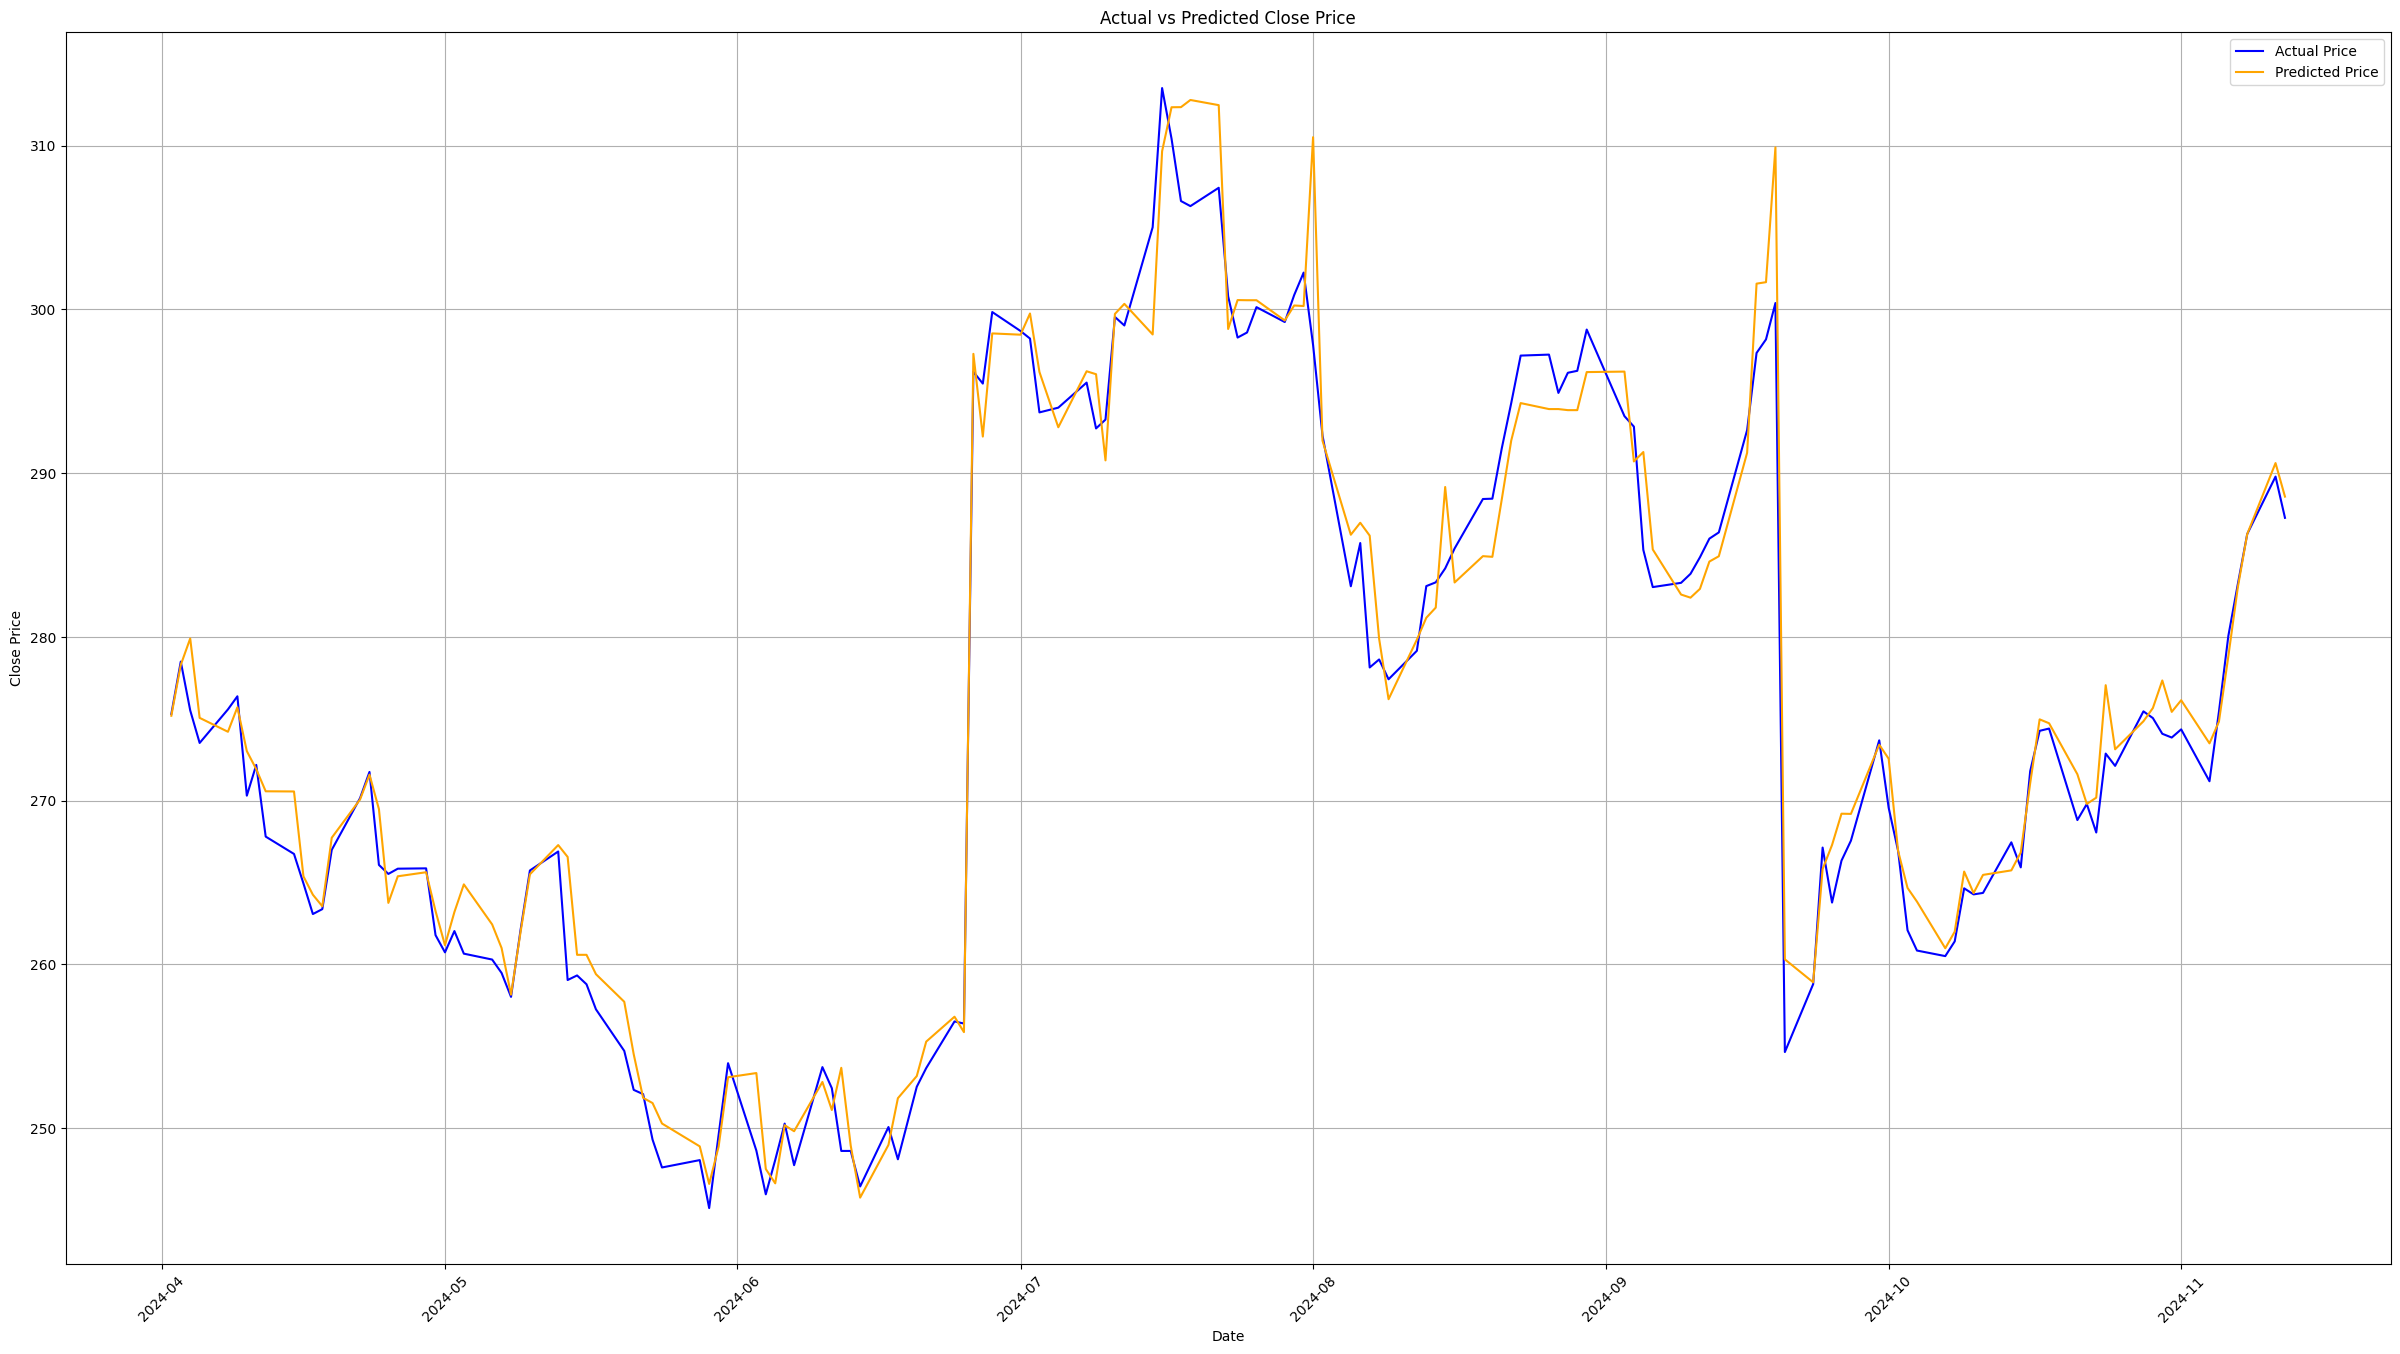

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = 

Error for ROK: Found input variables with inconsistent numbers of samples: [157, 151]
Error for ETN: Found input variables with inconsistent numbers of samples: [157, 152]


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_24012\786106740.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values



Company: SWK
Mean Squared Error: 0.029821959291218166
Root Mean Squared Error: 0.17269035668275795
R-squared: 0.9701780407087818


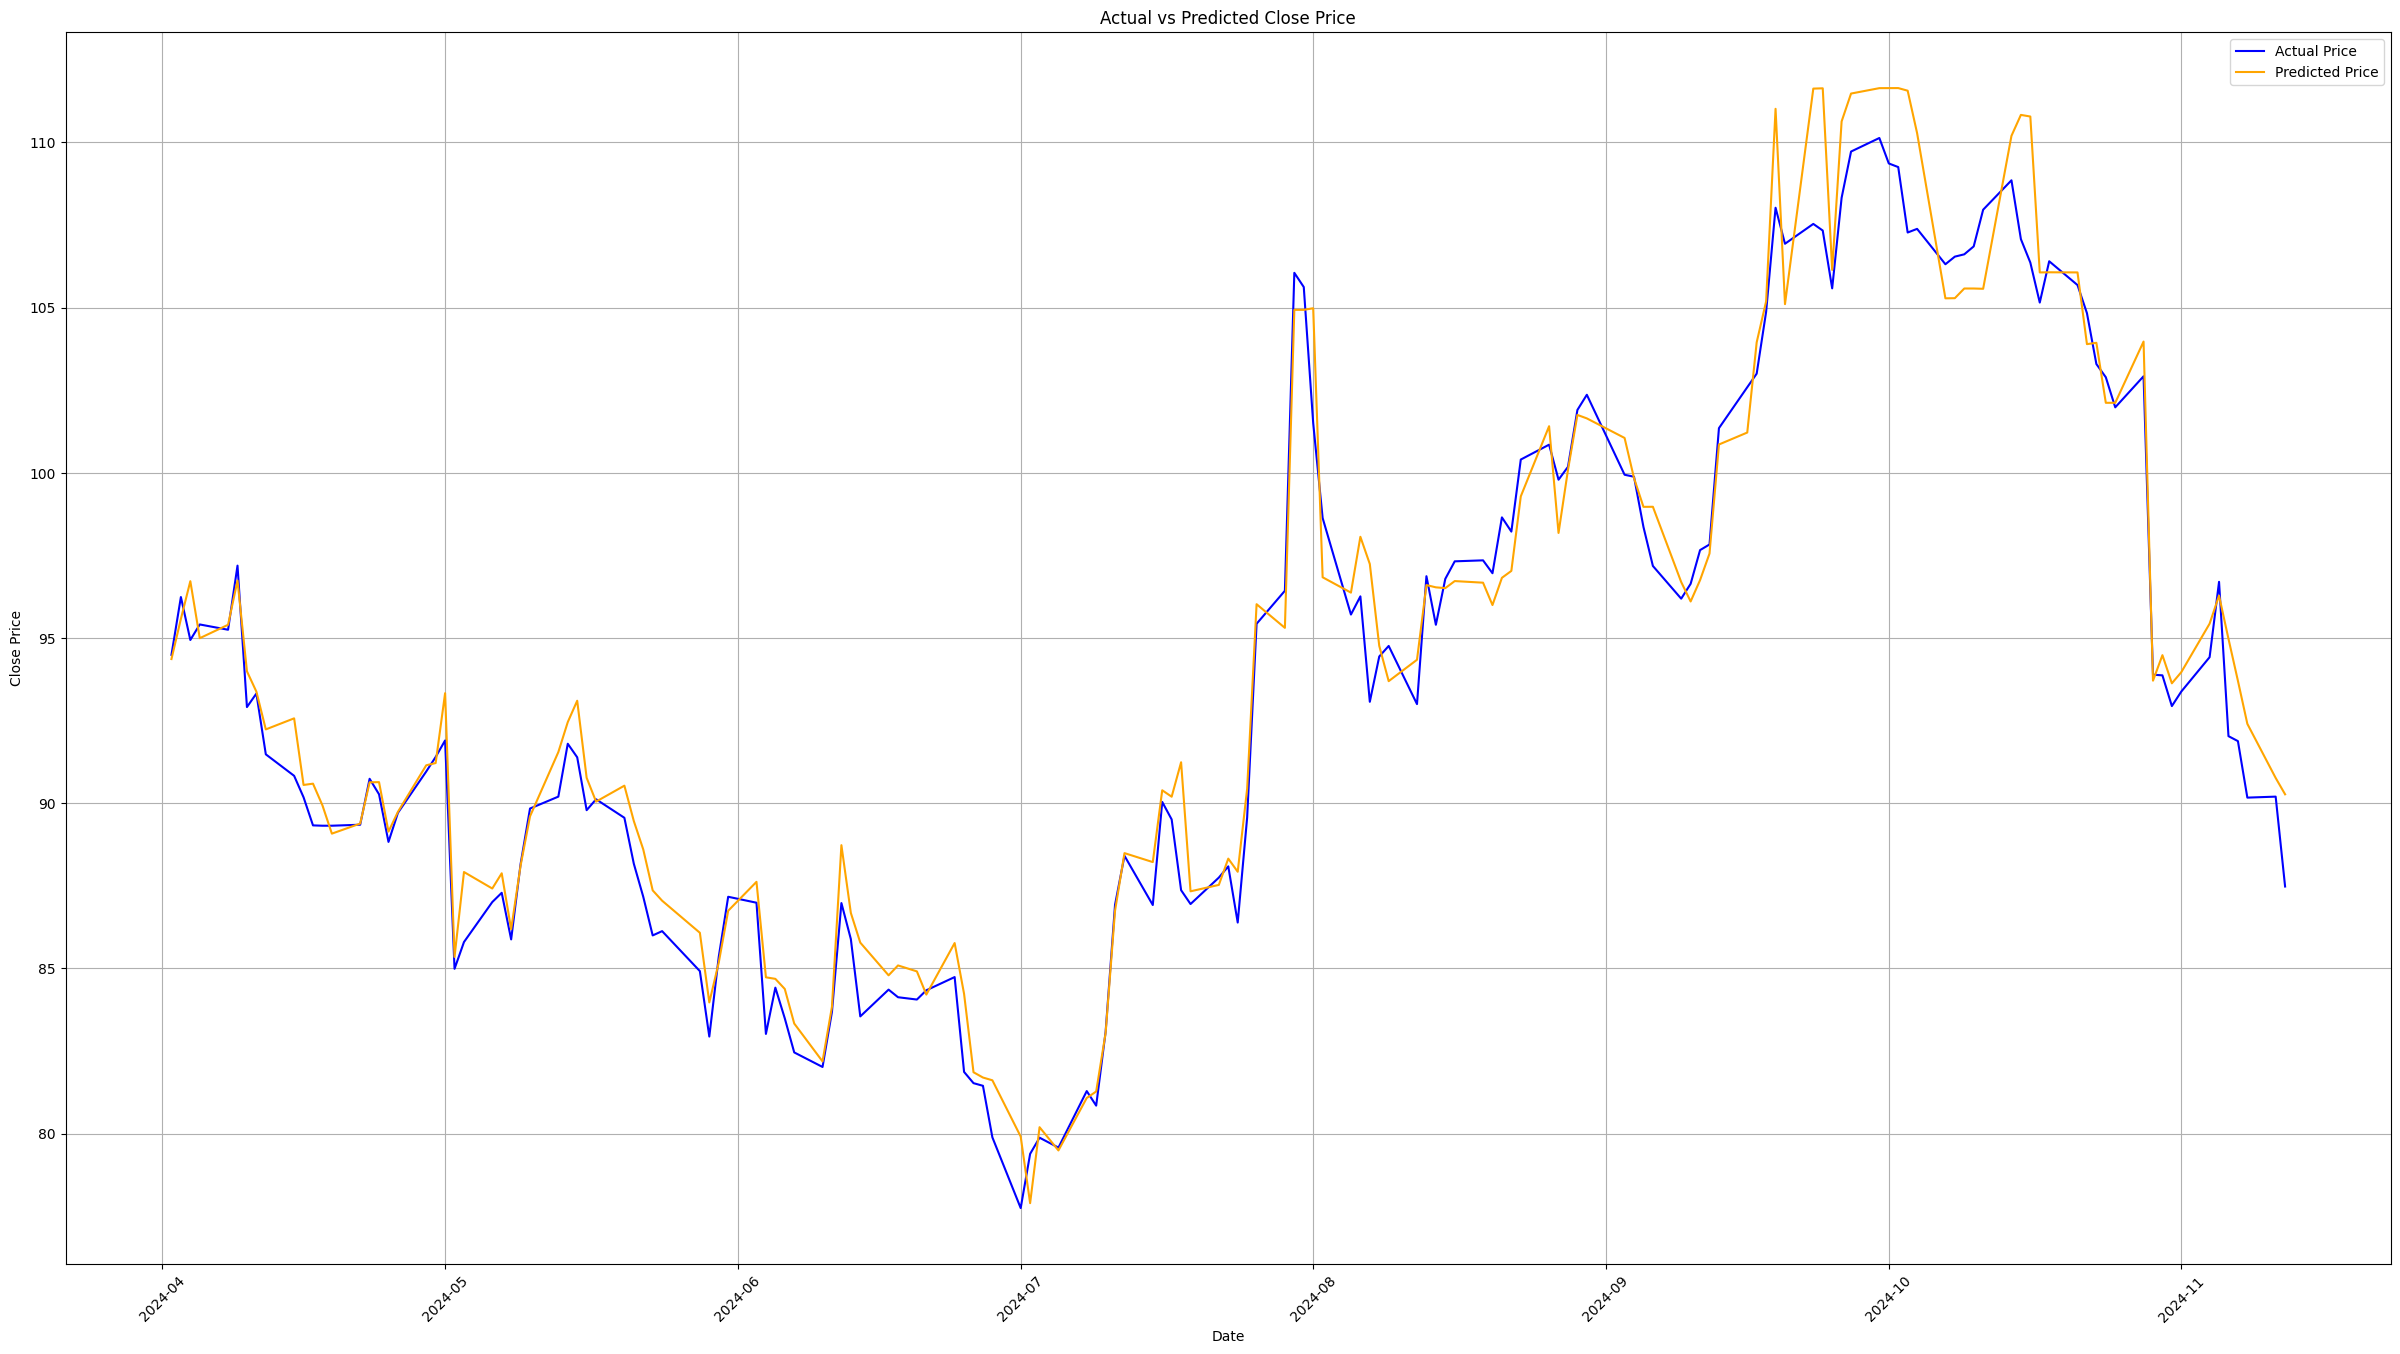

In [84]:
average = []
for i in companies:
    try:
        curr = yf.download(i, start='2024-01-11', end='2024-11-13')
        curr = curr.reset_index()
        curr.columns = [col[0] for col in curr.columns]
        date = curr['Date']
        target_act = curr['Close']
        curr.drop(columns=['Date'], inplace=True)
        empty_data = pd.DataFrame()

        # Calculate indicators and align data
        result_df, valid_indices = calculate_tech_ind(curr, empty_data)

        # Align dates and target with valid rows
        aligned_dates = date.iloc[valid_indices].reset_index(drop=True)
        aligned_target = target_act.iloc[valid_indices].reset_index(drop=True)

        # Scale target for modeling
        standard_scaler_close = StandardScaler()
        target_scaled = standard_scaler_close.fit_transform(aligned_target.values.reshape(-1, 1))

        # Prepare input data
        input_data = result_df.drop(columns=['Low', 'Open', 'SMA15', 'BB_lower', 'BB_upper',
                                             'Adj Close', 'Close', 'OBV'])

        # Predict using the loaded model
        y_pred = loaded_model.predict(input_data)

        # Reshape predictions and target
        y_pred_reshaped = pd.DataFrame(y_pred, columns=["Close"]).values.reshape(-1, 1)
        target_reshaped = pd.DataFrame(target_scaled, columns=["Close"]).values.reshape(-1, 1)

        # Evaluate model performance
        mse = mean_squared_error(target_reshaped, y_pred_reshaped)
        rmse = np.sqrt(mse)
        target_actual = target_scaled.reshape(-1)
        target_predicted = y_pred.reshape(-1)

        # Calculate R^2 using sklearn
        r2 = r2_score(target_actual, target_predicted)
        print(f'\nCompany: {i}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rmse}\nR-squared: {r2}')

        # Perform inverse transformation
        y_pred_original = standard_scaler_close.inverse_transform(y_pred_reshaped)
        target_original = standard_scaler_close.inverse_transform(target_reshaped)

        # Plot the actual vs predicted prices
        plt.figure(figsize=(30, 16))
        plt.plot(aligned_dates, target_original, label="Actual Price", color="blue")
        plt.plot(aligned_dates, y_pred_original, label="Predicted Price", color="orange")
        plt.title("Actual vs Predicted Close Price")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.show()
        average.append(r2)
    except Exception as e:
        print(f'Error for {i}: {e}')


In [85]:
import statistics


In [86]:
print('Trial 2:', min(average), max(average), statistics.mean(average))

Trial 2: 0.9548101710880643 0.9887290605166047 0.9746071098678473


Trial 1: 0.9406540715103998 0.9927281557129863 0.9731379277467157

Trial 2: 0.9548101710880643 0.9887290605166047 0.9746071098678473

In [15]:
def final_pcas(data):
    feature_columns = ['Open', 'High', 'Low', 'SMA15', 'EMA5',
            'RSI15', 'BB_upper', 'BB_lower', 'OBV', 'ADX',
            'Aroon_Up', 'Aroon_Down']

    X = data[feature_columns]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=8)  
    X_pca = pca.fit_transform(X_scaled)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)


    n_components_to_keep = np.argmax(cumulative_variance >= 0.90) 
    pca_final = PCA(n_components=n_components_to_keep)
    X_final = pca_final.fit_transform(X_scaled)

    pca_columns = [f'PC{i+1}' for i in range(n_components_to_keep)]
    pca_df = pd.DataFrame(data=X_final, columns=pca_columns)
    data = pd.DataFrame(data=data, columns=['MACD', 'MACD_signal', 'Close'])
    result_df = pd.concat([data.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

    return result_df


In [16]:
target = scaled_data[['Close']]  # Ensures 2D shape
standard_scaler_close = StandardScaler()
target_scaled = standard_scaler_close.fit_transform(target)

In [17]:
target_scaled

array([[-3.54472161],
       [-3.40052823],
       [-3.51285686],
       [-2.11180277],
       [-2.44009979],
       [-2.68439098],
       [-2.46327371],
       [-2.38248667],
       [-2.25020292],
       [-2.01170496],
       [-2.18261224],
       [-2.51766803],
       [-2.33710438],
       [-2.12306805],
       [-2.11888372],
       [-2.07961683],
       [-1.69917972],
       [-1.39083783],
       [-1.25501311],
       [-1.1500876 ],
       [-1.08635908],
       [-0.85301098],
       [-0.97499599],
       [-0.95632759],
       [-1.33547797],
       [-1.40339082],
       [-1.23698906],
       [-1.07219718],
       [-1.1047053 ],
       [-1.35382419],
       [-0.99977881],
       [-1.04966663],
       [-1.11629177],
       [-0.98239812],
       [-0.91834841],
       [-0.69851885],
       [-0.67341287],
       [-0.77093722],
       [-0.70077112],
       [-0.49800006],
       [-0.55014114],
       [-0.51183978],
       [-0.61547856],
       [-0.75033774],
       [-1.14171894],
       [-1

In [18]:

input = scaled_data.drop(columns=['Low', 'Open','SMA15', 'BB_lower', 'BB_upper', 'Adj Close', 'Close', 'OBV'])

In [19]:
#input['H-L'] = input['High'] - input['Low']

In [20]:
from joblib import load

loaded_model = load('model_reg.joblib')

In [21]:
target

Close
18   344.929993
19   349.410004
20   345.920013
21   389.450012
22   379.250000
..          ...
207  476.760010
208  476.760010
209  476.760010
210  476.760010
211  476.760010

[406 rows x 1 columns]

In [22]:
target_scaled

array([[-3.54472161],
       [-3.40052823],
       [-3.51285686],
       [-2.11180277],
       [-2.44009979],
       [-2.68439098],
       [-2.46327371],
       [-2.38248667],
       [-2.25020292],
       [-2.01170496],
       [-2.18261224],
       [-2.51766803],
       [-2.33710438],
       [-2.12306805],
       [-2.11888372],
       [-2.07961683],
       [-1.69917972],
       [-1.39083783],
       [-1.25501311],
       [-1.1500876 ],
       [-1.08635908],
       [-0.85301098],
       [-0.97499599],
       [-0.95632759],
       [-1.33547797],
       [-1.40339082],
       [-1.23698906],
       [-1.07219718],
       [-1.1047053 ],
       [-1.35382419],
       [-0.99977881],
       [-1.04966663],
       [-1.11629177],
       [-0.98239812],
       [-0.91834841],
       [-0.69851885],
       [-0.67341287],
       [-0.77093722],
       [-0.70077112],
       [-0.49800006],
       [-0.55014114],
       [-0.51183978],
       [-0.61547856],
       [-0.75033774],
       [-1.14171894],
       [-1

In [23]:
y_pred = loaded_model.predict(input)

# Evaluate the model performance
mse = mean_squared_error(target_scaled, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Optional: Calculate R-squared
r2 = loaded_model.score(input, target_scaled)
print(f'R-squared: {r2}')

print('\n ', y_pred, '\n', target_scaled)

Mean Squared Error: 0.018495854957630793
Root Mean Squared Error (RMSE): 0.13599946675495017
R-squared: 0.9815041450423692

  [-2.2032757  -2.1954792  -2.1954792  -2.209654   -2.209654   -2.2066128
 -2.2111175  -2.211152   -2.2038085  -2.2038085  -2.2038085  -2.2033138
 -2.2367177  -2.2348807  -2.2038085  -2.2038085  -1.8559512  -1.4458197
 -1.2934594  -1.2296323  -1.0825769  -0.8937128  -0.98333454 -1.0193983
 -1.3656032  -1.411449   -1.3052791  -1.1844667  -1.0179286  -1.2765303
 -1.0658867  -1.0758193  -1.0873362  -1.0954498  -0.9213228  -0.80160314
 -0.76017207 -0.80716395 -0.7665498  -0.59589964 -0.5641421  -0.5650364
 -0.6853683  -0.73479915 -1.025767   -1.1872232  -1.1209432  -1.1945534
 -1.0480331  -1.126034   -1.1568234  -1.1844667  -1.411449   -1.2223698
 -1.437087   -1.2363775  -1.2940006  -1.3283412  -1.5172579  -1.0480331
 -1.0747899  -1.3767436  -1.1364409  -1.1541773  -1.2364241  -1.1844667
 -1.0751797  -0.79896617 -0.9569209  -1.210622   -1.5844048  -1.6337534
 -1.71442

In [24]:
len(y_pred)

406

Mean Squared Error: 0.00026662786562003173
Root Mean Squared Error (RMSE): 0.016328743540763684
Mean Squared Error: 0.0002666256388325786
Root Mean Squared Error (RMSE): 0.01632867535449764
R-squared: 0.0


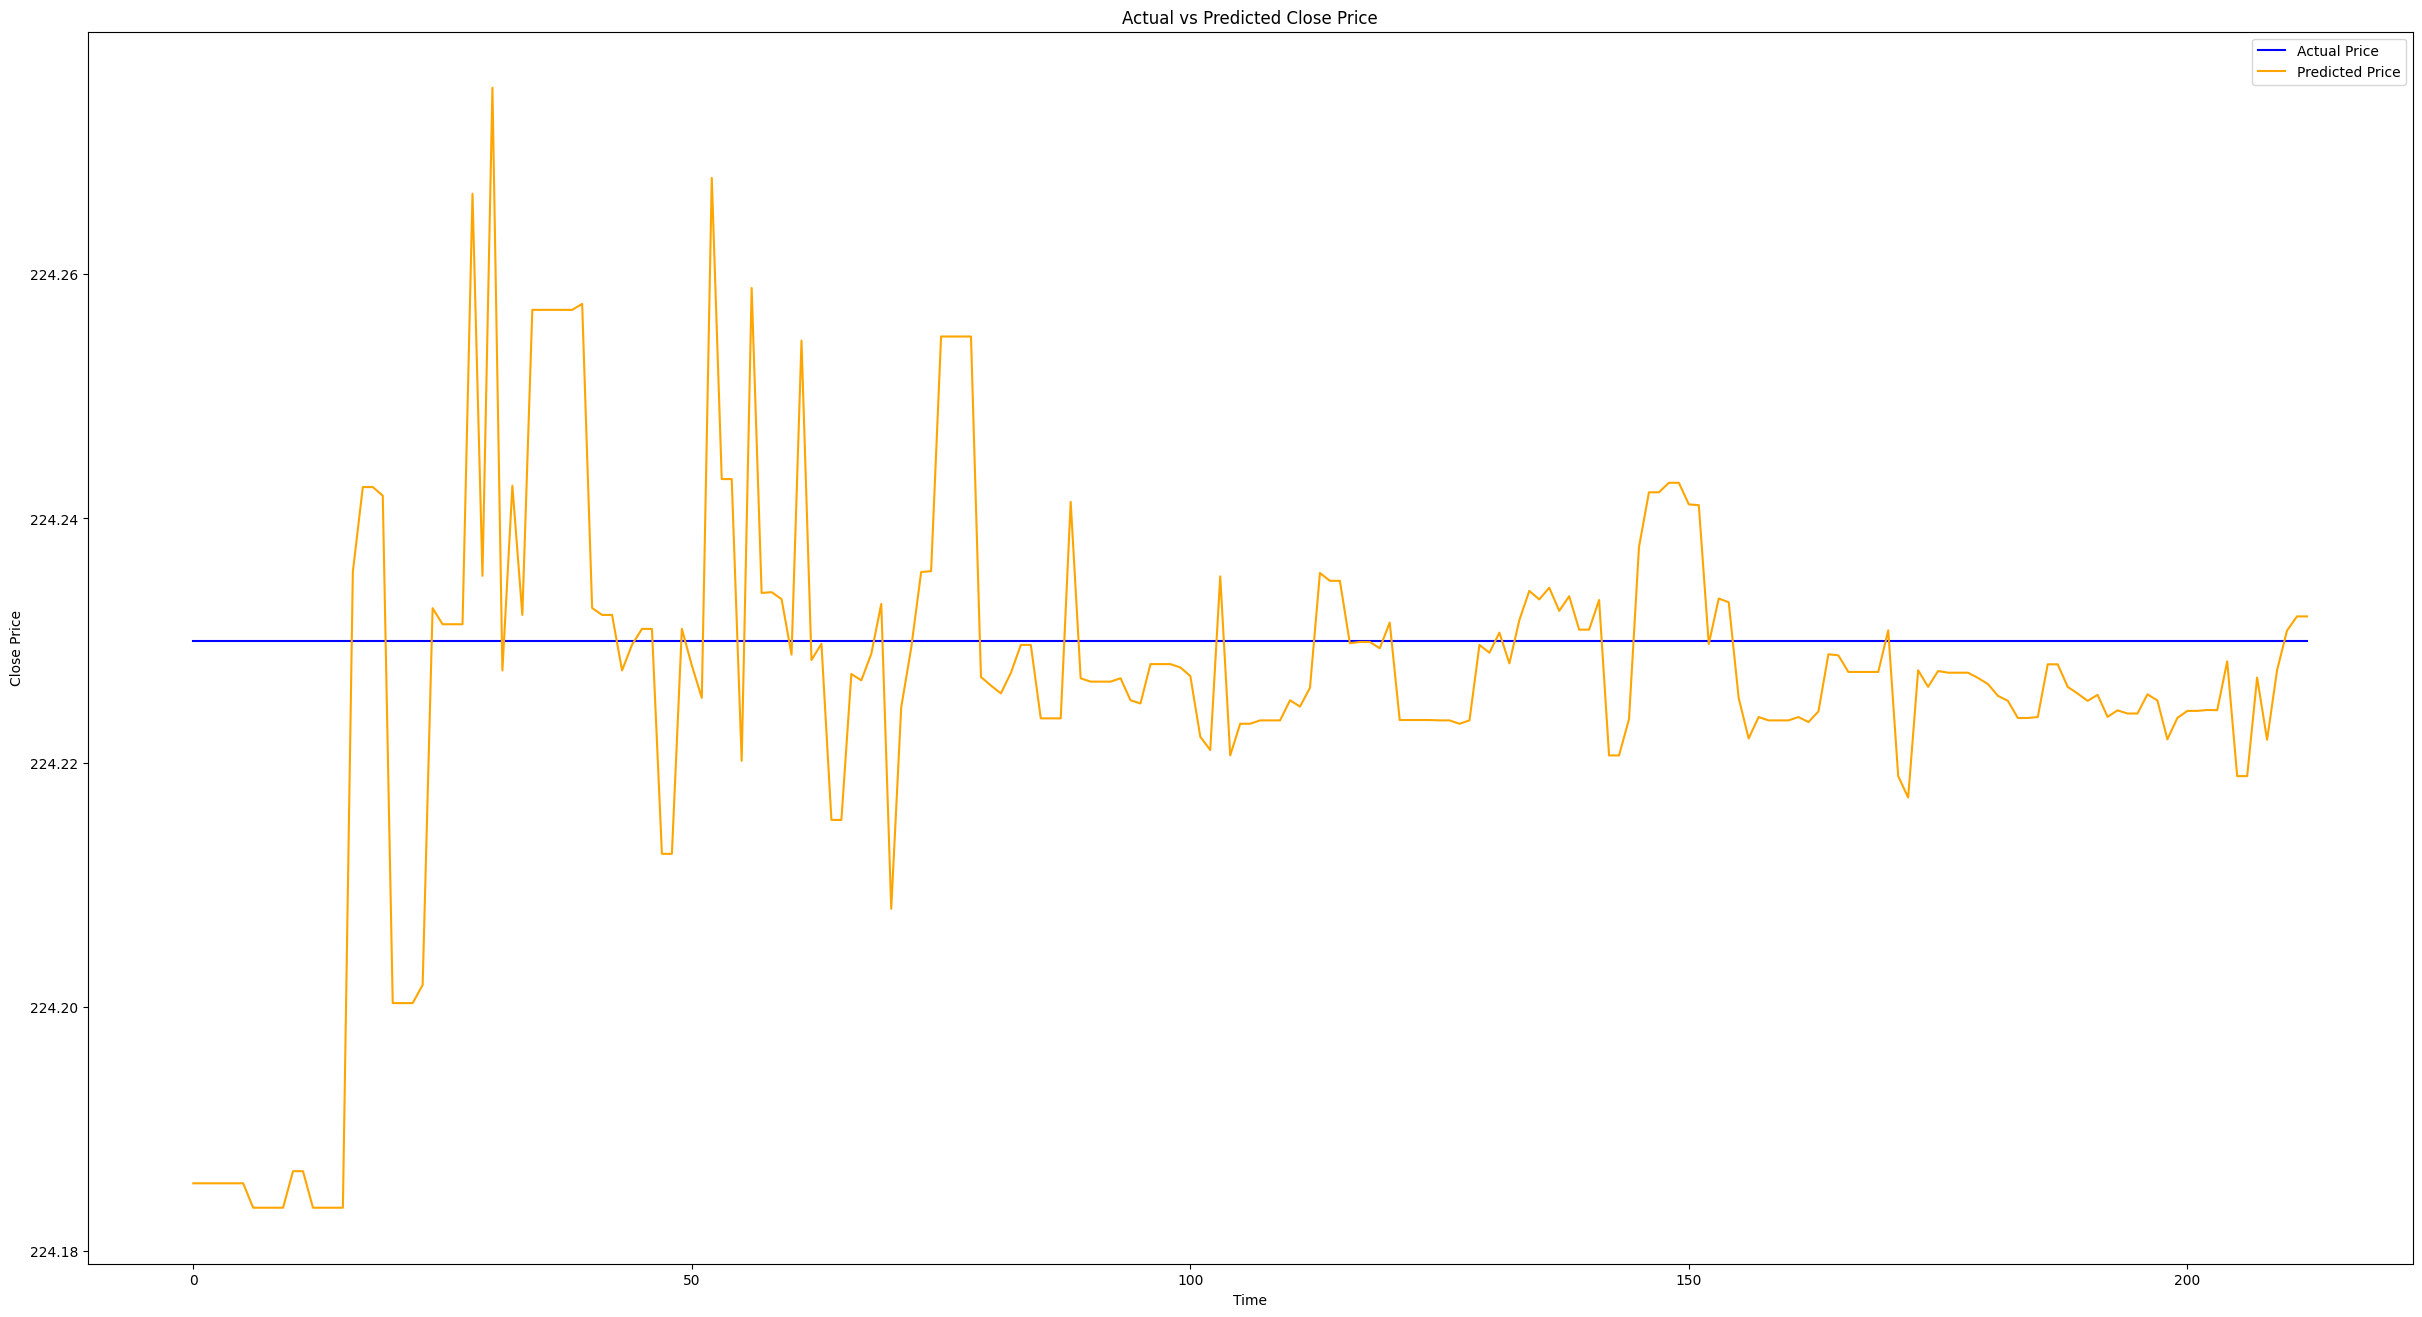

In [12]:
# Ensure y_pred and target are single-column DataFrames before reshaping
y_pred_reshaped = pd.DataFrame(y_pred, columns=["Close"]).values.reshape(-1, 1)
target_reshaped = pd.DataFrame(target_scaled, columns=["Close"]).values.reshape(-1, 1)

mse = mean_squared_error(target_reshaped, y_pred_reshaped)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Perform inverse transformation
y_pred_original = standard_scaler_close.inverse_transform(y_pred_reshaped)
target_original = standard_scaler_close.inverse_transform(target_reshaped)

# Plot the original vs. predicted values
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(target_original, y_pred_original)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared: {r2}')

plt.figure(figsize=(30, 16))
plt.plot(target_original, label="Actual Price", color="blue")
plt.plot(y_pred_original, label="Predicted Price", color="orange")
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [8]:
input

High        Volume      EMA5     RSI15      MACD  MACD_signal       ADX  \
211   0.0 -3.552714e-15 -0.743616 -0.691349 -0.900536    -0.094811  0.536515   
0     0.0 -3.552714e-15 -0.743616 -0.691349 -0.900536    -0.094811  0.536515   
1     0.0 -3.552714e-15 -0.743616 -0.691349 -0.900536    -0.094811  0.536515   
2     0.0 -3.552714e-15 -0.743616 -0.691349 -0.900536    -0.094811  0.536515   
3     0.0 -3.552714e-15 -0.743616 -0.691349 -0.900536    -0.094811  0.536515   
..    ...           ...       ...       ...       ...          ...       ...   
207   0.0 -3.552714e-15  0.985059 -0.956401 -0.578368    -1.672526 -0.998615   
208   0.0 -3.552714e-15  1.033269 -0.260272 -0.544905    -1.240033 -1.067081   
209   0.0 -3.552714e-15  1.057714 -0.327465 -0.527894    -0.945124 -1.148568   
210   0.0 -3.552714e-15  1.033604 -0.667969 -0.575392    -0.909502 -1.127908   
211   0.0 -3.552714e-15  1.017531 -0.667969 -0.609365    -0.839008 -1.108724   

     Aroon_Up  Aroon_Down  
211 -0.612516    0.181826  
0   -0.612516    0.181826  
1   -0.612516    0.181826  
2   -0.612516    0.181826  
3   -0.612516    0.181826  
..        ...         ...  
207  1.191159   -1.028453  
208  0.990751   -1.230167  
209  0.790343   -1.431880  
210  0.589934   -1.431880  
211  0.389526   -1.431880  

[213 rows x 9 columns]

In [15]:
tomorrow_close_pred = y_pred_original[-1]  # Take the last predicted value
print(f"Predicted Close Price for Tomorrow: {tomorrow_close_pred[0]:.2f}")

Predicted Close Price for Tomorrow: 319.42
